In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from optuna.samplers import TPESampler
import sqlalchemy
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge  # 使用 Ridge 回归代替逻辑回归
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from scipy.stats import entropy
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题
import joblib
import sys
print(sys.executable)

C:\Users\Acer\anaconda3\envs\transformer_git\python.exe


In [3]:
num = 44
train = pd.read_csv(f'../train_test_data/data_final_train_{num}_features.csv')
test = pd.read_csv(f'../train_test_data/data_final_test_{num}_features.csv')

In [4]:
print(train.shape)
print(test.shape)
X_train = train.drop(columns='转化率_1')
X_test = test.drop(columns='转化率_1')
y_train = train['转化率_1'].copy()  # 创建副本
y_test = test['转化率_1'].copy()  # 创建副本

y_train[y_train <= 1] = 0
y_test[y_test <= 1] = 0

y_train[y_train >= 2] = 1
y_test[y_test >= 2] = 1

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(19654, 45)
(3543, 45)
(19654, 44) (19654,)
(3543, 44) (3543,)


In [5]:
train.columns

Index(['log_销量_编码', '佣金率_unimp_cluster_WOE', '1_cluster_label__OHE',
       'sqrt_带货直播', '销售均价最大差值_counts', 'log_直播销量_编码',
       '直播销量_编码_unimp_cluster_WOE', 'y_J_佣金率', 'cluster_label_counts',
       '互动率_unimp_cluster_WOE', 'bx_cx_直播销售额_编码', 'per60-100_销售均价分位数__OHE',
       '100_销售均价最大差值__OHE', '销售均价最大差值_count_label', '2_cluster_label__OHE',
       '带货直播_unimp_cluster_WOE', 'log_sqrt粉丝数', '0_销售均价最大差值__OHE',
       '销售均价分位数_counts', '商品价格中位数_groupby_cluster', '商品价格最大差值', 'bx_cx_视频热度',
       'bx_cx_商品价格中位数', 'per30-60_销售均价分位数__OHE', 'log_sqrt互动率',
       '视频热度_unimp_cluster_WOE', '粉丝数_unimp_cluster_WOE',
       'per0-10_销售均价分位数__OHE', '销售额_编码_unimp_cluster_WOE', '10_销售均价最大差值__OHE',
       '直播销售额_编码_unimp_cluster_WOE', '销量_编码_unimp_cluster_WOE', 'y_J_上架距今(天)',
       'cluster_label_count_label', '销售额_编码', '互动量_unimp_cluster_WOE',
       '200_销售均价最大差值__OHE', '销售均价分位数_count_label', '上架距今(天)_unimp_cluster_WOE',
       '0_cluster_label__OHE', '销售均价_groupby_cluster', '3_cluster_label__OHE',

In [6]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

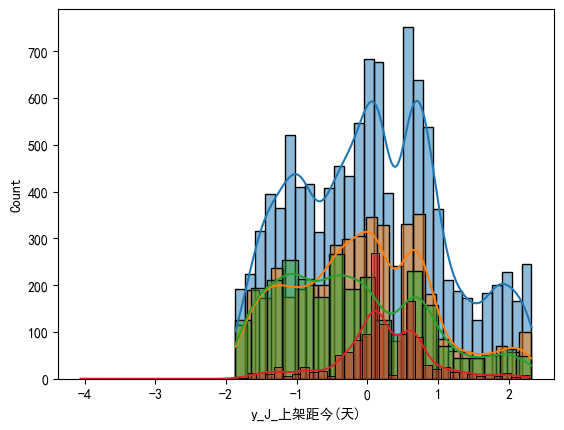

In [7]:
def plot_distribution(df,y,feature):
    for yi in df[y].unique():
        sns.histplot(df[df[y] == yi][feature],kde=True)
    plt.show()    
    df[y].value_counts()
    #     plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plot_distribution(train,'转化率_1','y_J_上架距今(天)')

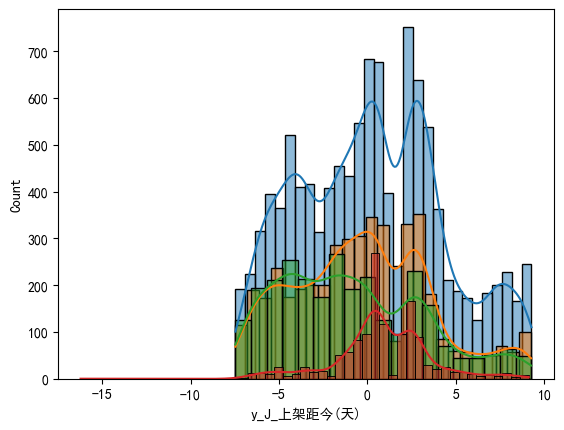

In [8]:
def change_distribution(df,feature,multiplier):
    df_modified = df.copy()
    column = df[feature]
    mean = column.mean()
    variance = column.var()

    column_modified = mean + multiplier * (column - mean)

    df_modified[feature] = column_modified
    return df_modified

df_modified = change_distribution(train,'y_J_上架距今(天)',4)
plot_distribution(df_modified,'转化率_1','y_J_上架距今(天)')

In [9]:
# df.sort_values(by='佣金率',ascending = True)
# X.dtypes
# X.columns
# y.unique()

# 分布敏感性测试

In [10]:
# 定义倍数范围（0.4 到 2.0，步长 0.3）
multipliers = np.arange(0.5, 3.4, 0.4)

def sensitivity(model,name,multipliers,X_test,y_test,y_pred):
    sensitivity_results = []
    # 对每个倍数进行测试
    for feature in X_test.columns:
        for multiplier in multipliers:
            # 创建调整后的测试集副本
            X_test_modified = change_distribution(X_test,feature,multiplier)

            # 对调整后的测试集进行预测
            if name == 'nerual':
                y_pred_modified = np.argmax(model.predict(X_test_modified), axis=1)
            else:
                # 对其他模型的预测，假设是直接的类别标签
                y_pred_modified = model.predict(X_test_modified)

            y_pred_modified = y_pred_modified.astype(int)
            
            # 计算分类报告（只提取总体准确率和 F1 分数作为示例）
            report = classification_report(y_test, y_pred_modified, output_dict=True)
            accuracy = accuracy_score(y_test, y_pred_modified)
            recall = report['macro avg']['recall']


            # 统计因变量变化的数量
            change_0_to_1 = np.sum((y_pred == 0) & (y_pred_modified == 1))  # 从 0 变为 1 的数量
#             change_0_to_2 = np.sum((y_pred == 0) & (y_pred_modified == 2))  # 从 0 变为 2 的数量
#             change_0_to_3 = np.sum((y_pred == 0) & (y_pred_modified == 3))  # 从 0 变为 3 的数量
            change_1_to_0 = np.sum((y_pred == 1) & (y_pred_modified == 0))  # 从 1 变为 0 的数量
#             change_1_to_2 = np.sum((y_pred == 1) & (y_pred_modified == 2))  # 从 1 变为 2 的数量
#             change_1_to_3 = np.sum((y_pred == 1) & (y_pred_modified == 3))  # 从 1 变为 3 的数量       
#             change_2_to_0 = np.sum((y_pred == 2) & (y_pred_modified == 0))  # 从 2 变为 0 的数量
#             change_2_to_1 = np.sum((y_pred == 2) & (y_pred_modified == 1))  # 从 2 变为 1 的数量
#             change_2_to_3 = np.sum((y_pred == 2) & (y_pred_modified == 3))  # 从 2 变为 3 的数量
#             change_3_to_0 = np.sum((y_pred == 3) & (y_pred_modified == 0))  # 从 3 变为 0 的数量
#             change_3_to_1 = np.sum((y_pred == 2) & (y_pred_modified == 1))  # 从 3 变为 1 的数量
#             change_3_to_2 = np.sum((y_pred == 3) & (y_pred_modified == 2))  # 从 3 变为 2 的数量

            no_change = np.sum(y_pred == y_pred_modified)
            change_rate = 1 - (no_change / len(y_pred))

            rise_num = np.sum(y_pred < y_pred_modified)    #上升数
            reduce_num = np.sum(y_pred > y_pred_modified)  #下降数



            #平均变化
            if no_change != len(y_pred):  # 避免除以零
                mean_shift = np.sum(y_pred - y_pred_modified) / (len(y_pred) - no_change) #无方向距离
                abs_mean_shift = np.sum(np.abs(y_pred - y_pred_modified)) / (len(y_pred) - no_change)#带方向距离
            else:
                mean_shift = 0
                abs_mean_shift = 0

            #方向一致性
            changed_indices = (y_pred != y_pred_modified)

            if np.sum(changed_indices) > 0:  # 确保存在变化的样本
                direction_consistency = np.mean(
                    ((y_test[changed_indices] - y_pred[changed_indices]) *
                     (y_pred_modified[changed_indices] - y_pred[changed_indices])) > 0
                )
            else:
                direction_consistency = np.nan  # 或设置为0，表示没有可分析的变化

            #KL值（分布变化情况）
            if np.any(changed_indices):  # 确保有变化的样本
                num_classes = len(np.unique(np.concatenate([y_pred, y_pred_modified])))  # 确定总类别数
                original_dist = np.bincount(y_pred[changed_indices], minlength=num_classes) / np.sum(changed_indices)
                modified_dist = np.bincount(y_pred_modified[changed_indices], minlength=num_classes) / np.sum(changed_indices)

                # 避免分布中出现零值，添加平滑项
                epsilon = 1e-10
                original_dist += epsilon
                modified_dist += epsilon

                # 计算 KL 散度
                kl_divergence = entropy(original_dist, modified_dist)
            else:
                kl_divergence = 0  # 如果没有变化，设置 KL 散度为 0


            # 将结果存入列表
            sensitivity_results.append({
                'Feature': feature,
                'Multiplier': round(multiplier,2),
                'Accuracy': accuracy,
                'Recall': recall,
                '0_to_1': change_0_to_1,
#                 '0_to_2': change_0_to_2,
#                 '0_to_3': change_0_to_3,
                '1_to_0': change_1_to_0,
#                 '1_to_2': change_1_to_2,
#                 '1_to_3': change_1_to_3,
#                 '2_to_0': change_2_to_0,
#                 '2_to_1': change_2_to_1,
#                 '2_to_3': change_2_to_3,
#                 '3_to_0': change_3_to_0,
#                 '3_to_1': change_3_to_1,
#                 '3_to_2': change_3_to_2,
                'no_change':no_change,
                'change_rate': change_rate,
                'rise_num':rise_num,
                'reduce_num':reduce_num,
                'mean_shift': mean_shift,
                'abs_mean_shift':abs_mean_shift,
                'direction_consistency':direction_consistency,
                'kl_divergence': kl_divergence
            })


#         change_matrix = pd.crosstab(y_pred, y_pred_modified, rownames=['Original'], colnames=['Modified'])

    # 转为 DataFrame
    results_df = pd.DataFrame(sensitivity_results)
    model_name = type(model).__name__
    save_path = f"../sensitivity_data/change_distribution/{model_name}/{name}_sensitivity_test_results.csv"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    results_df.sort_values(by=['Feature','Multiplier'],ascending = True).to_csv(save_path, index=False,encoding = 'gbk')
    print(f"敏感性测试结果已保存为 {save_path}文件！")

In [12]:
Voting_model = joblib.load(f"..\model\VotingClassifier\VotingClassifier_for_{num}_features.pkl")
y_pred = Voting_model.predict(X_test)
y_pred = y_pred.astype(int)
sensitivity(Voting_model,name = f'VotingClassifier_for_{num}_features',multipliers = multipliers,X_test = X_test,y_test = y_test,y_pred = y_pred)

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.19445112166956569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19445112166956569
[LightGBM] [Warning] min_gain_to_split is set=0.1944511216695656

# 可视化敏感性差异

Feature Importance 图像已保存至 ../sensitivity_data/change_distribution/VotingClassifier/VotingClassifier_for_44_features_Accuracy.png


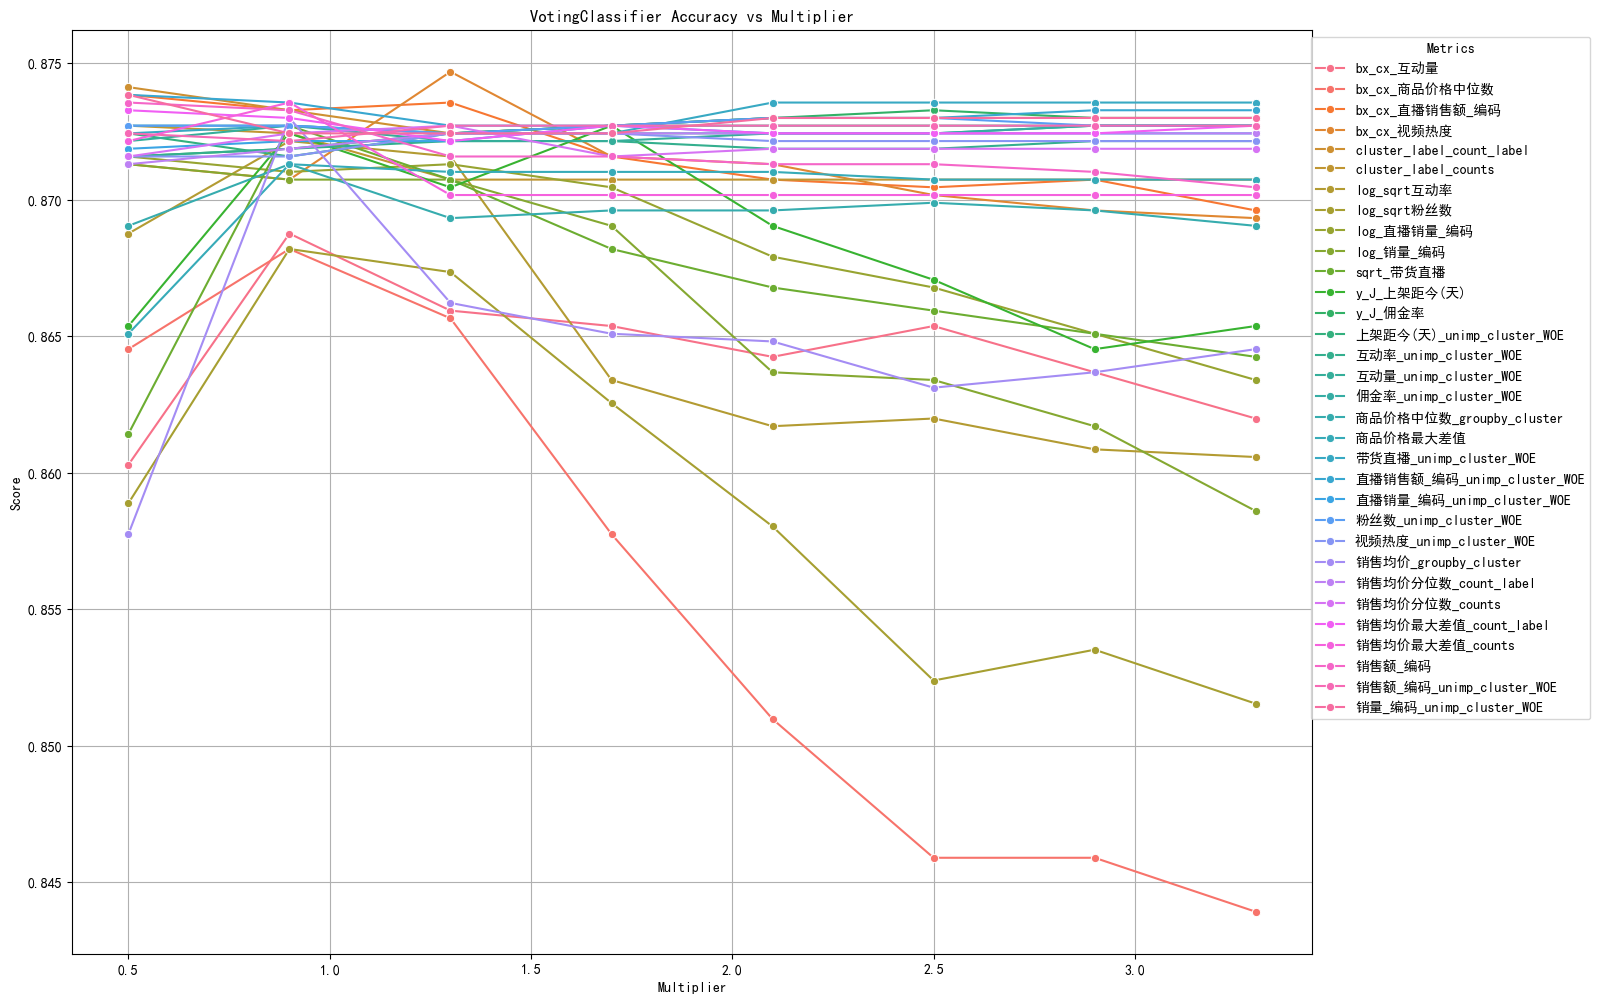

Feature Importance 图像已保存至 ../sensitivity_data/change_distribution/VotingClassifier/VotingClassifier_for_44_features_Recall.png


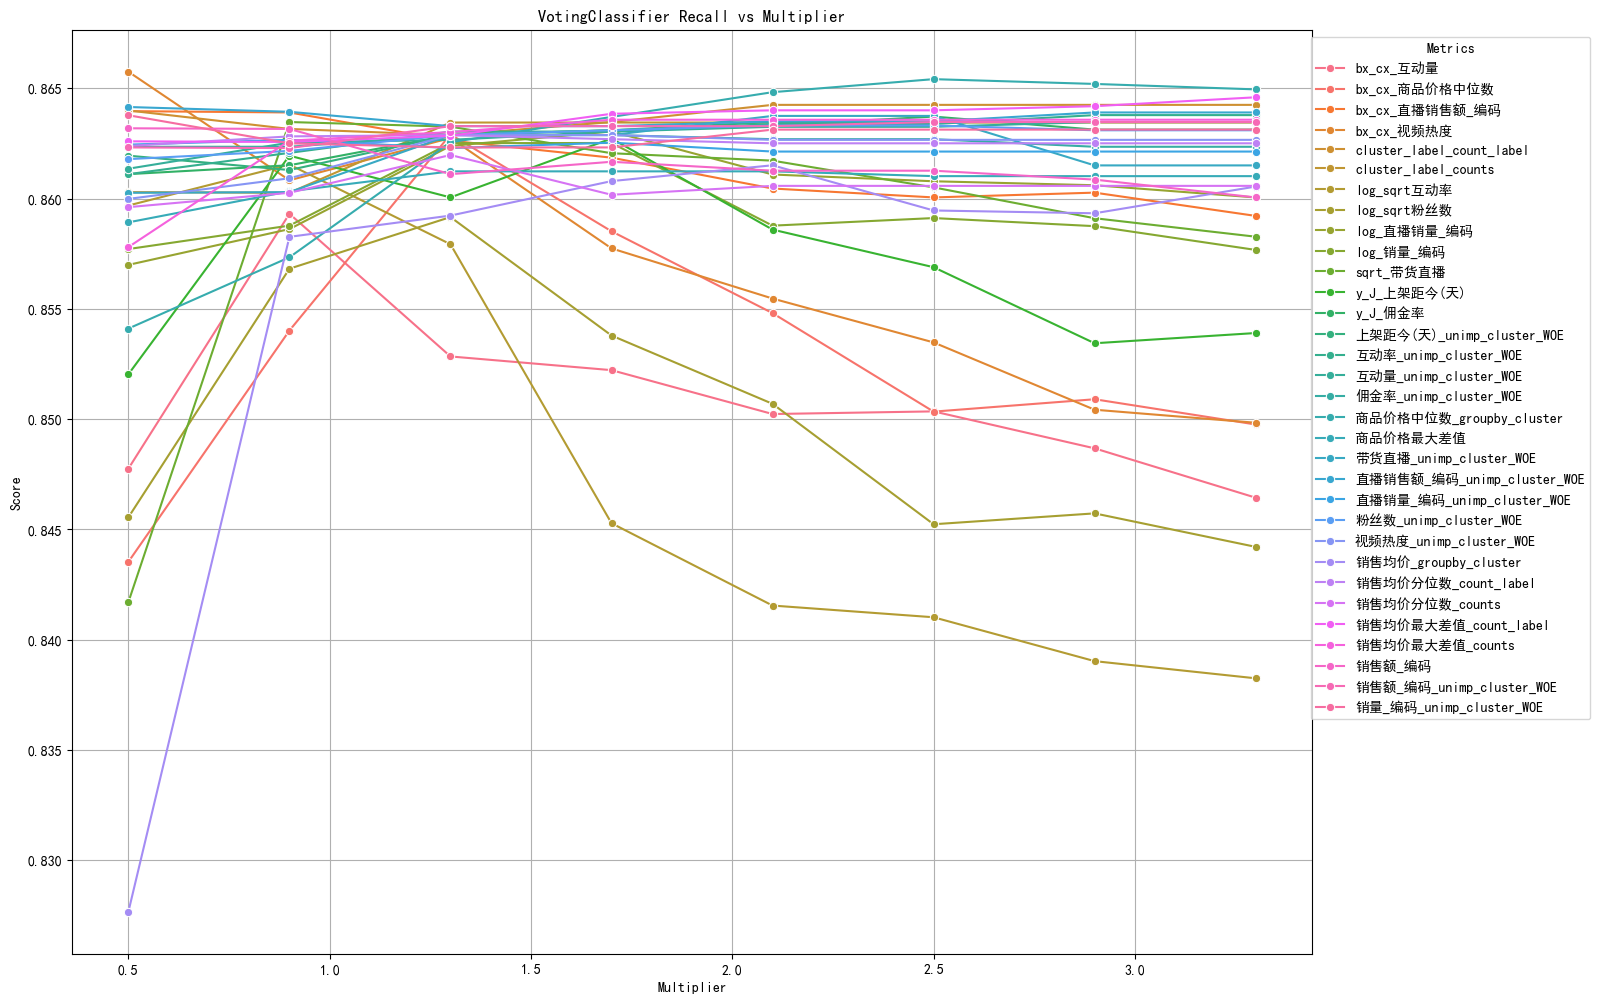

In [13]:
df_path = f'../sensitivity_data/change_distribution/VotingClassifier/VotingClassifier_for_{num}_features_sensitivity_test_results.csv'
def plot_acc_recall(results_csv,score,model_name):
    results_df = pd.read_csv(results_csv,encoding = 'gbk')
    results_df = results_df[~results_df["Feature"].str.contains("OHE", na=False)]
    if score not in ['Accuracy', 'Recall']:
        raise ValueError("score must be 'Accuracy' or 'Recall'")
        
    # 选择需要可视化的列
    plot_columns = ['Multiplier', 'Accuracy', 'Recall']

    # 绘制折线图
    plt.figure(figsize=(16, 12))
    sns.lineplot(data=results_df, x='Multiplier', y=score, marker='o',  color='blue',hue = 'Feature')

    plt.title(model_name+' '+score+' vs Multiplier')
    plt.xlabel('Multiplier')
    plt.ylabel('Score')
    plt.legend(title='Metrics',bbox_to_anchor=(1.23, 1),loc='upper right')
    plt.grid(True)
    
    save_path = f'../sensitivity_data/change_distribution/{model_name}/{model_name}_for_{num}_features_{score}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Feature Importance 图像已保存至 {save_path}")
    plt.show()


plot_acc_recall(df_path,'Accuracy',model_name = 'VotingClassifier')
plot_acc_recall(df_path,'Recall',model_name = 'VotingClassifier')

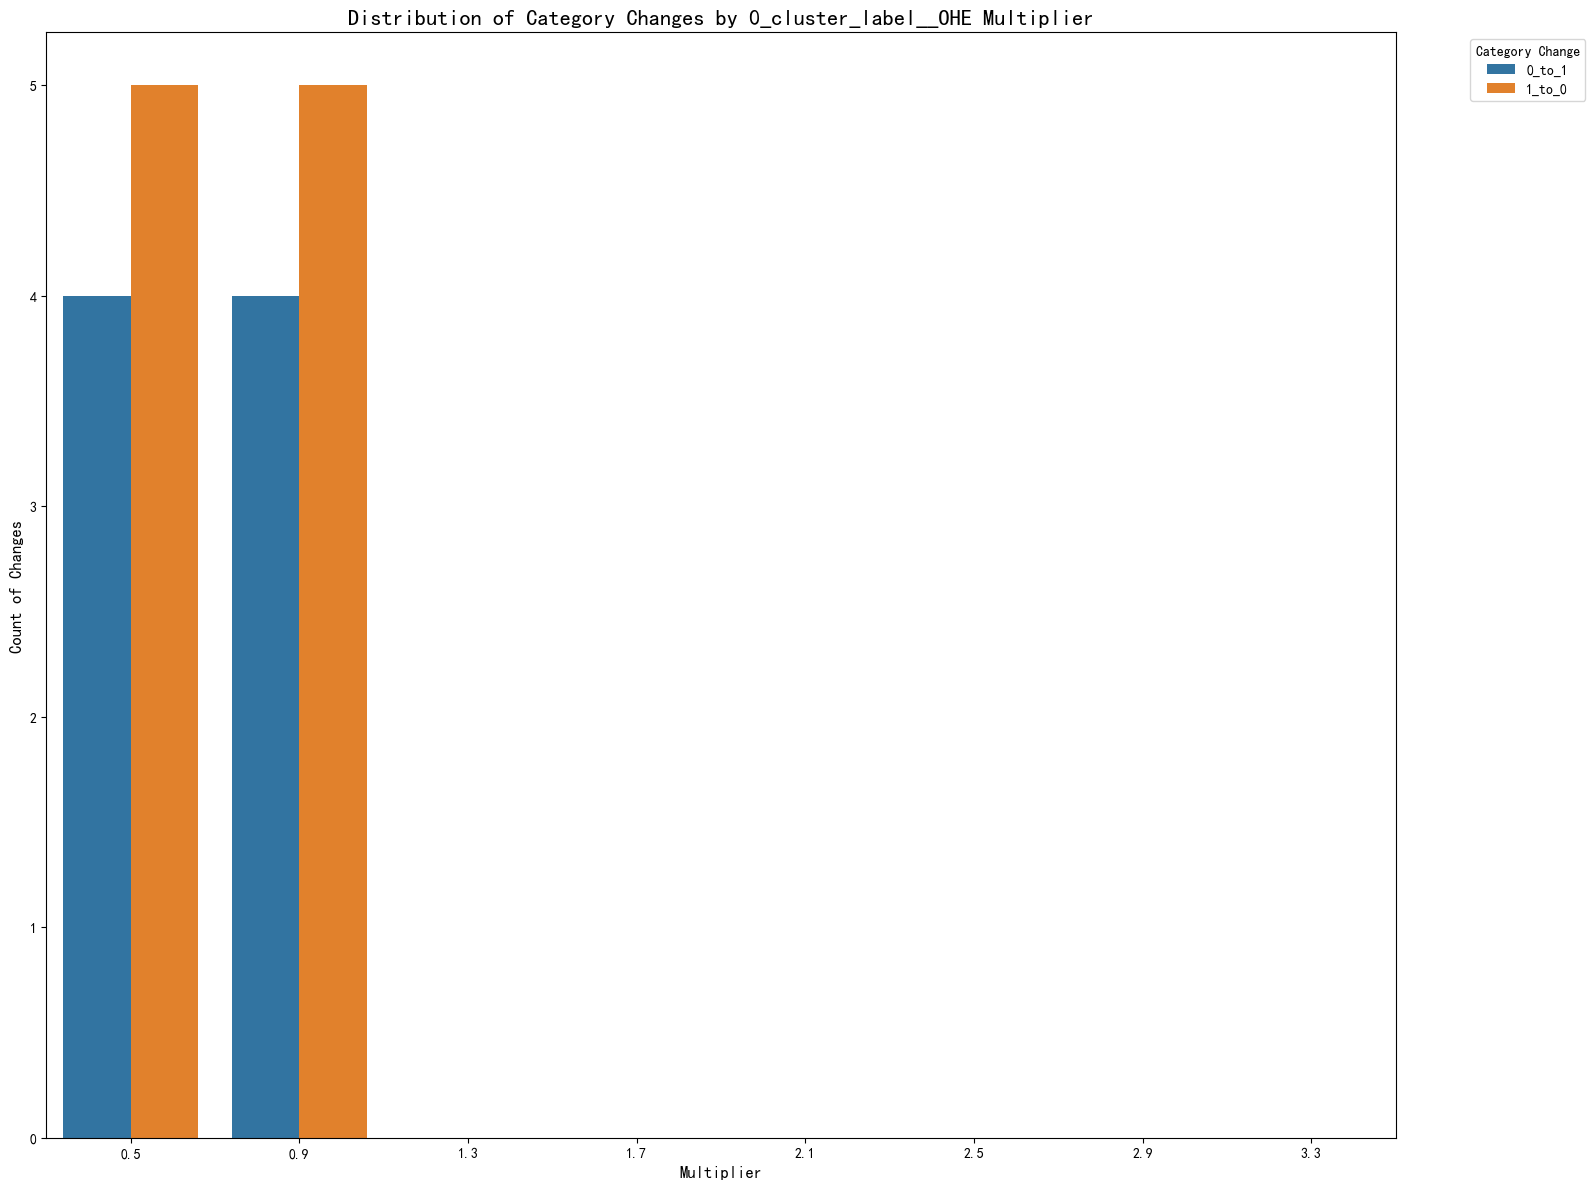

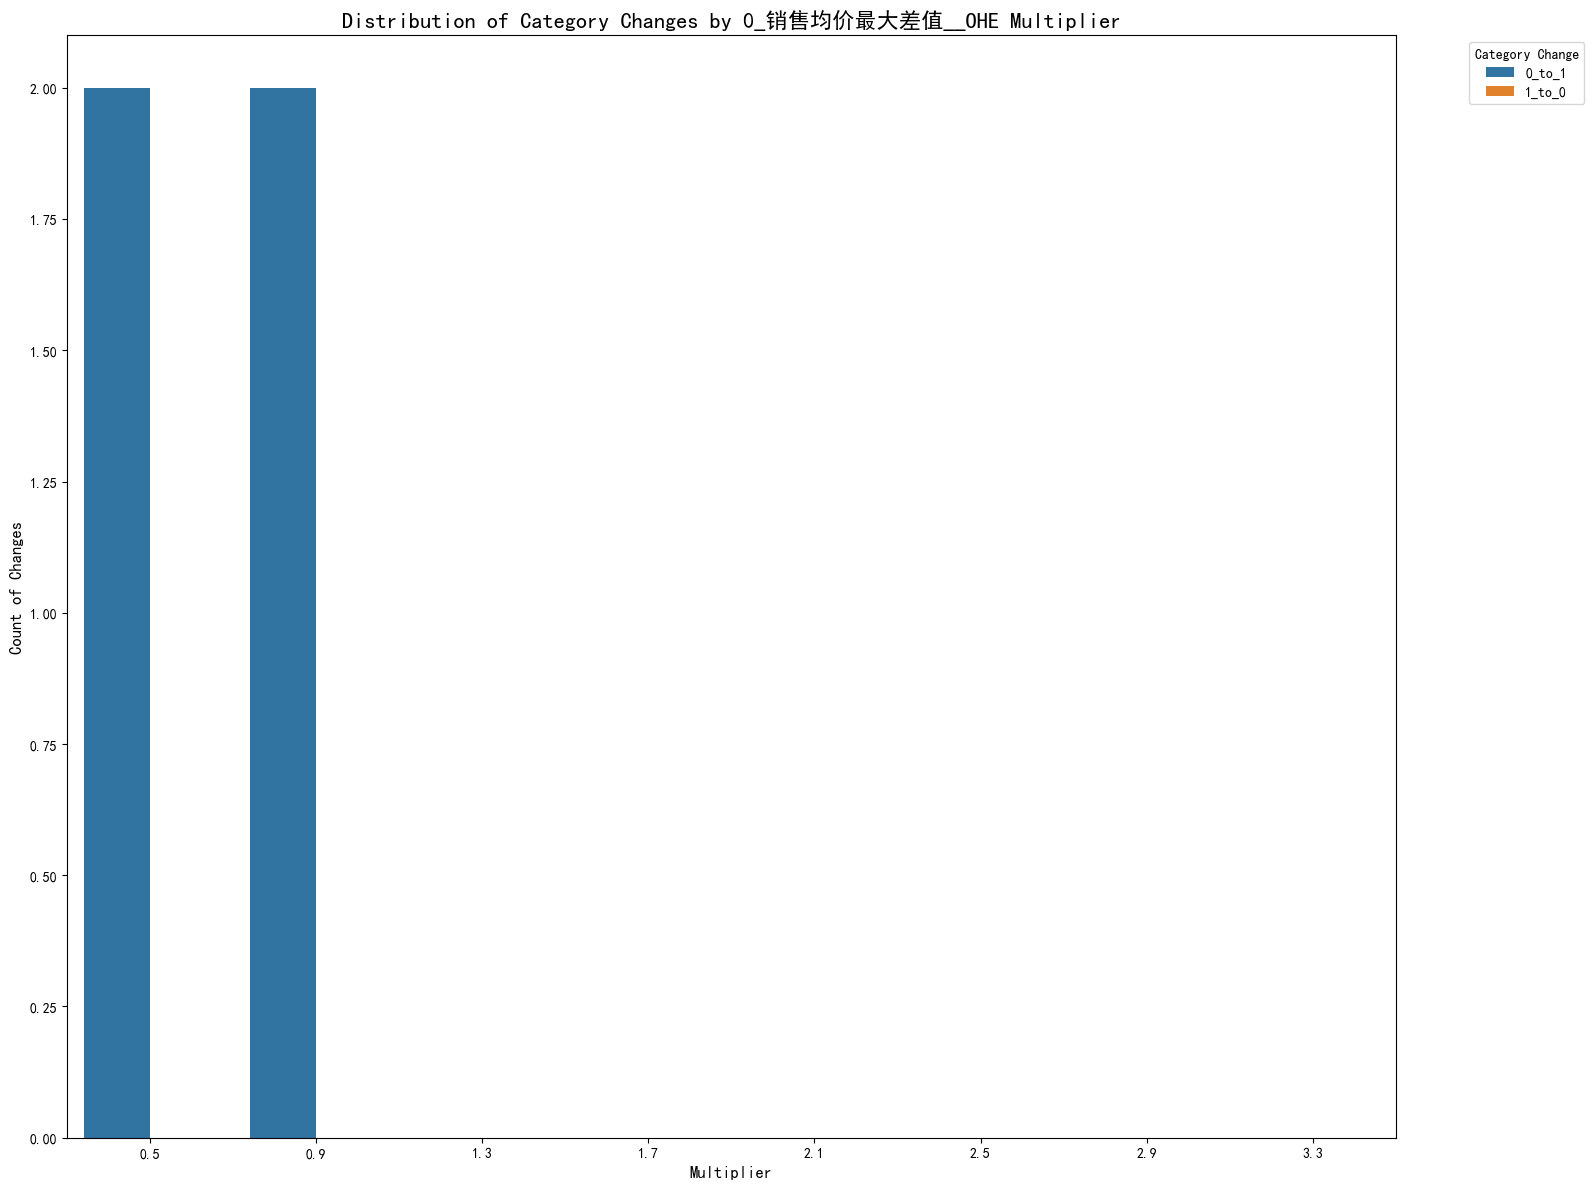

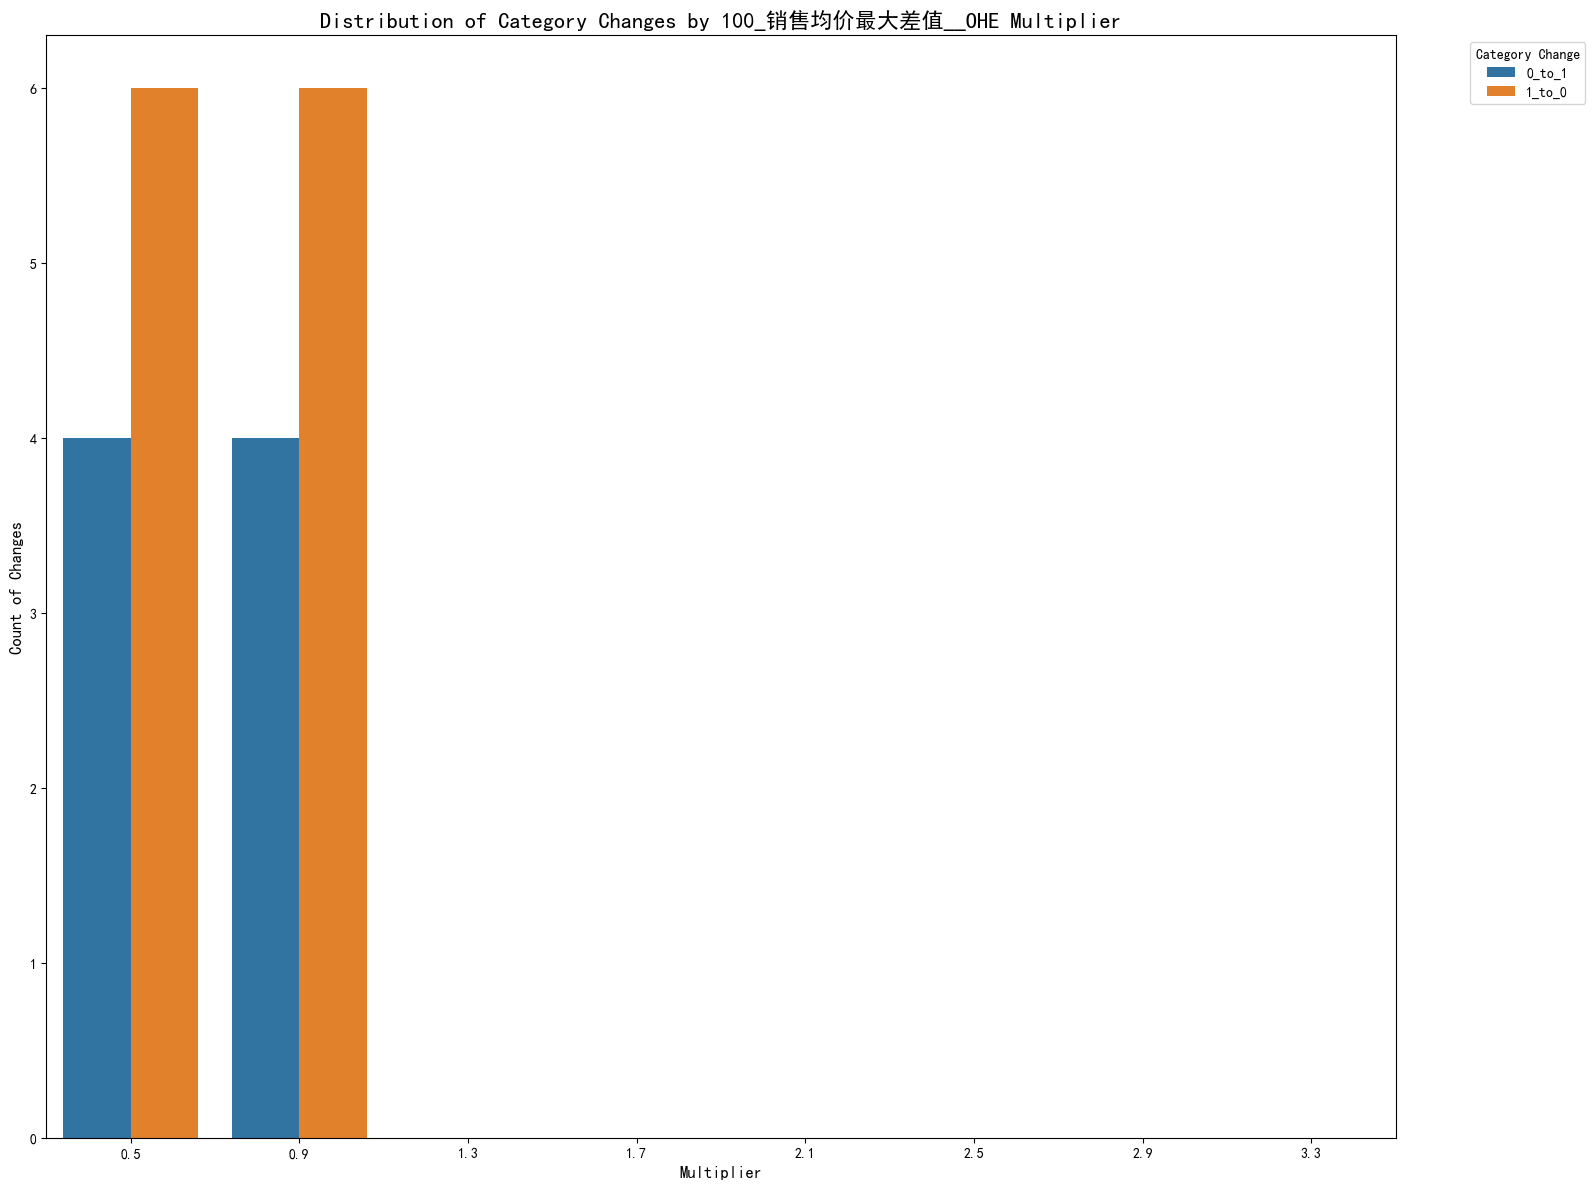

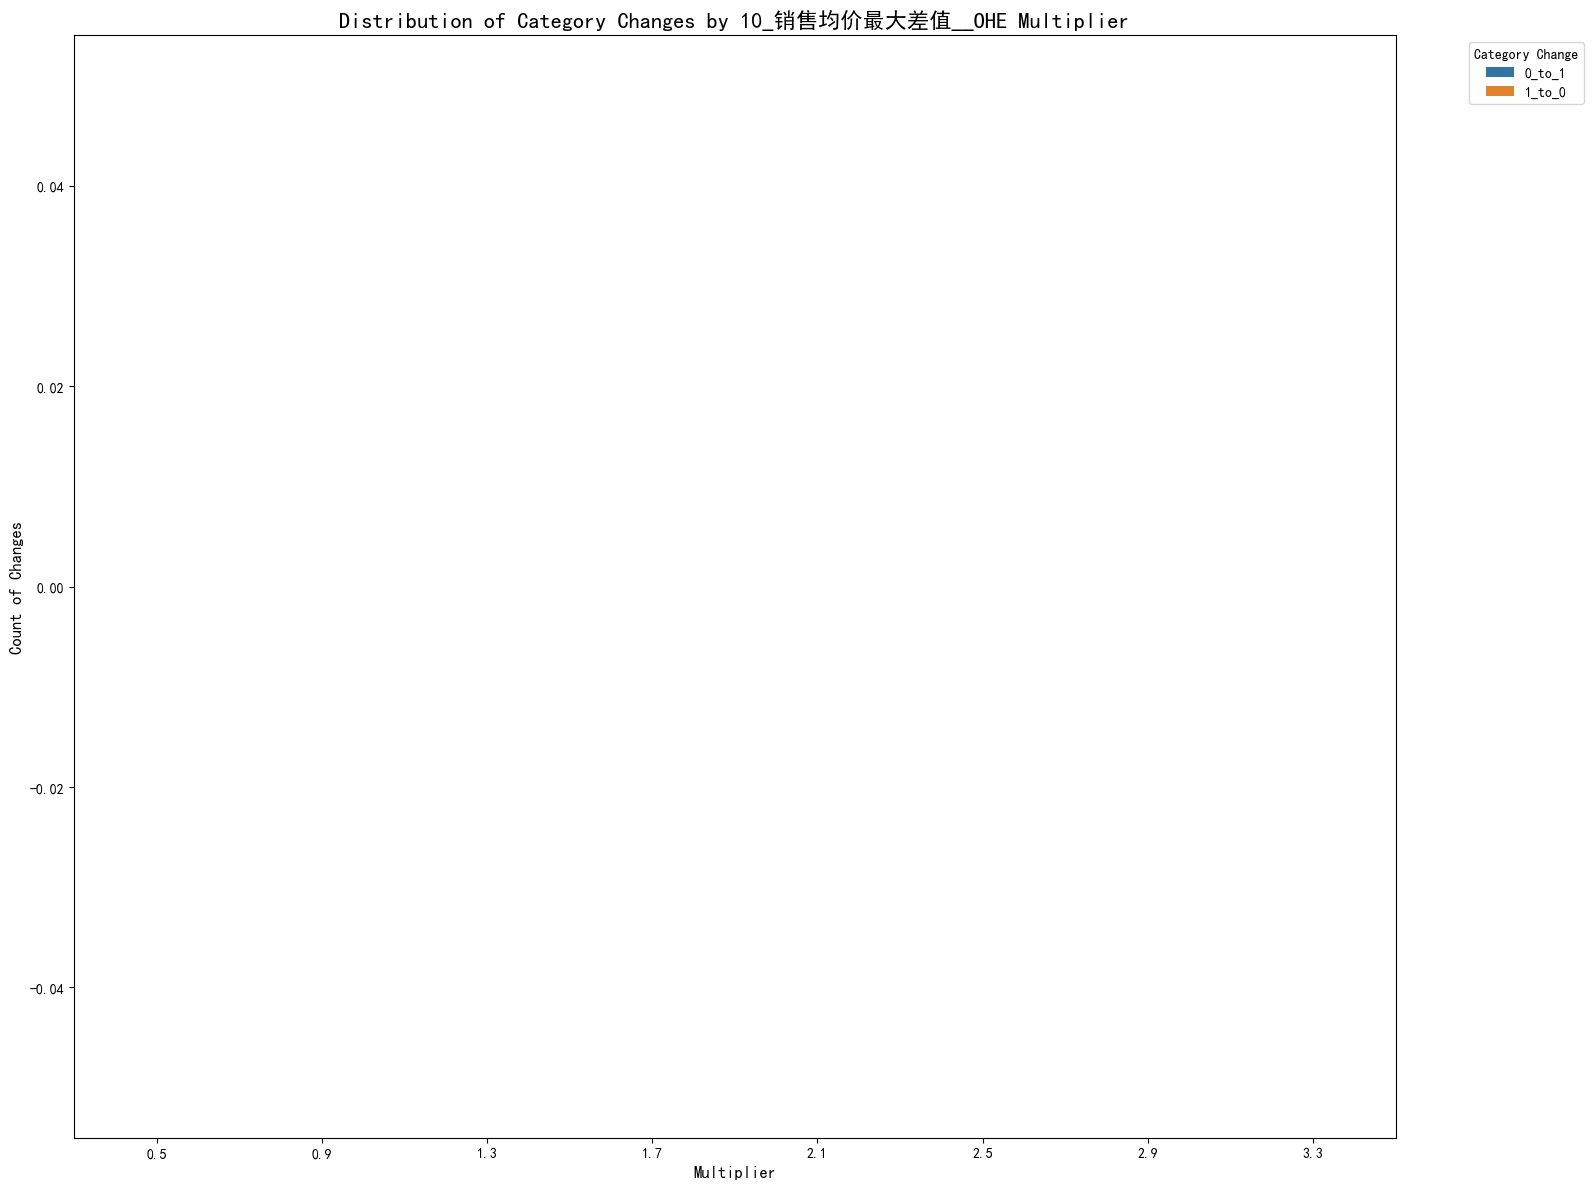

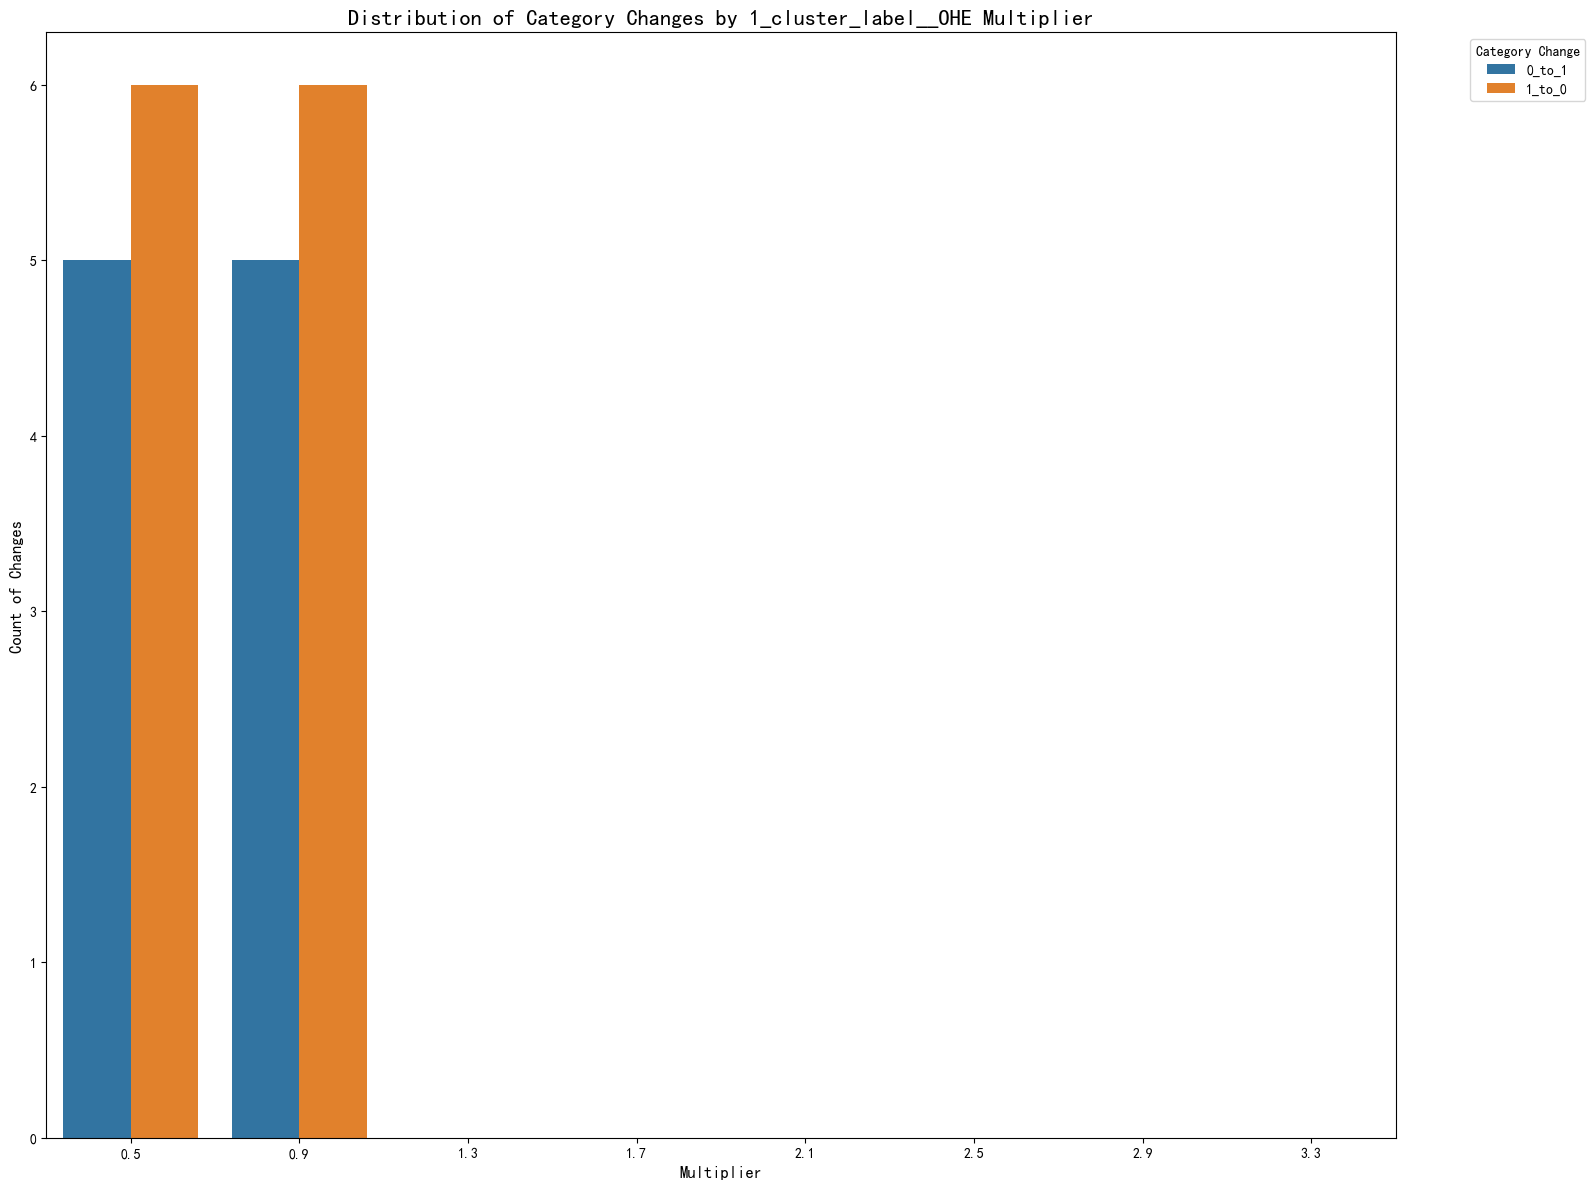

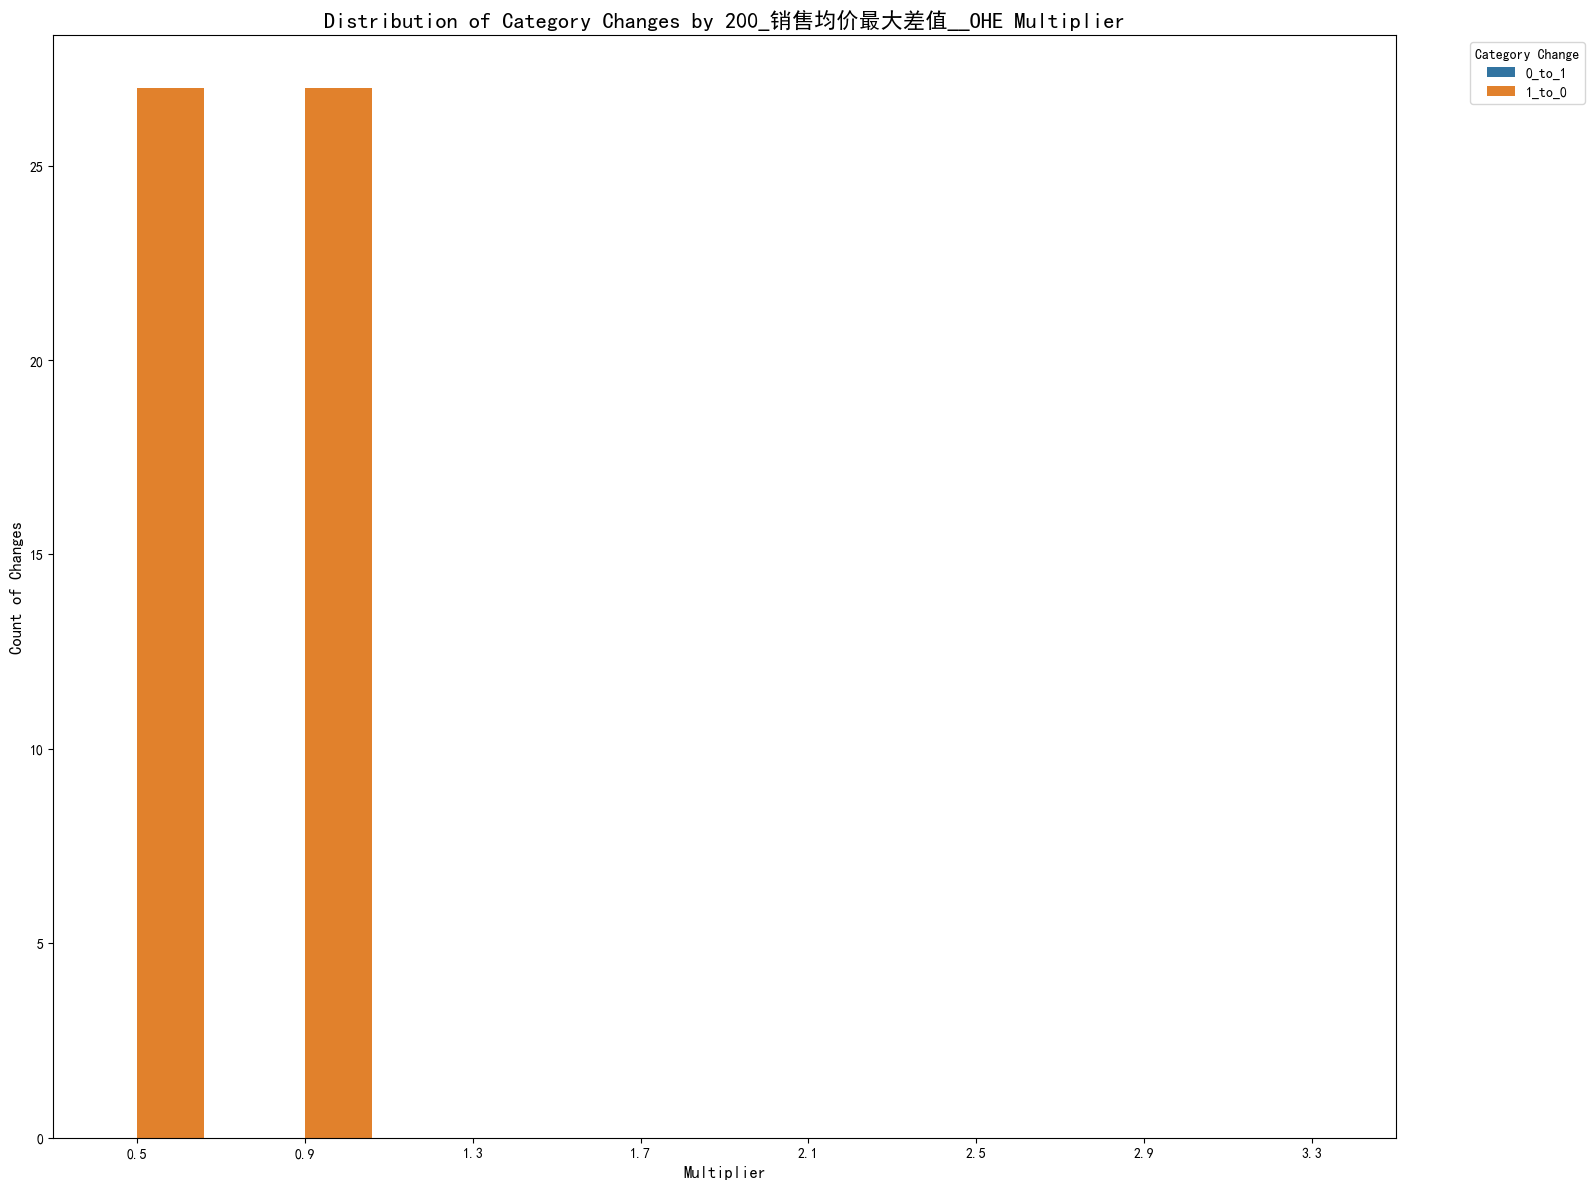

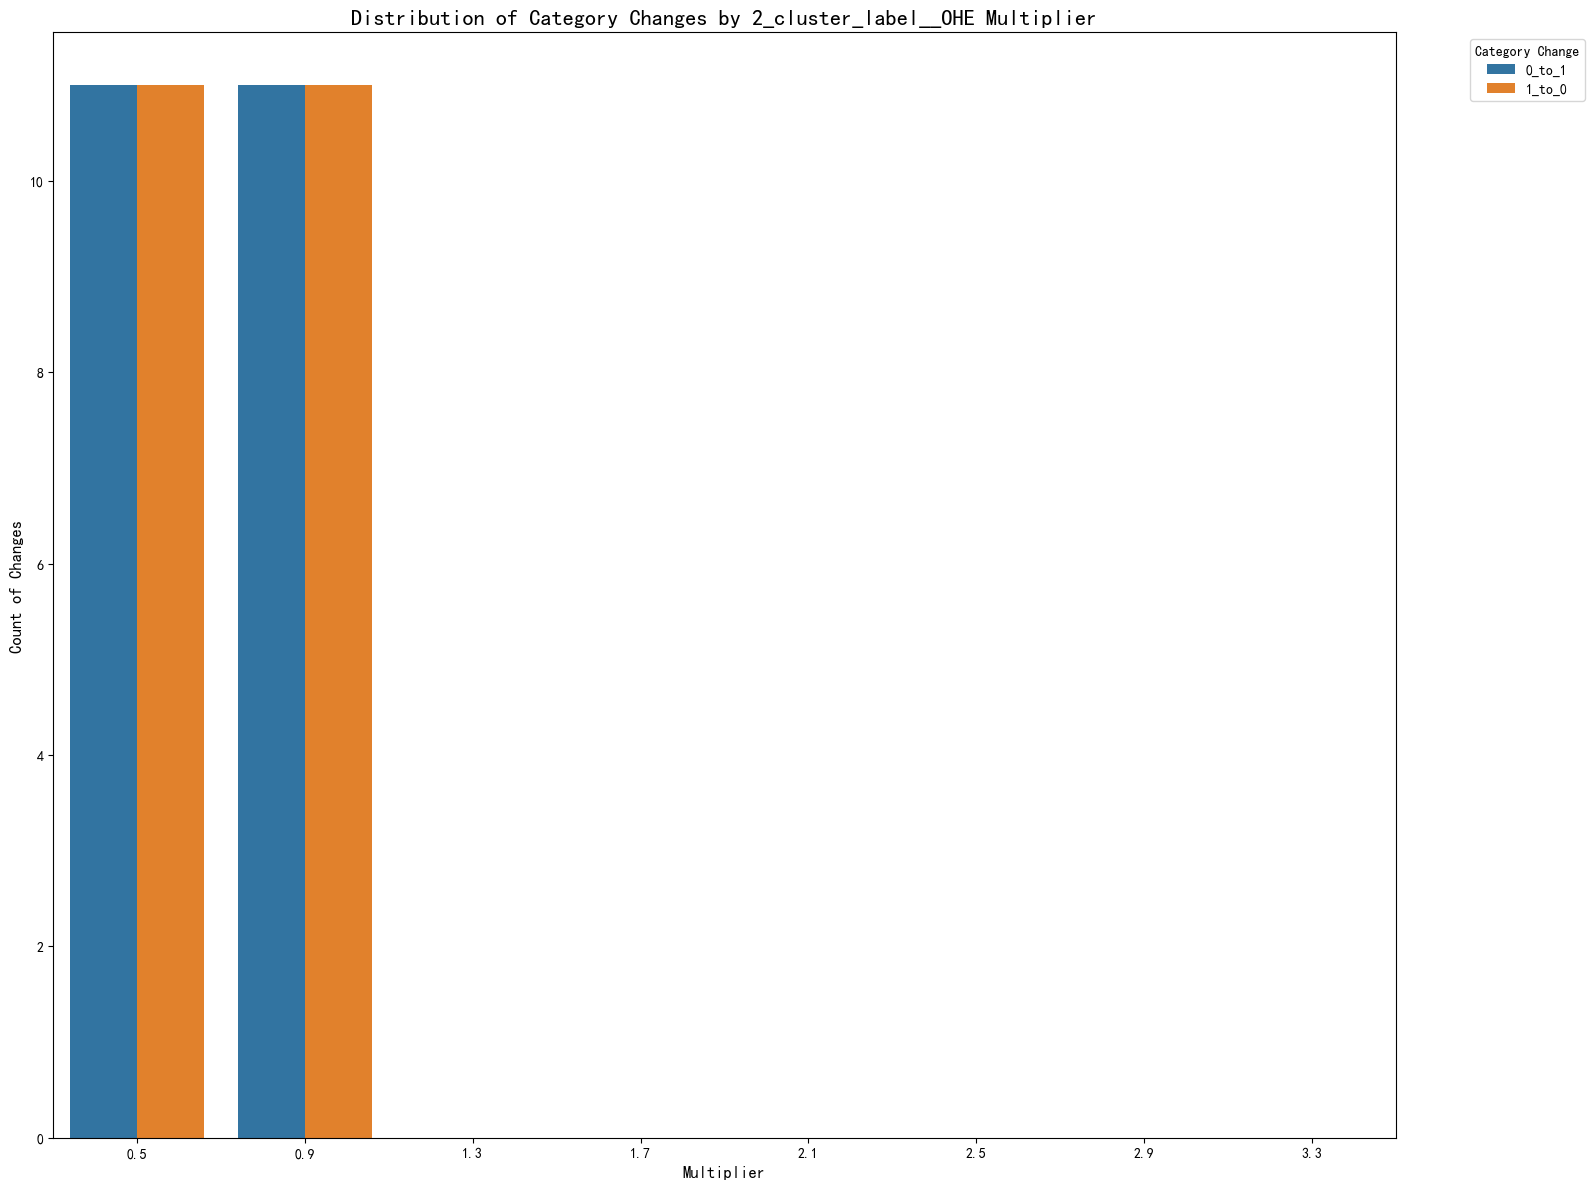

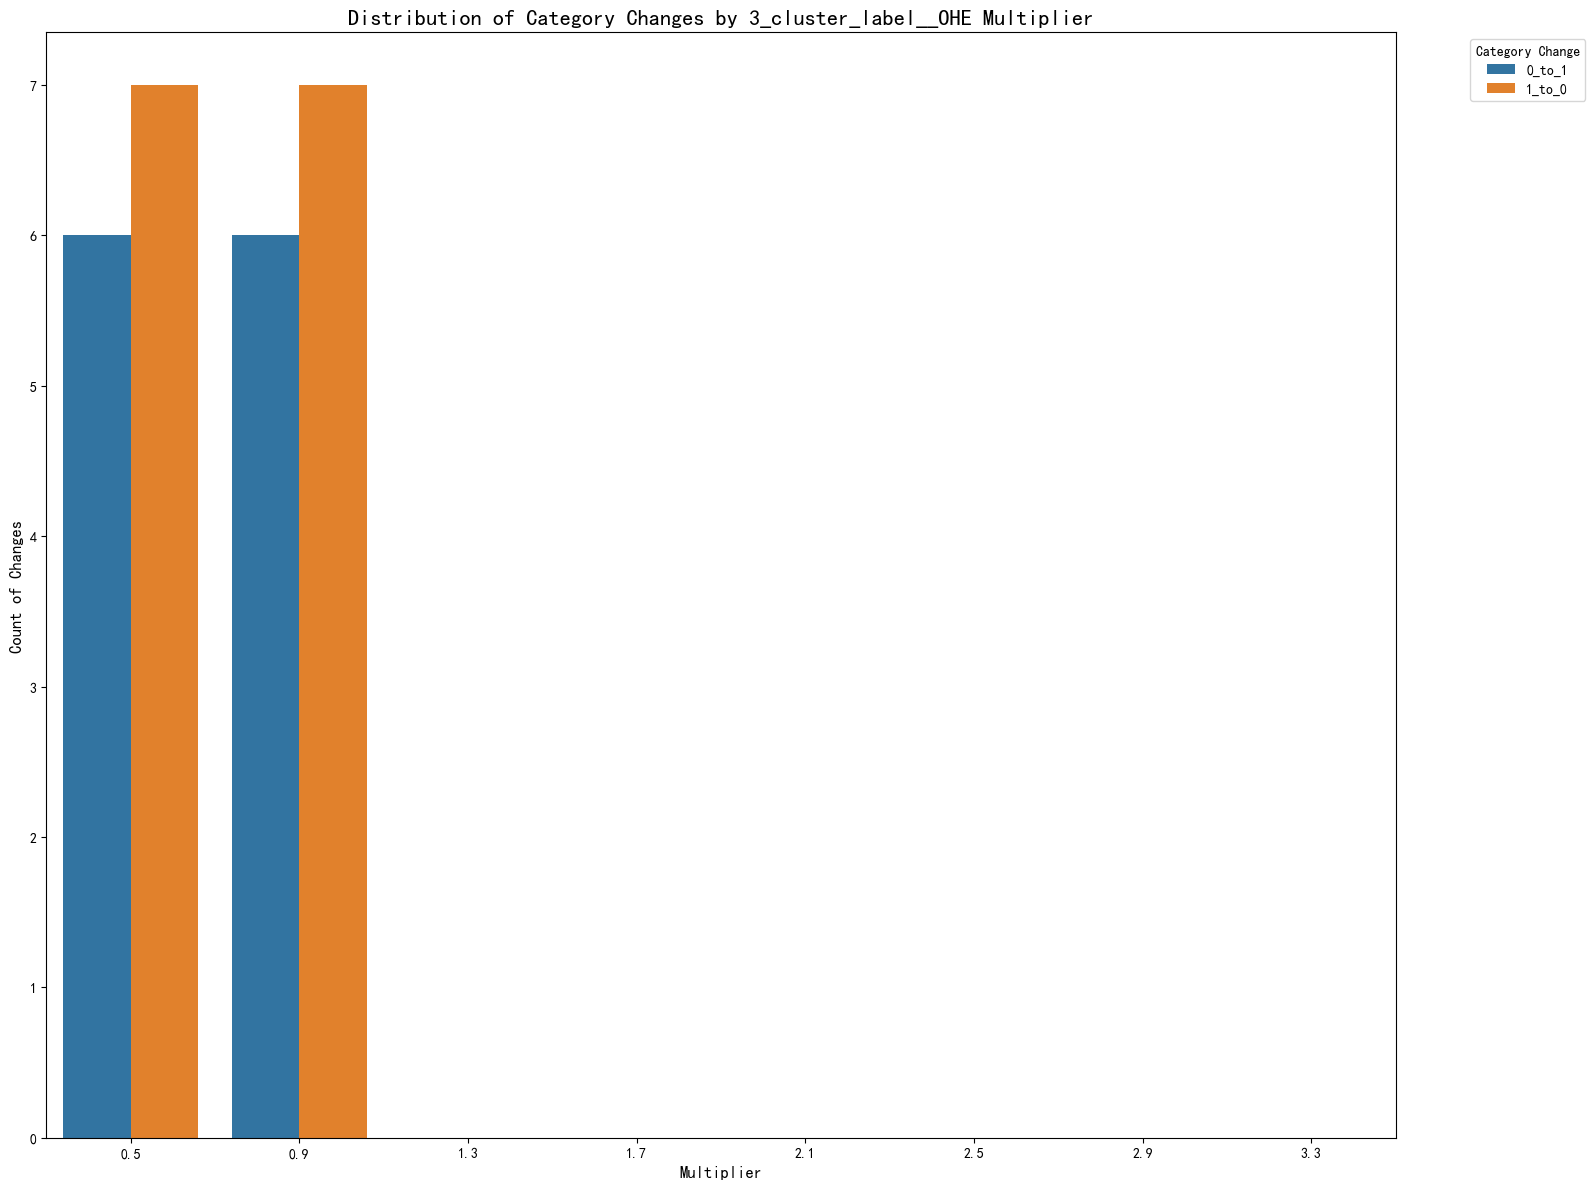

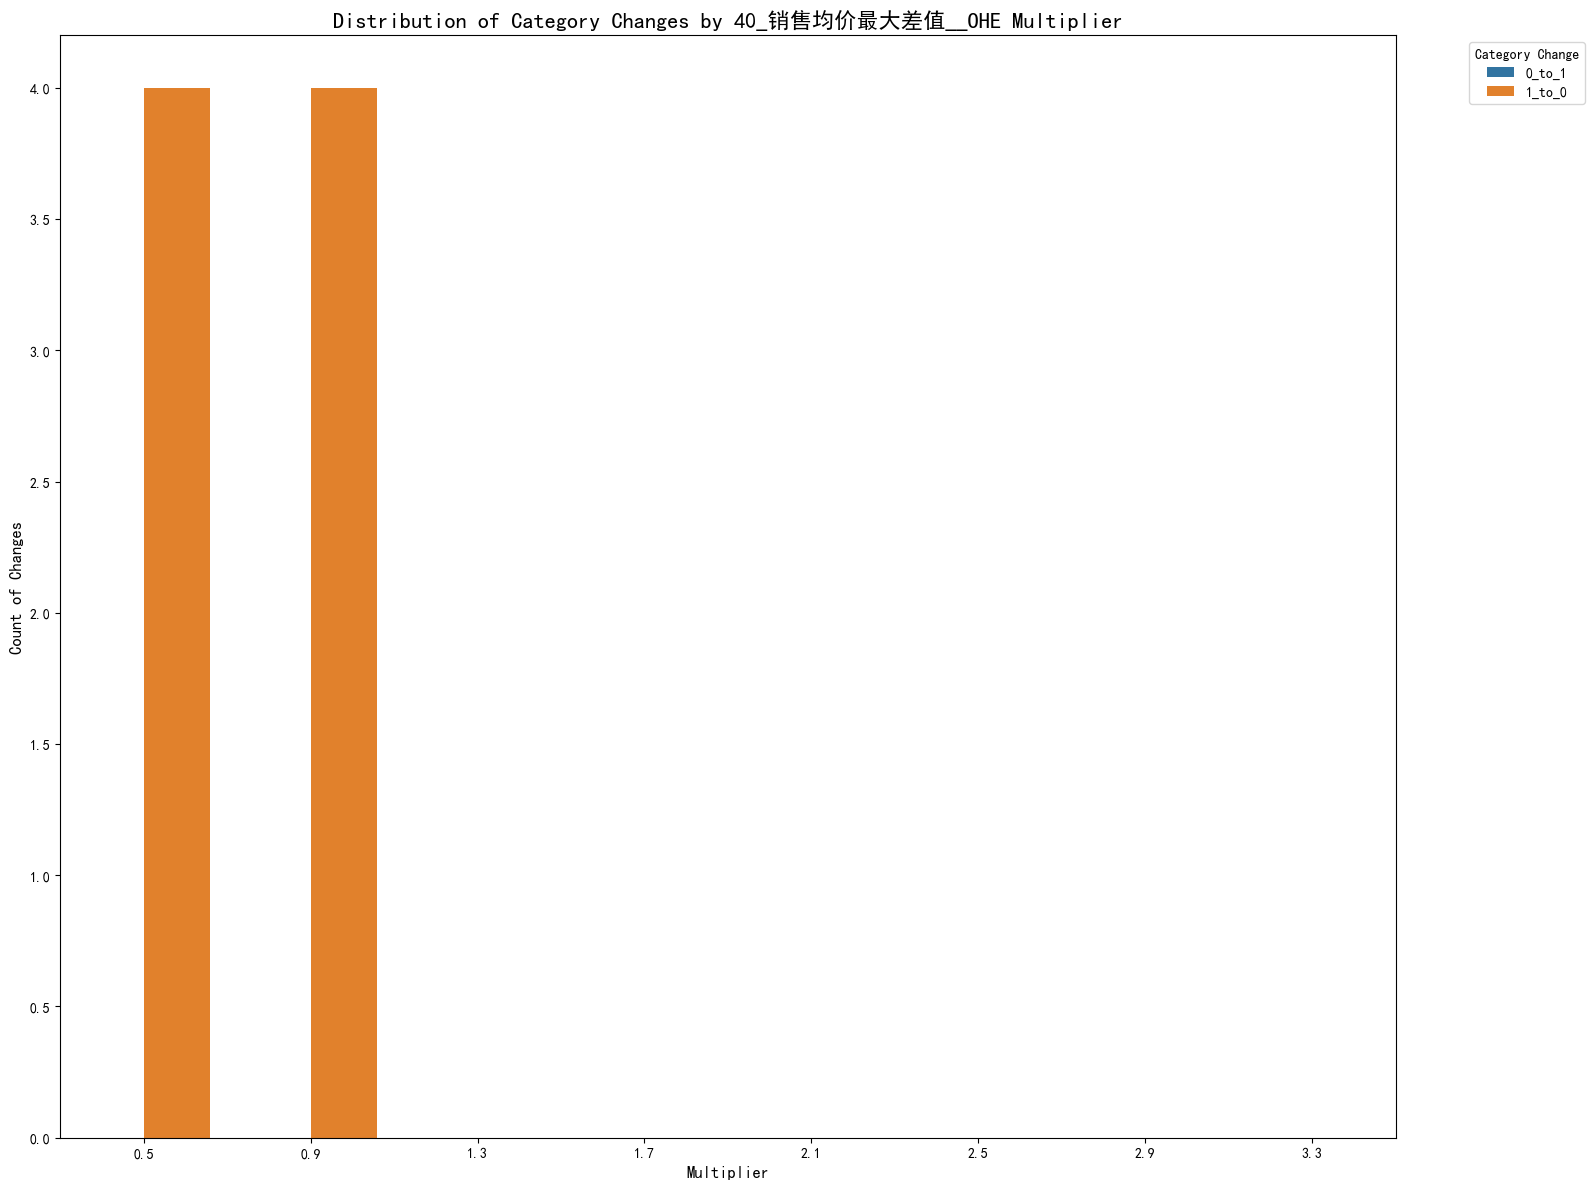

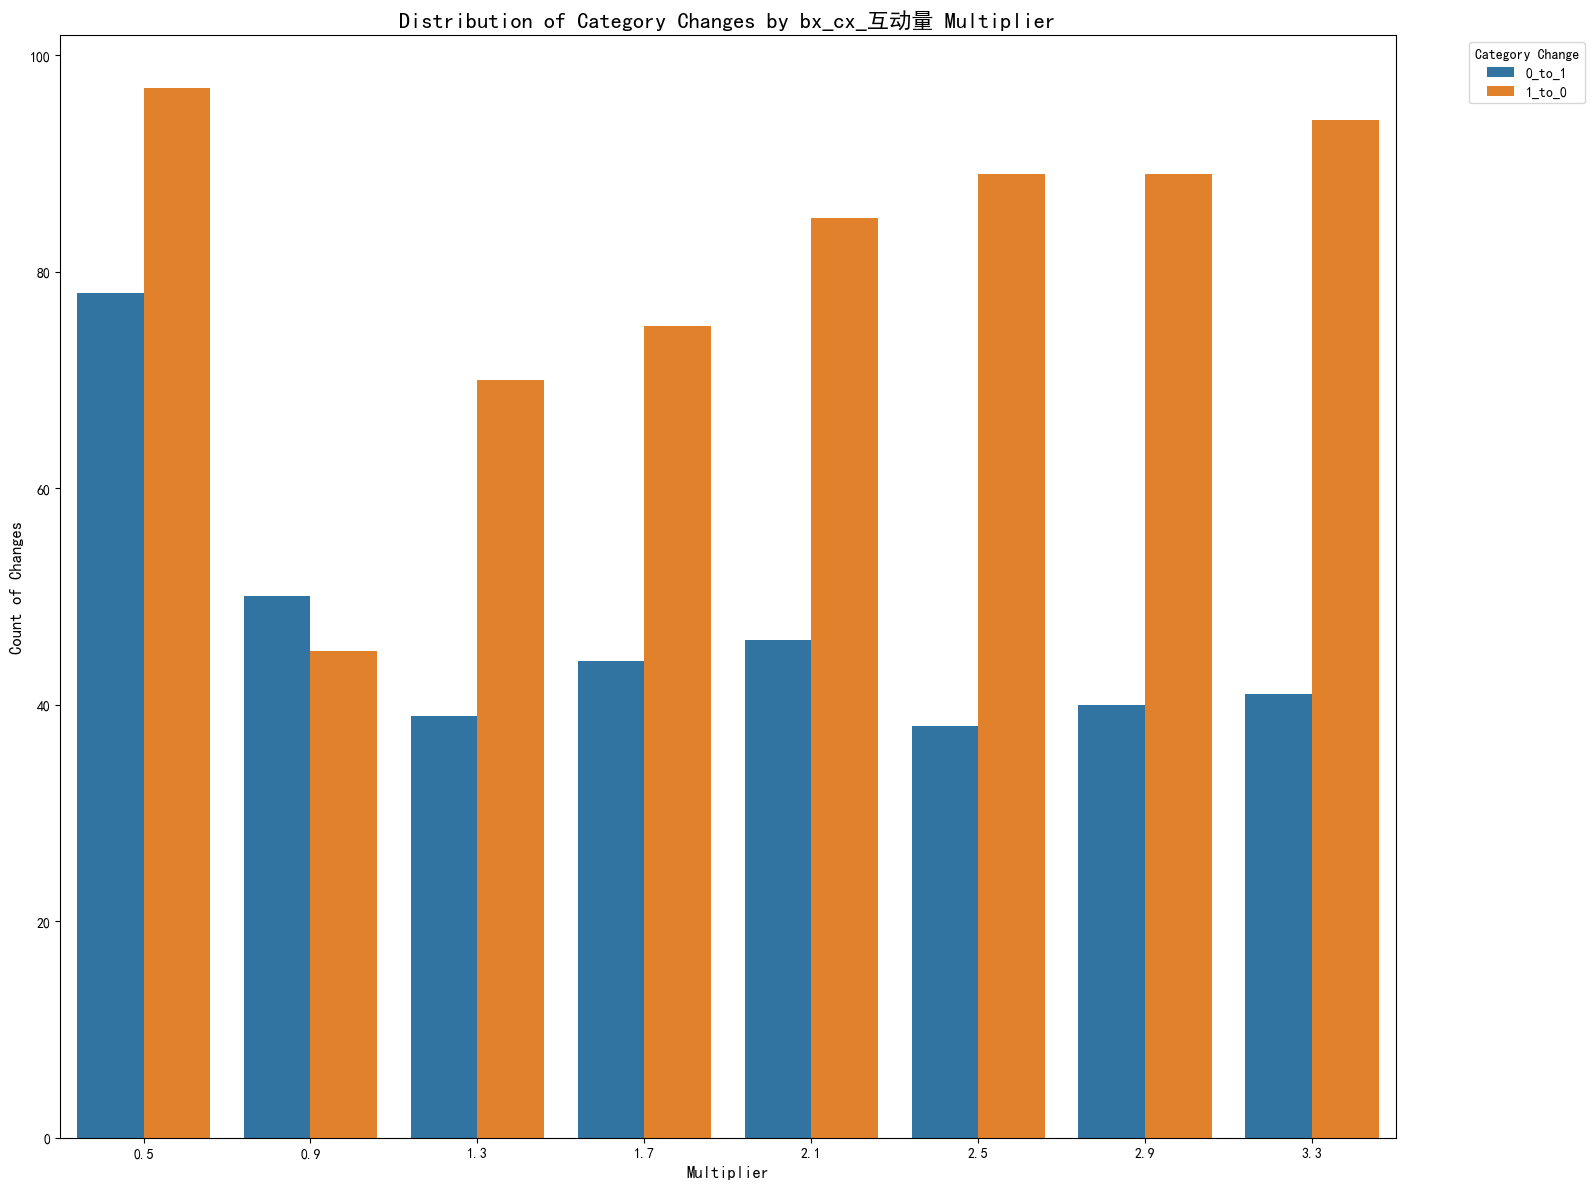

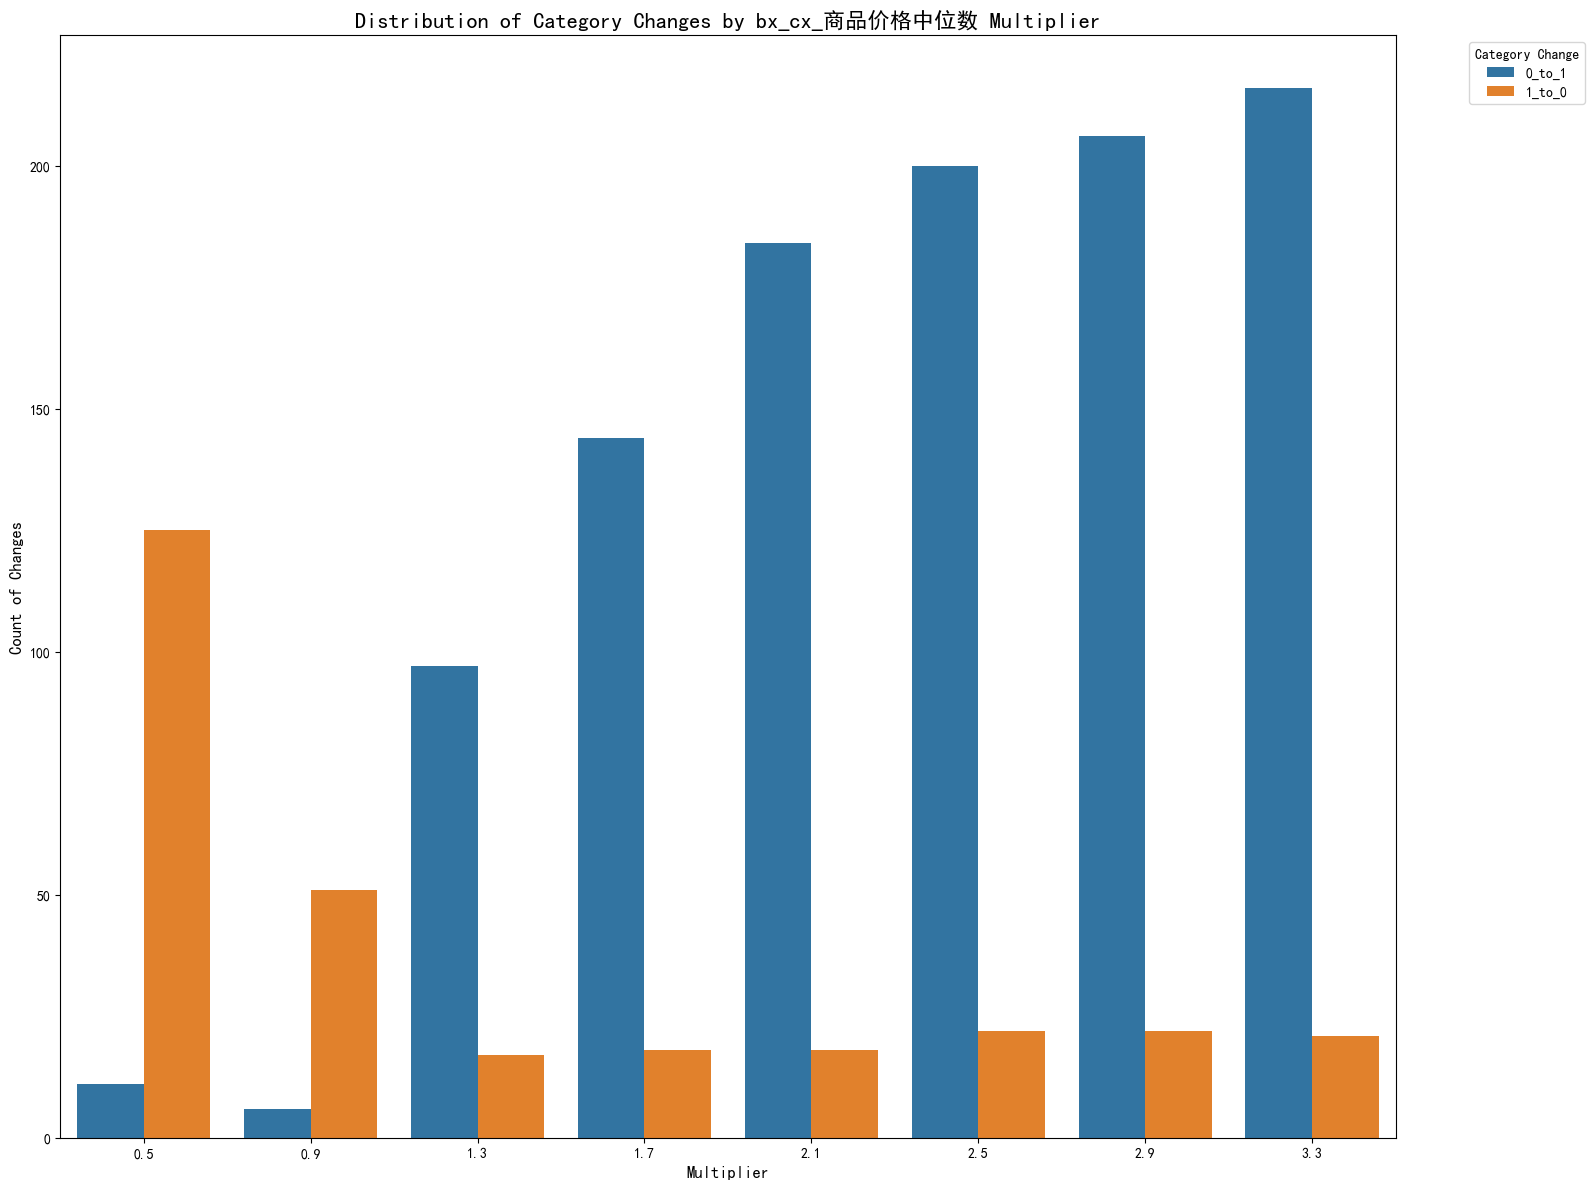

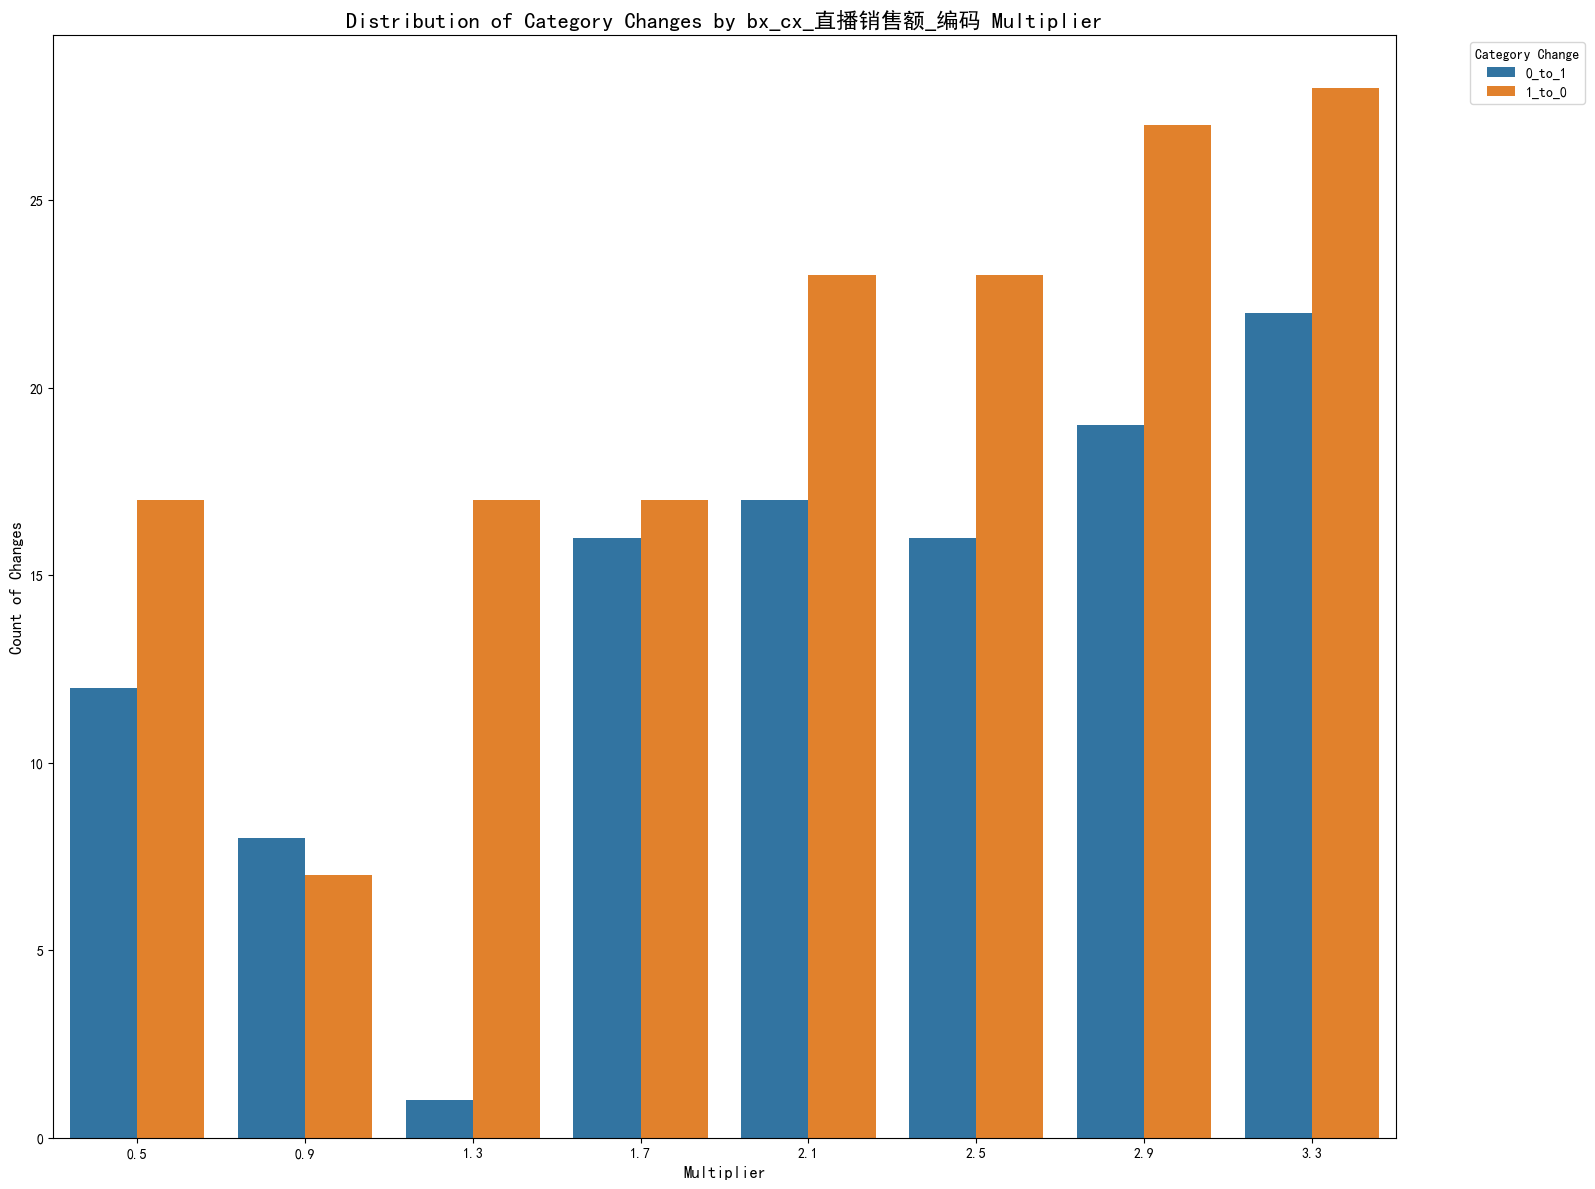

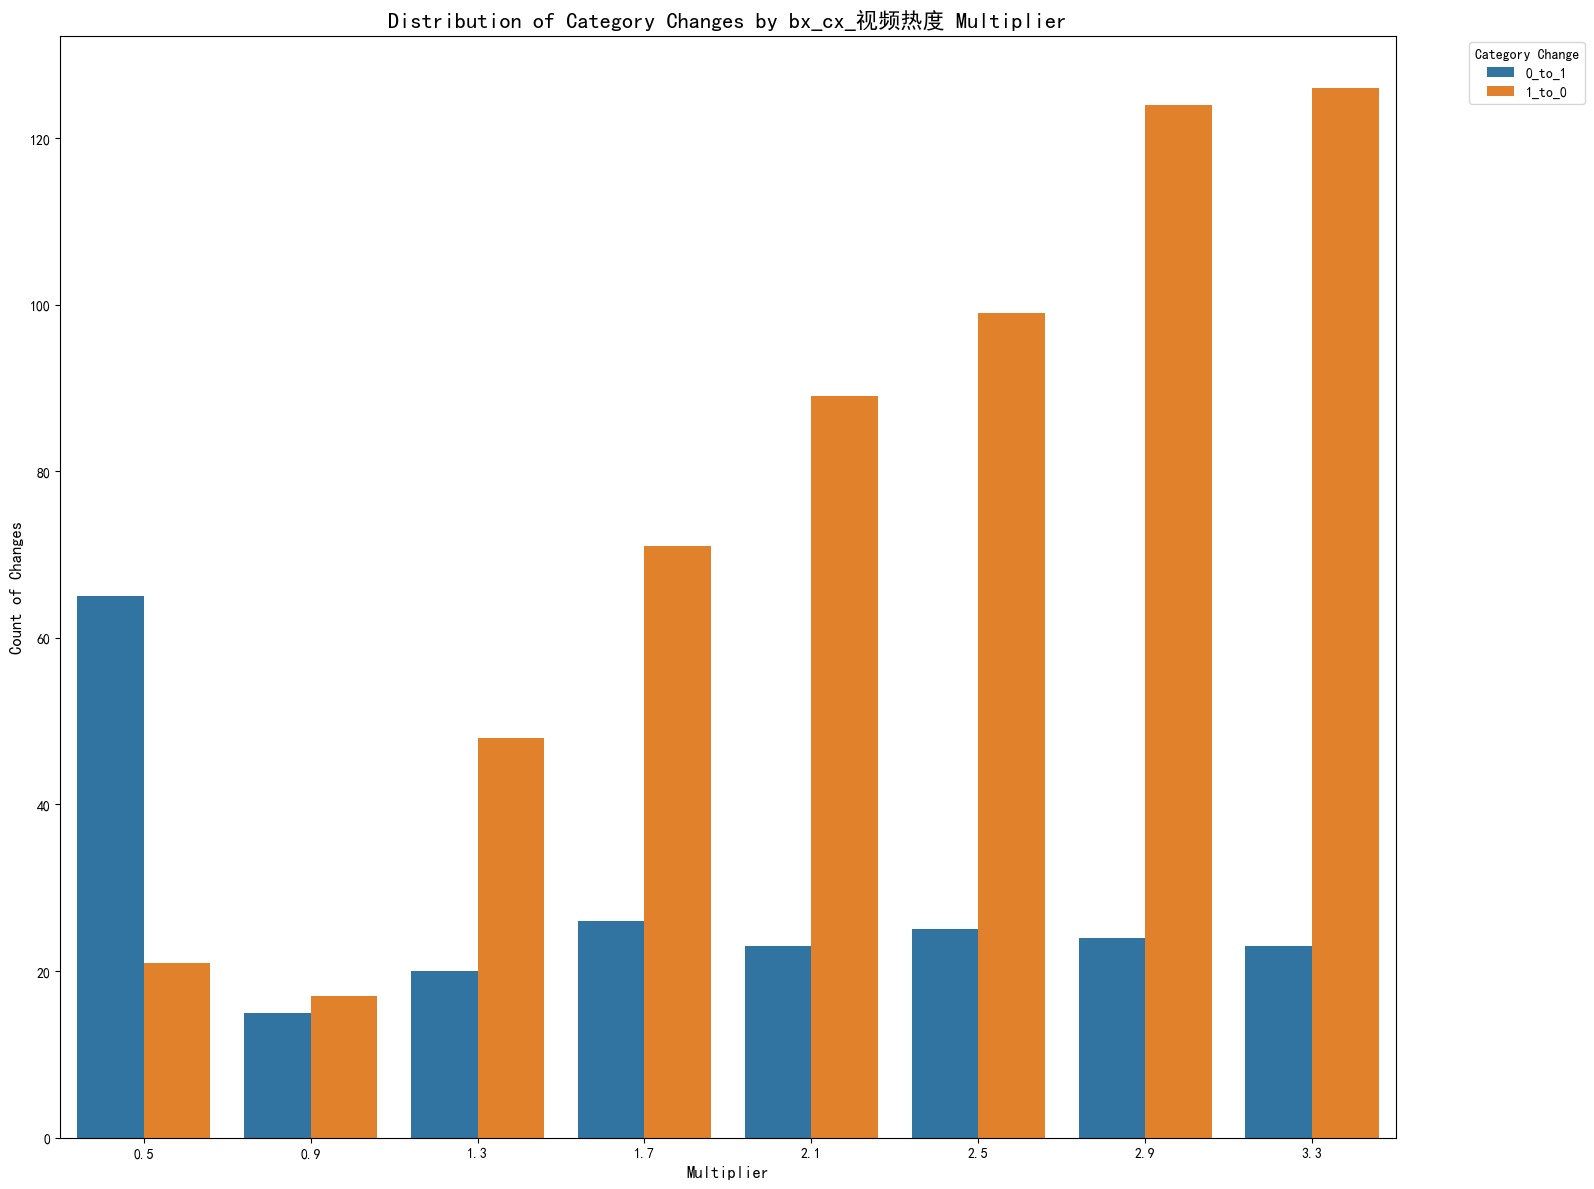

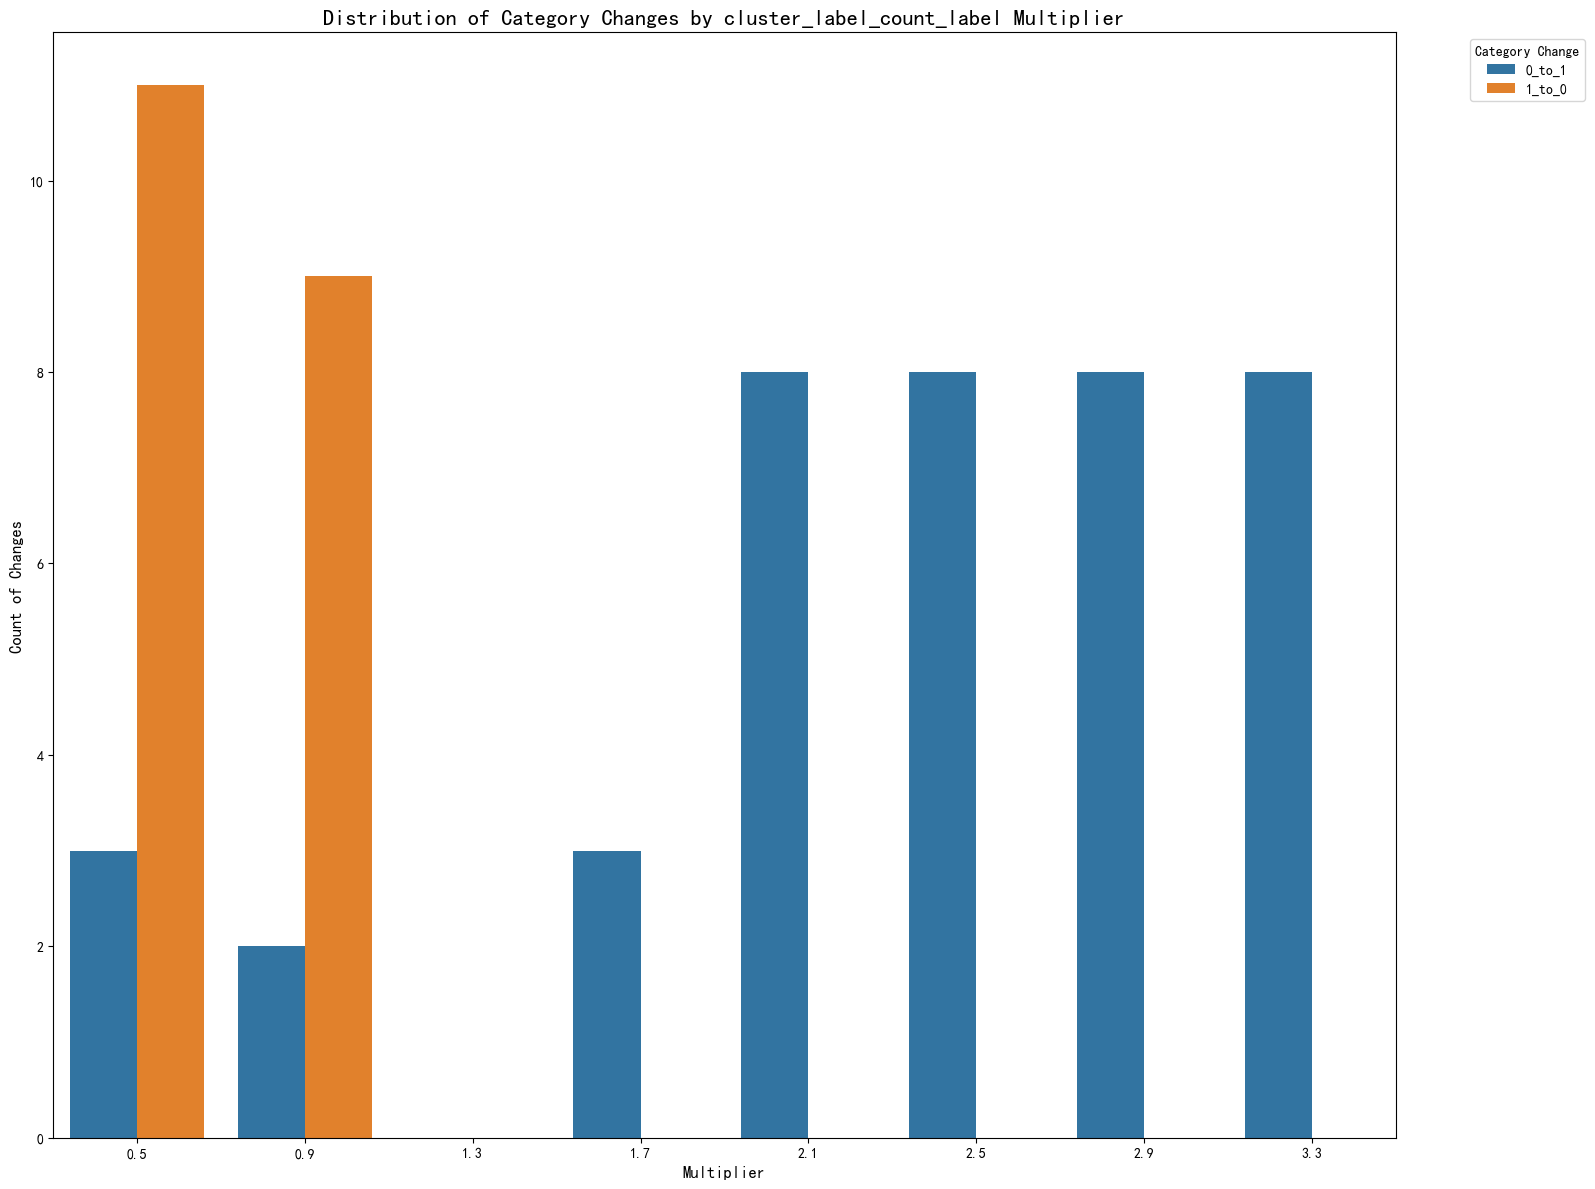

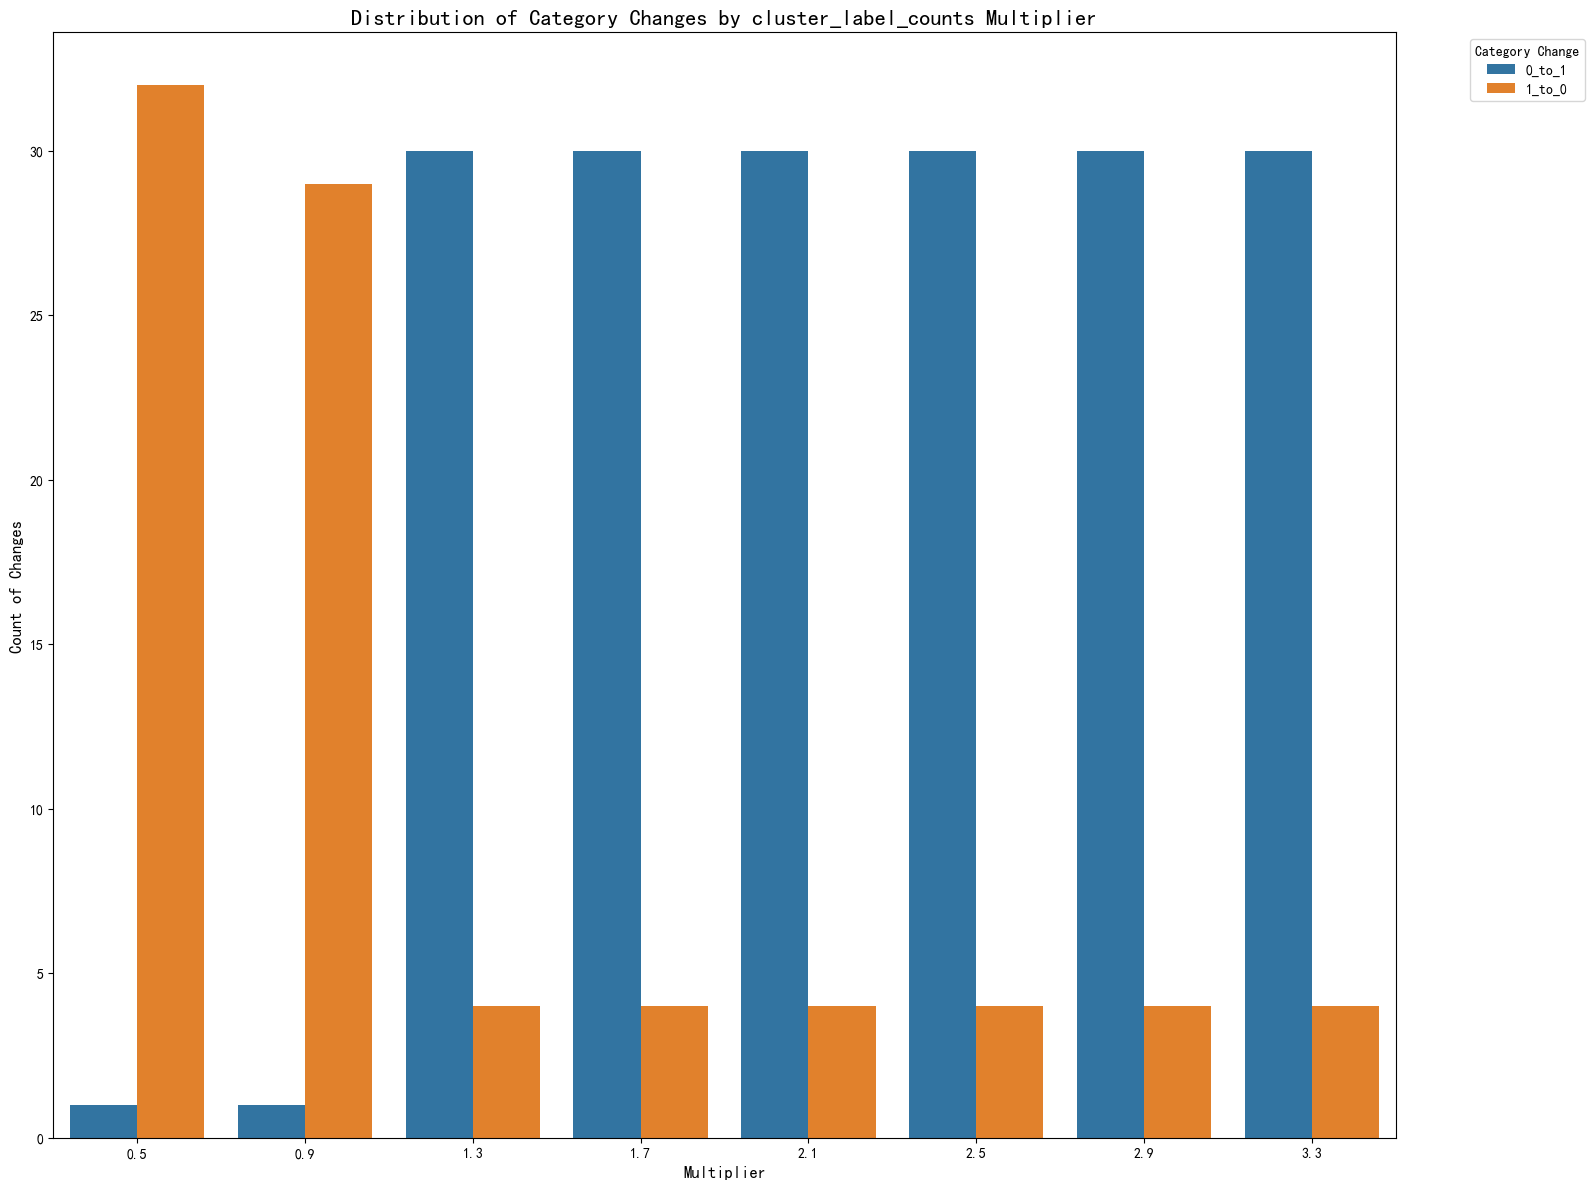

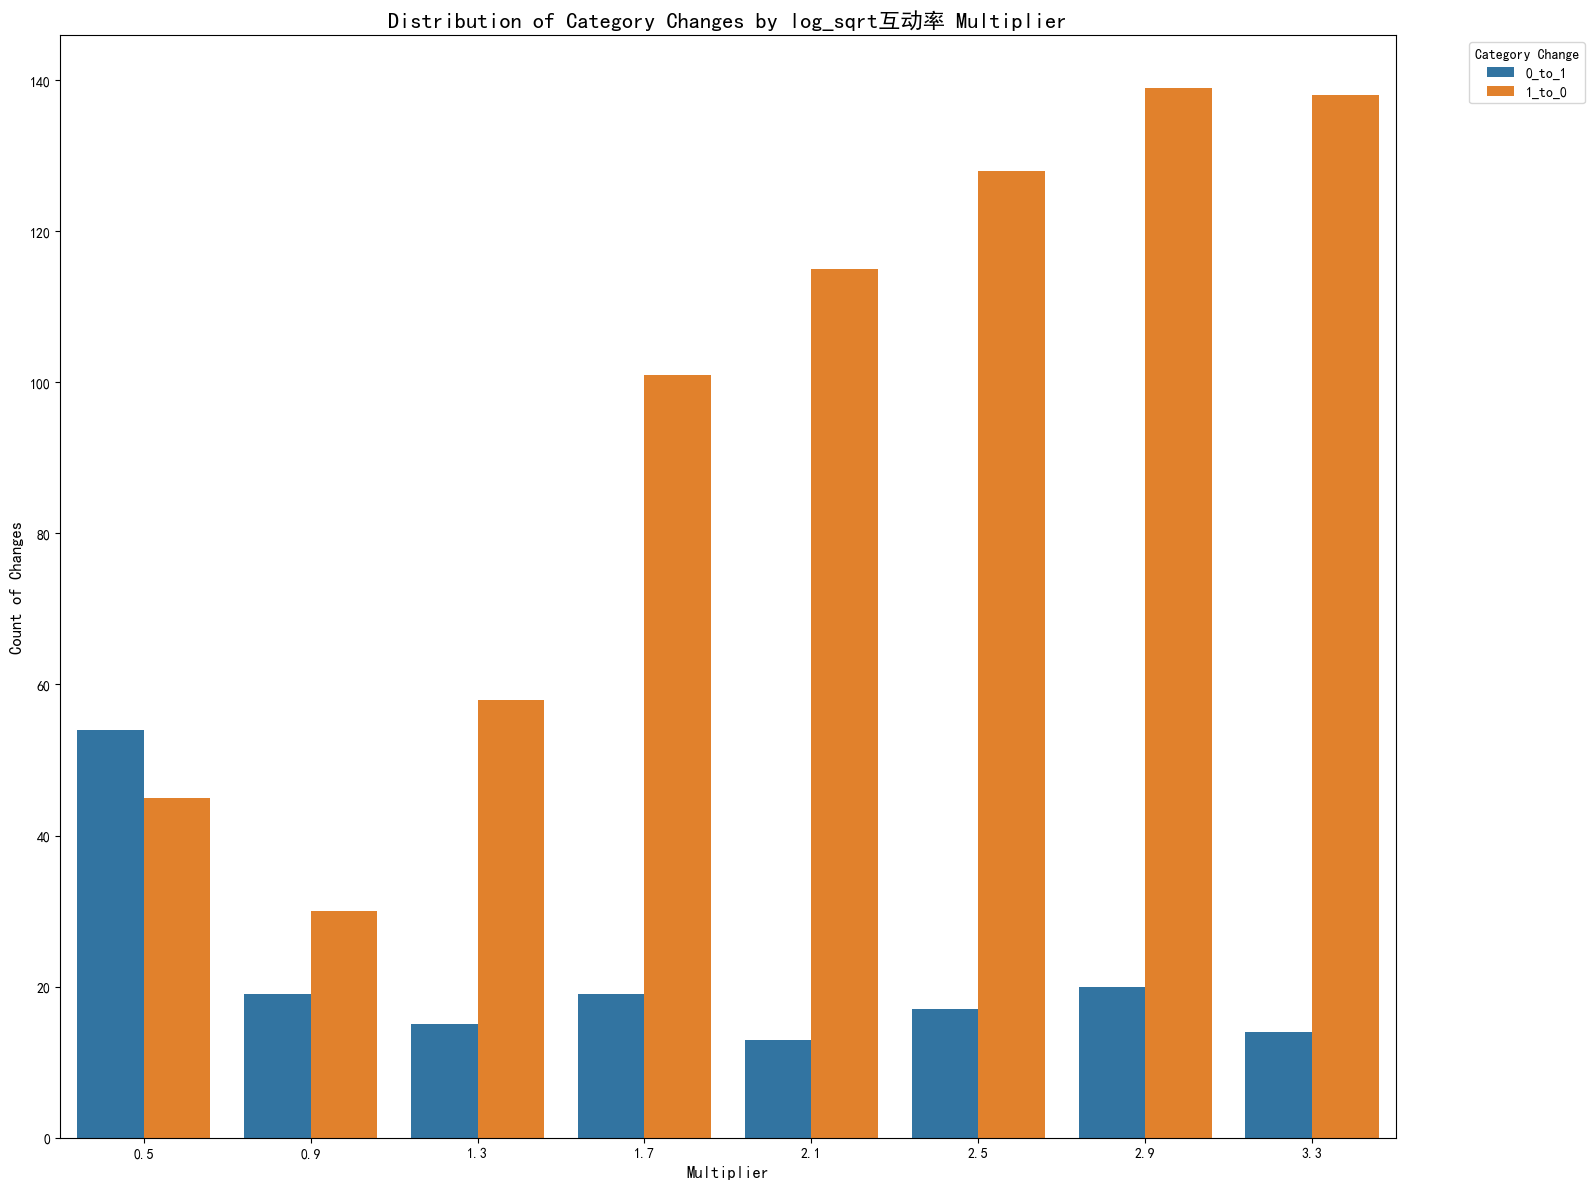

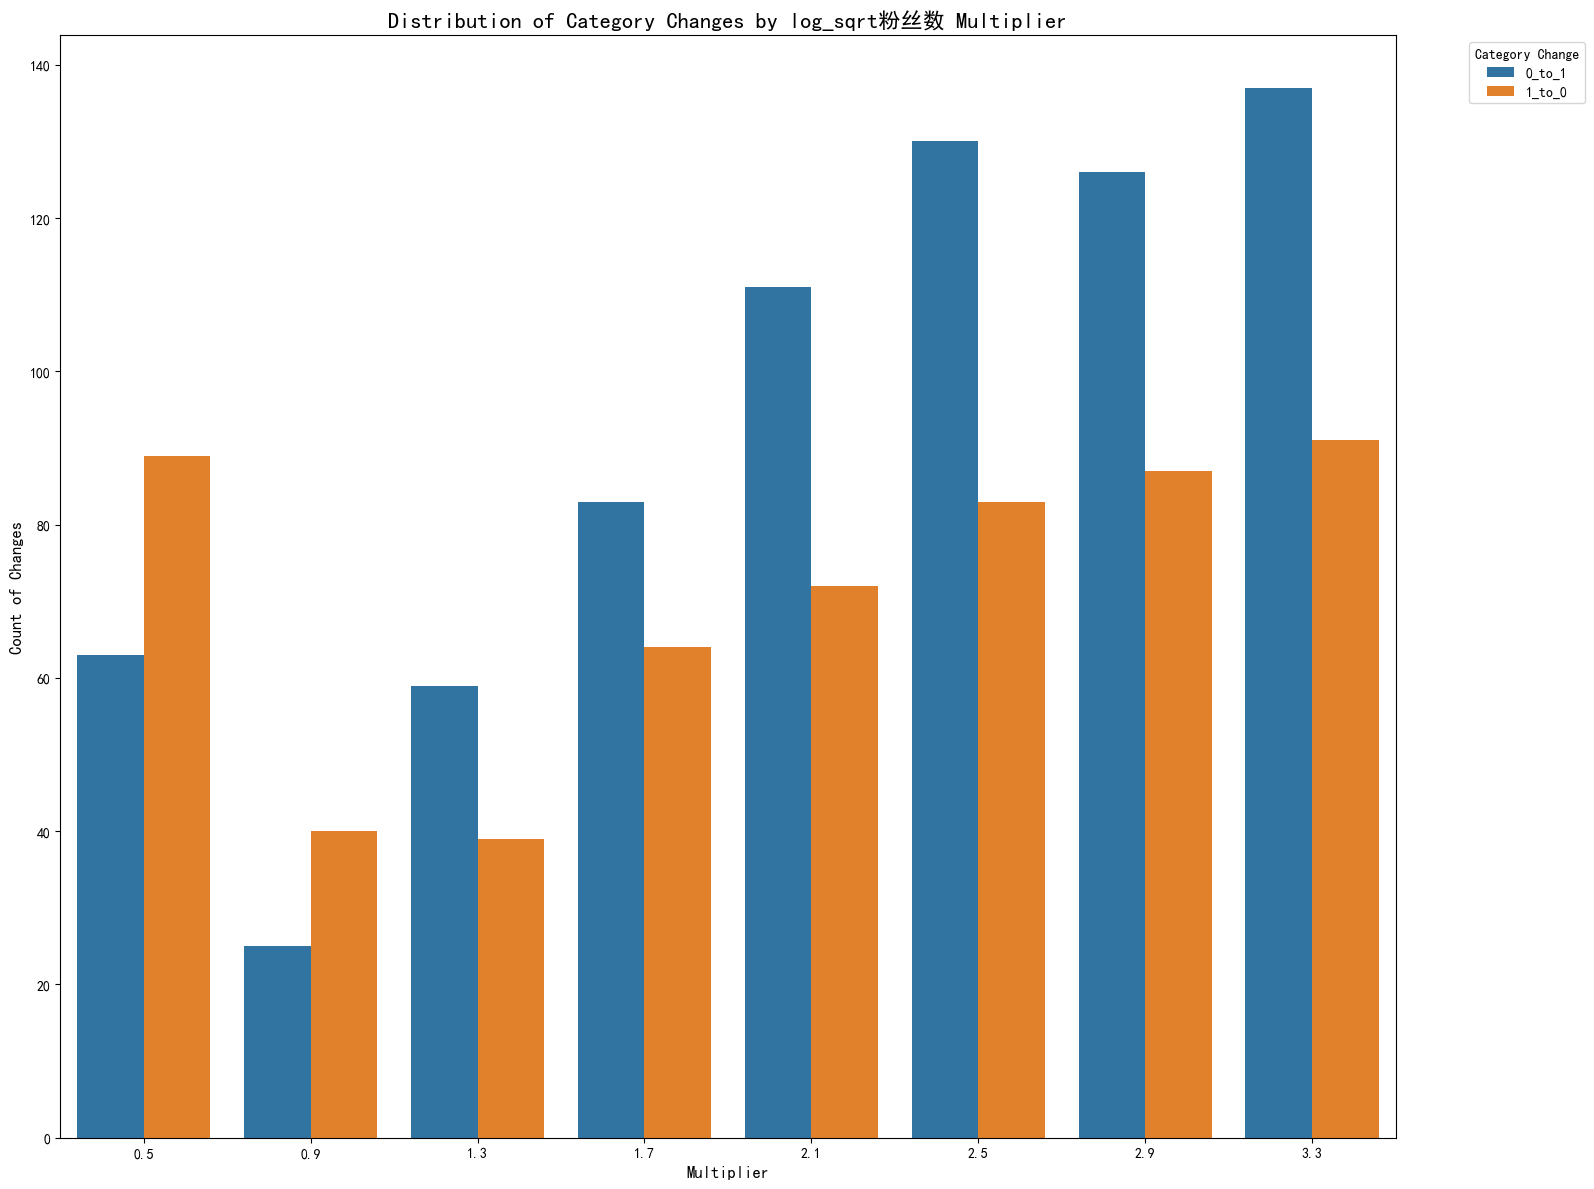

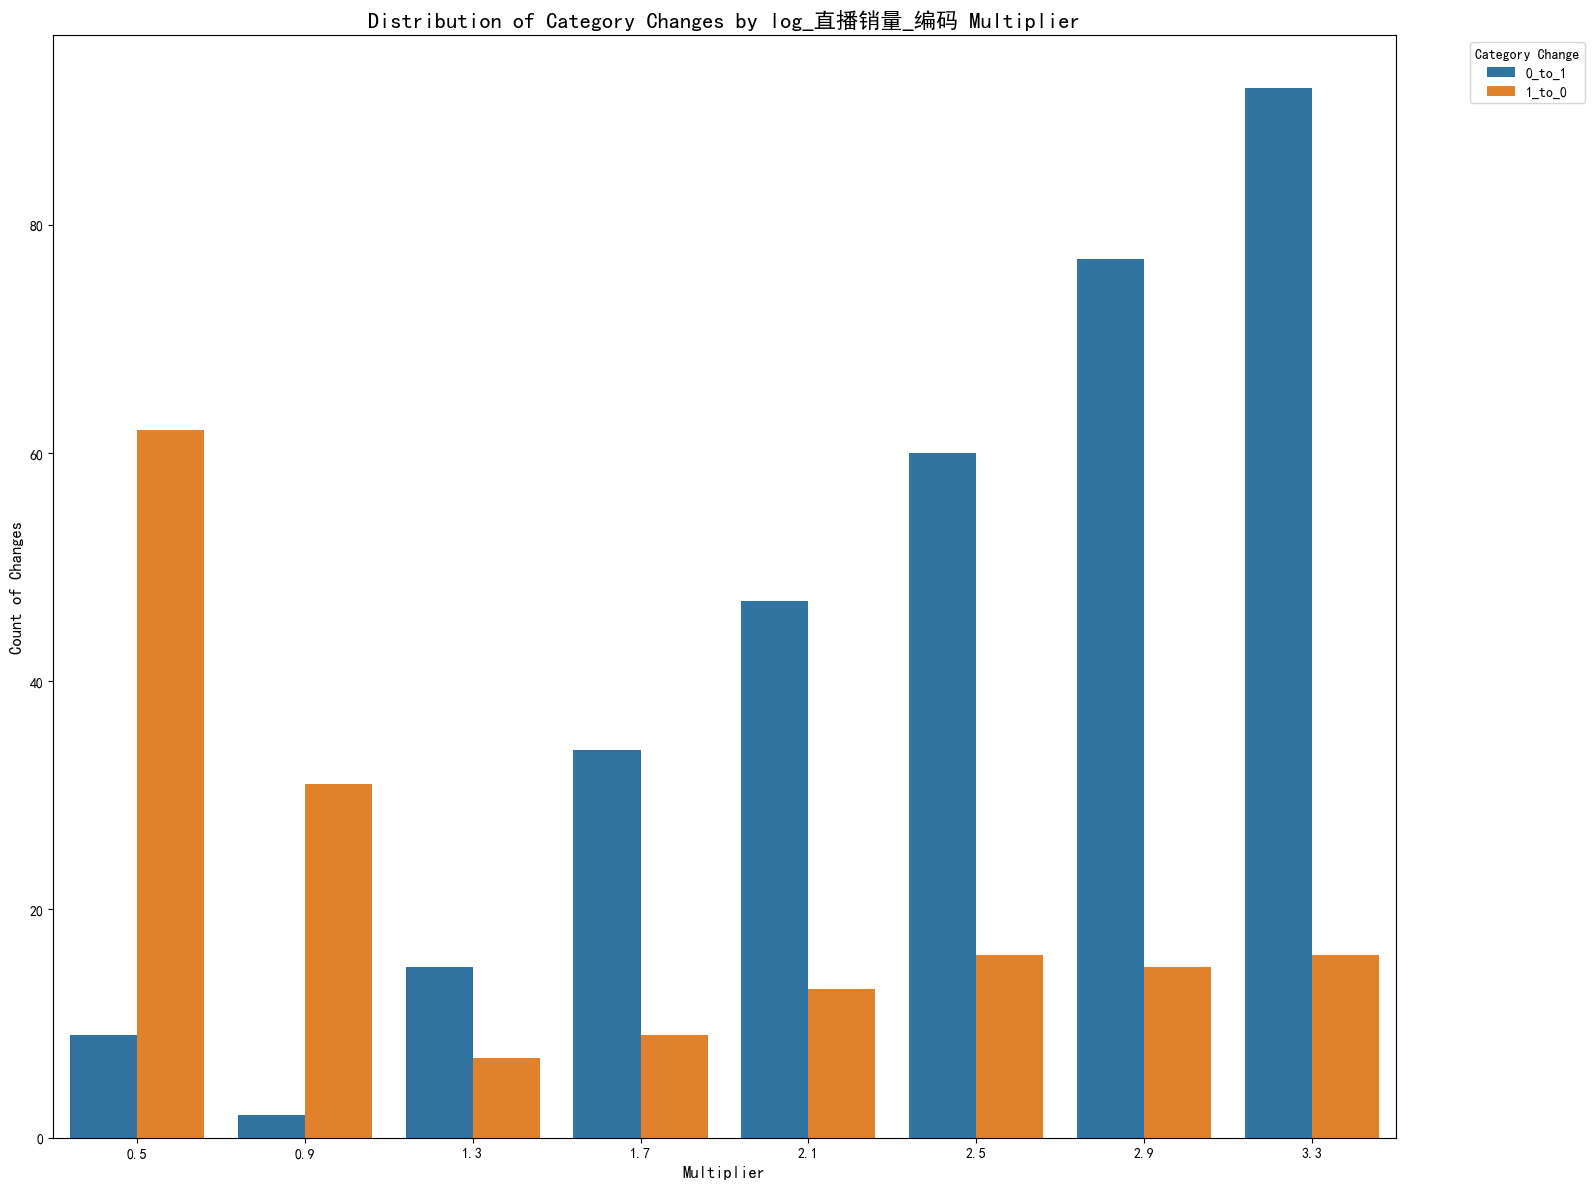

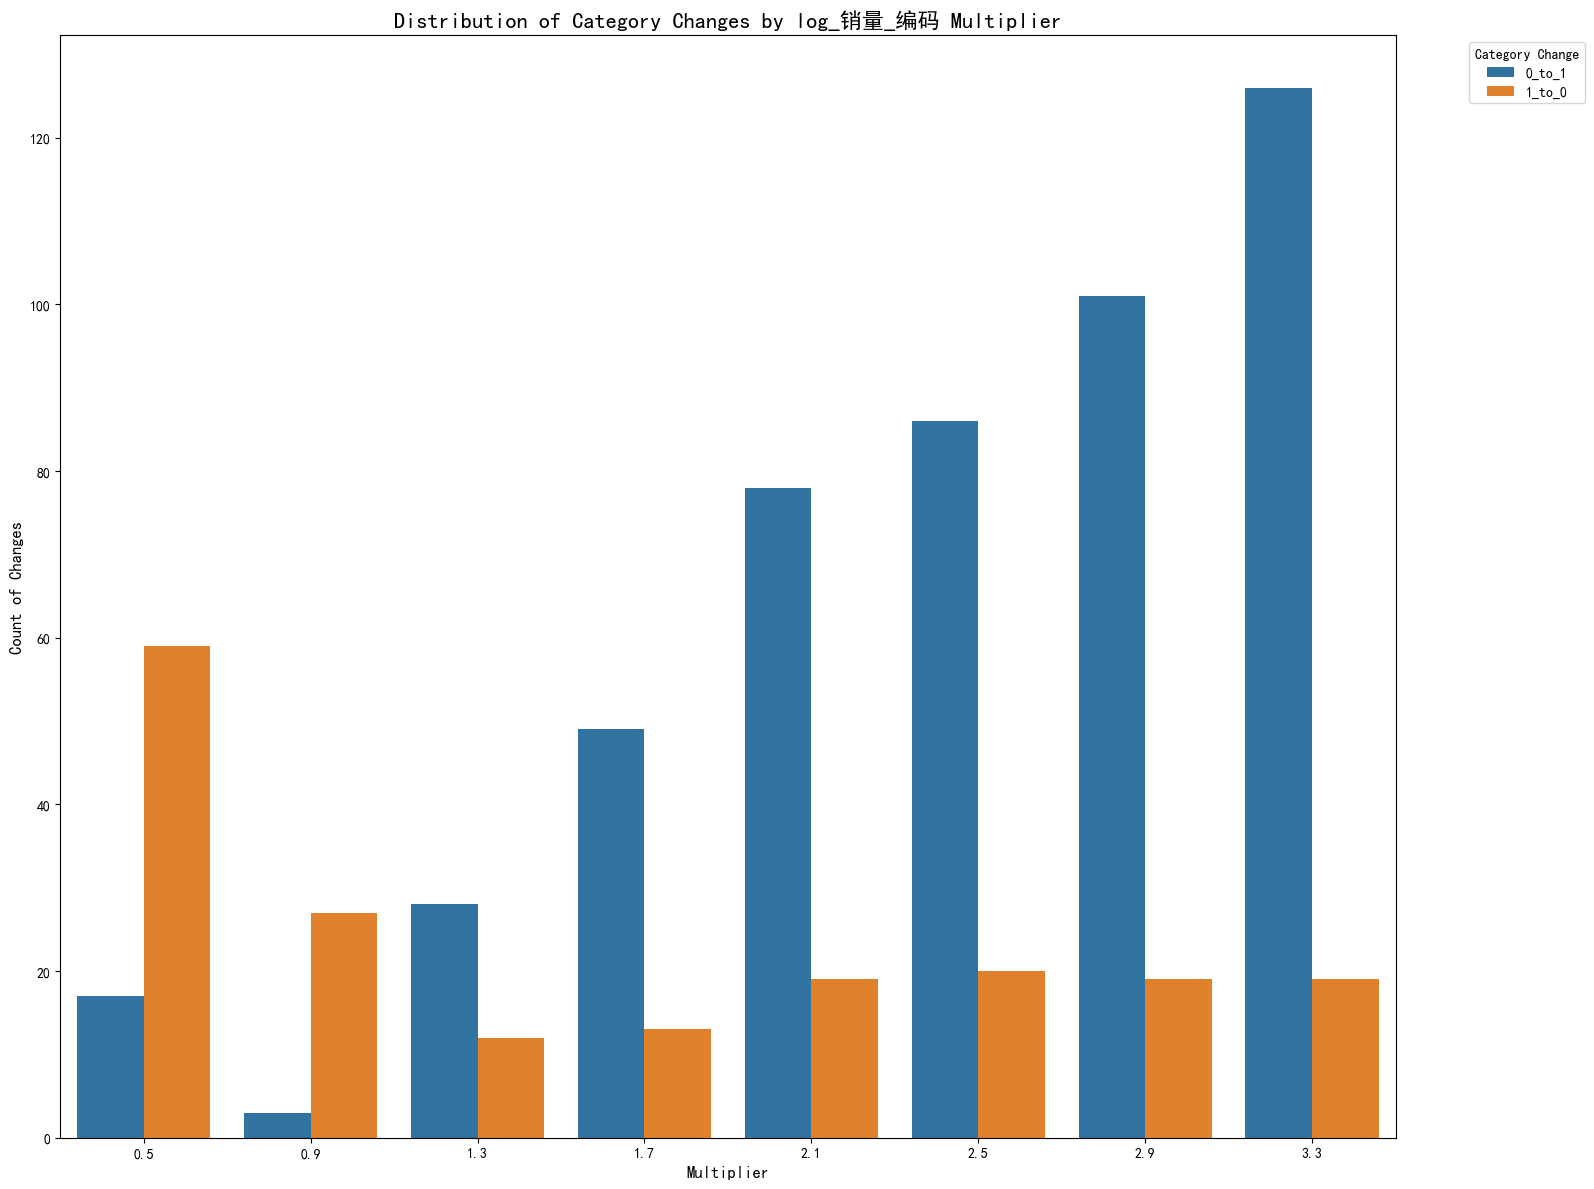

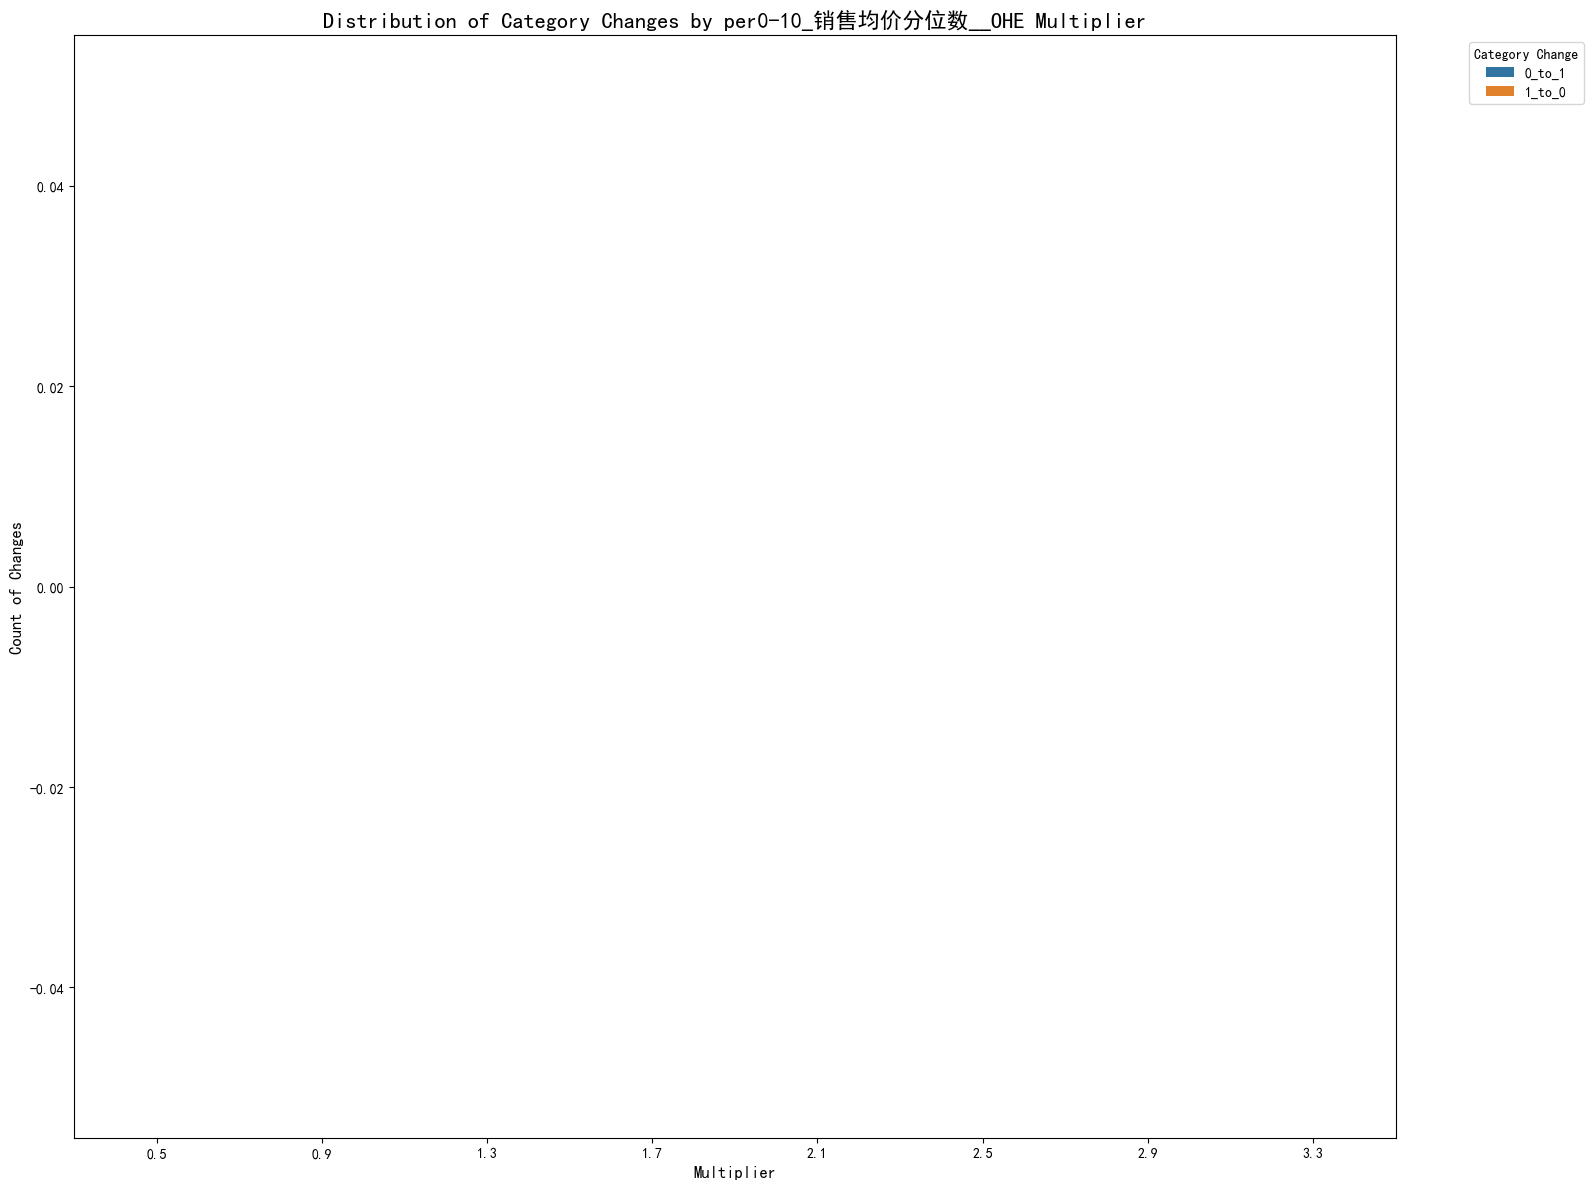

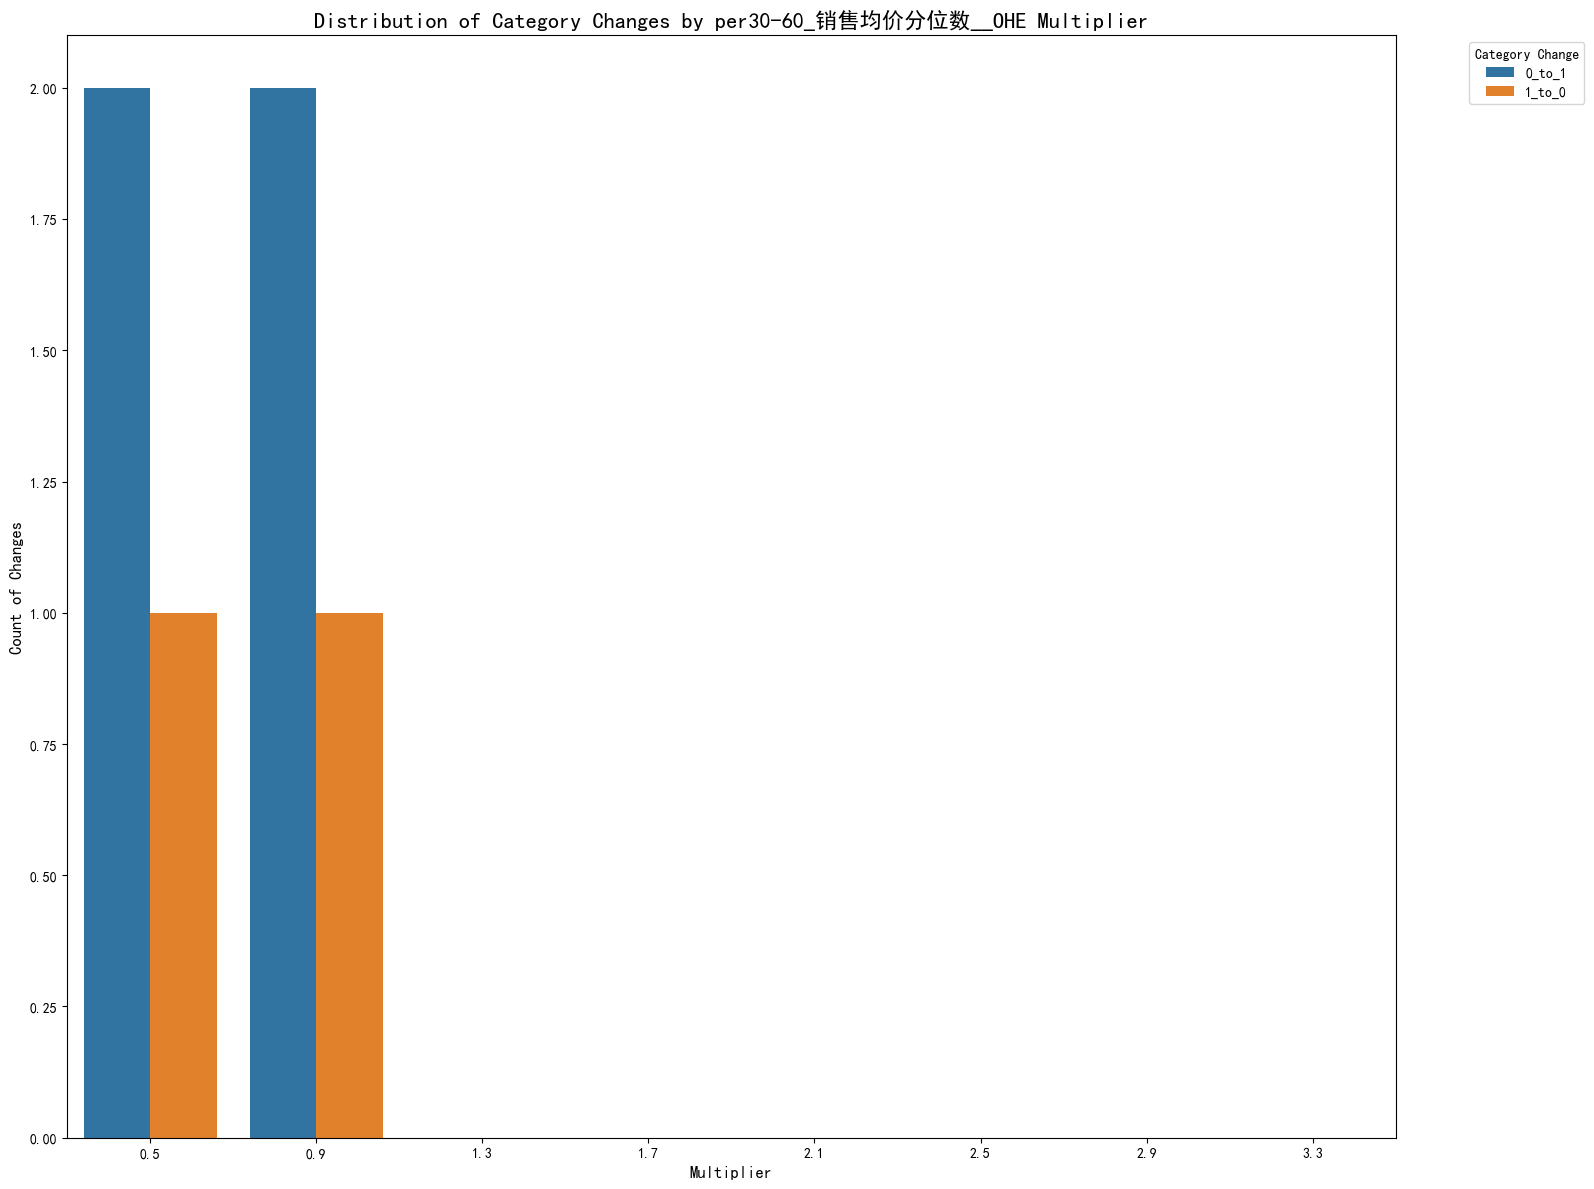

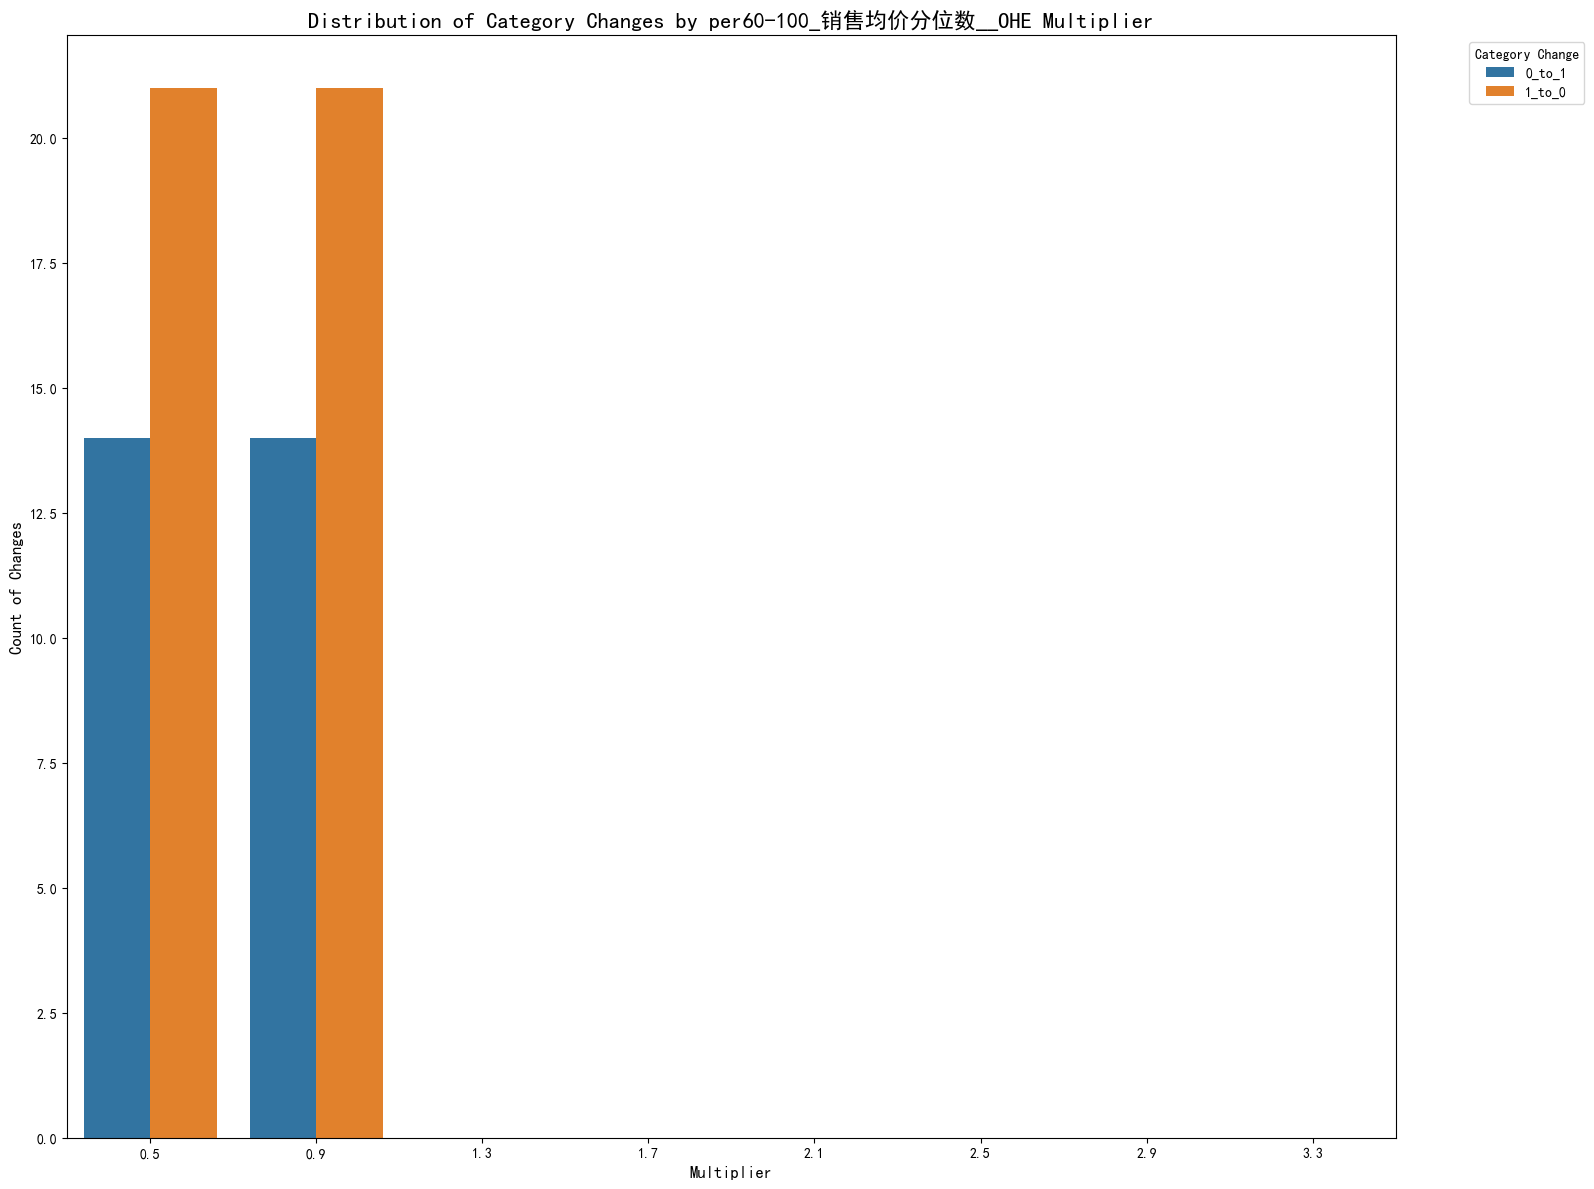

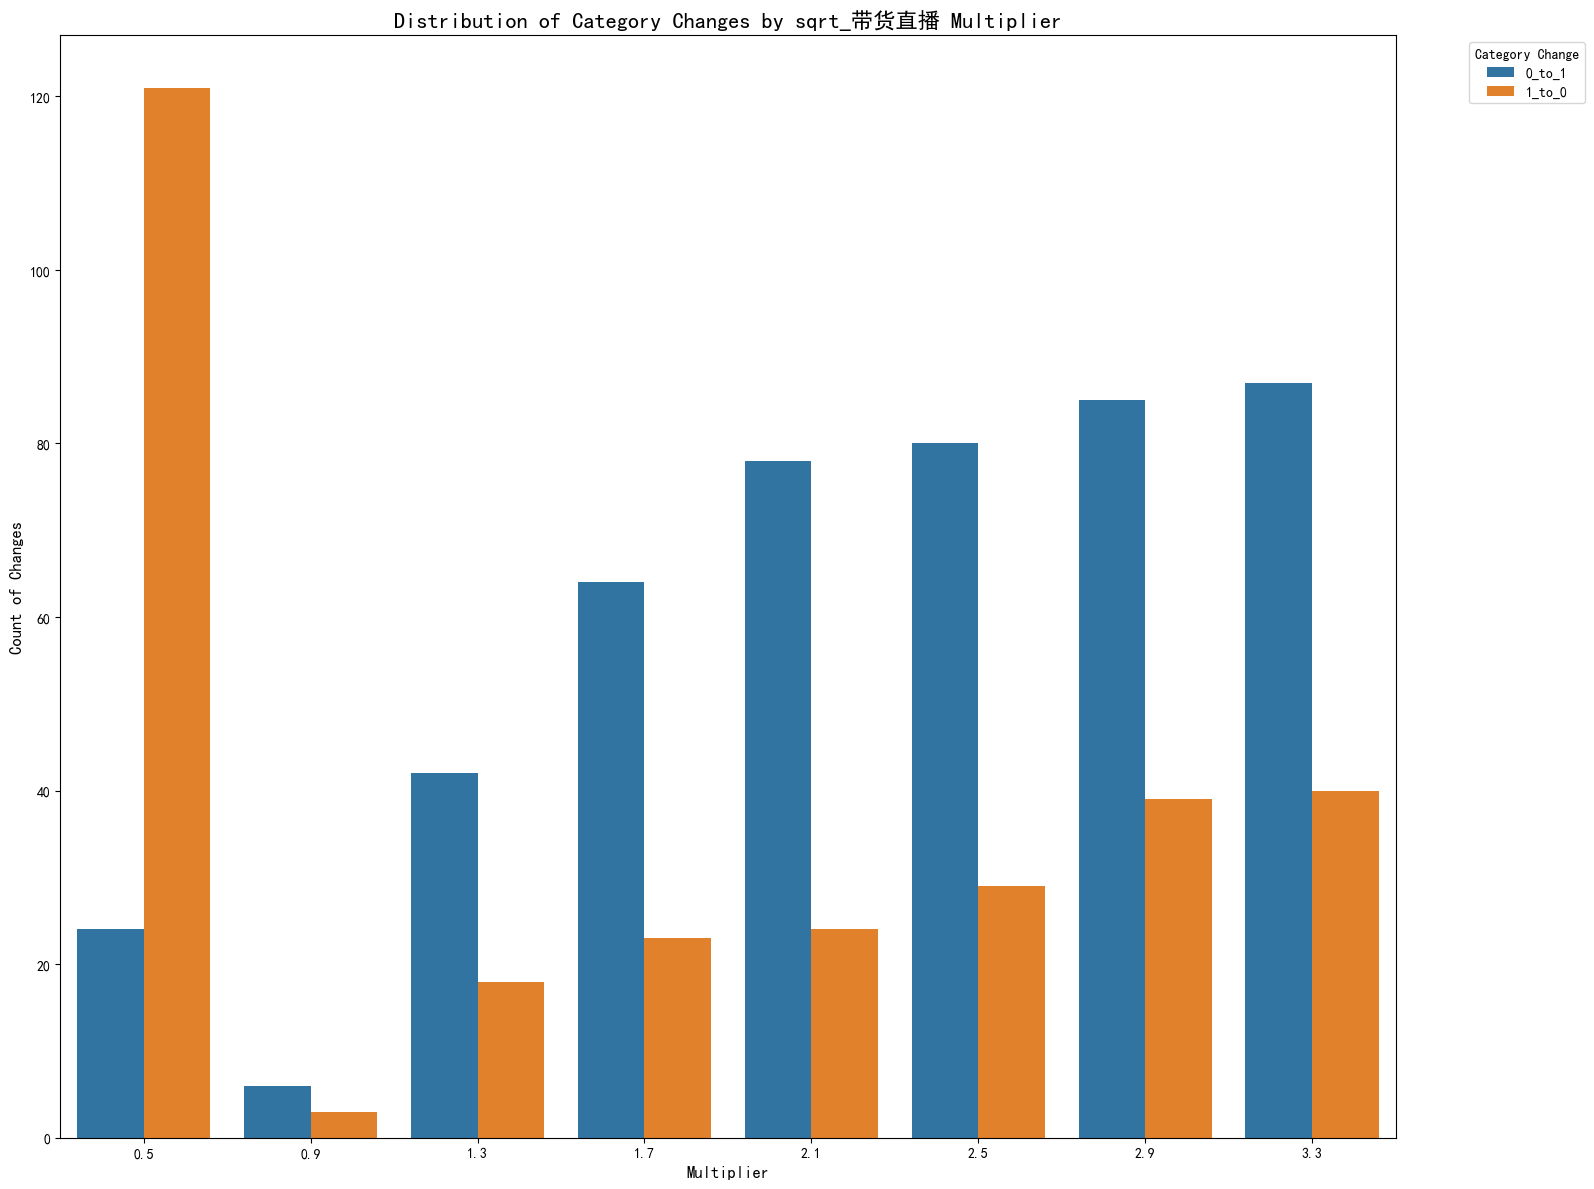

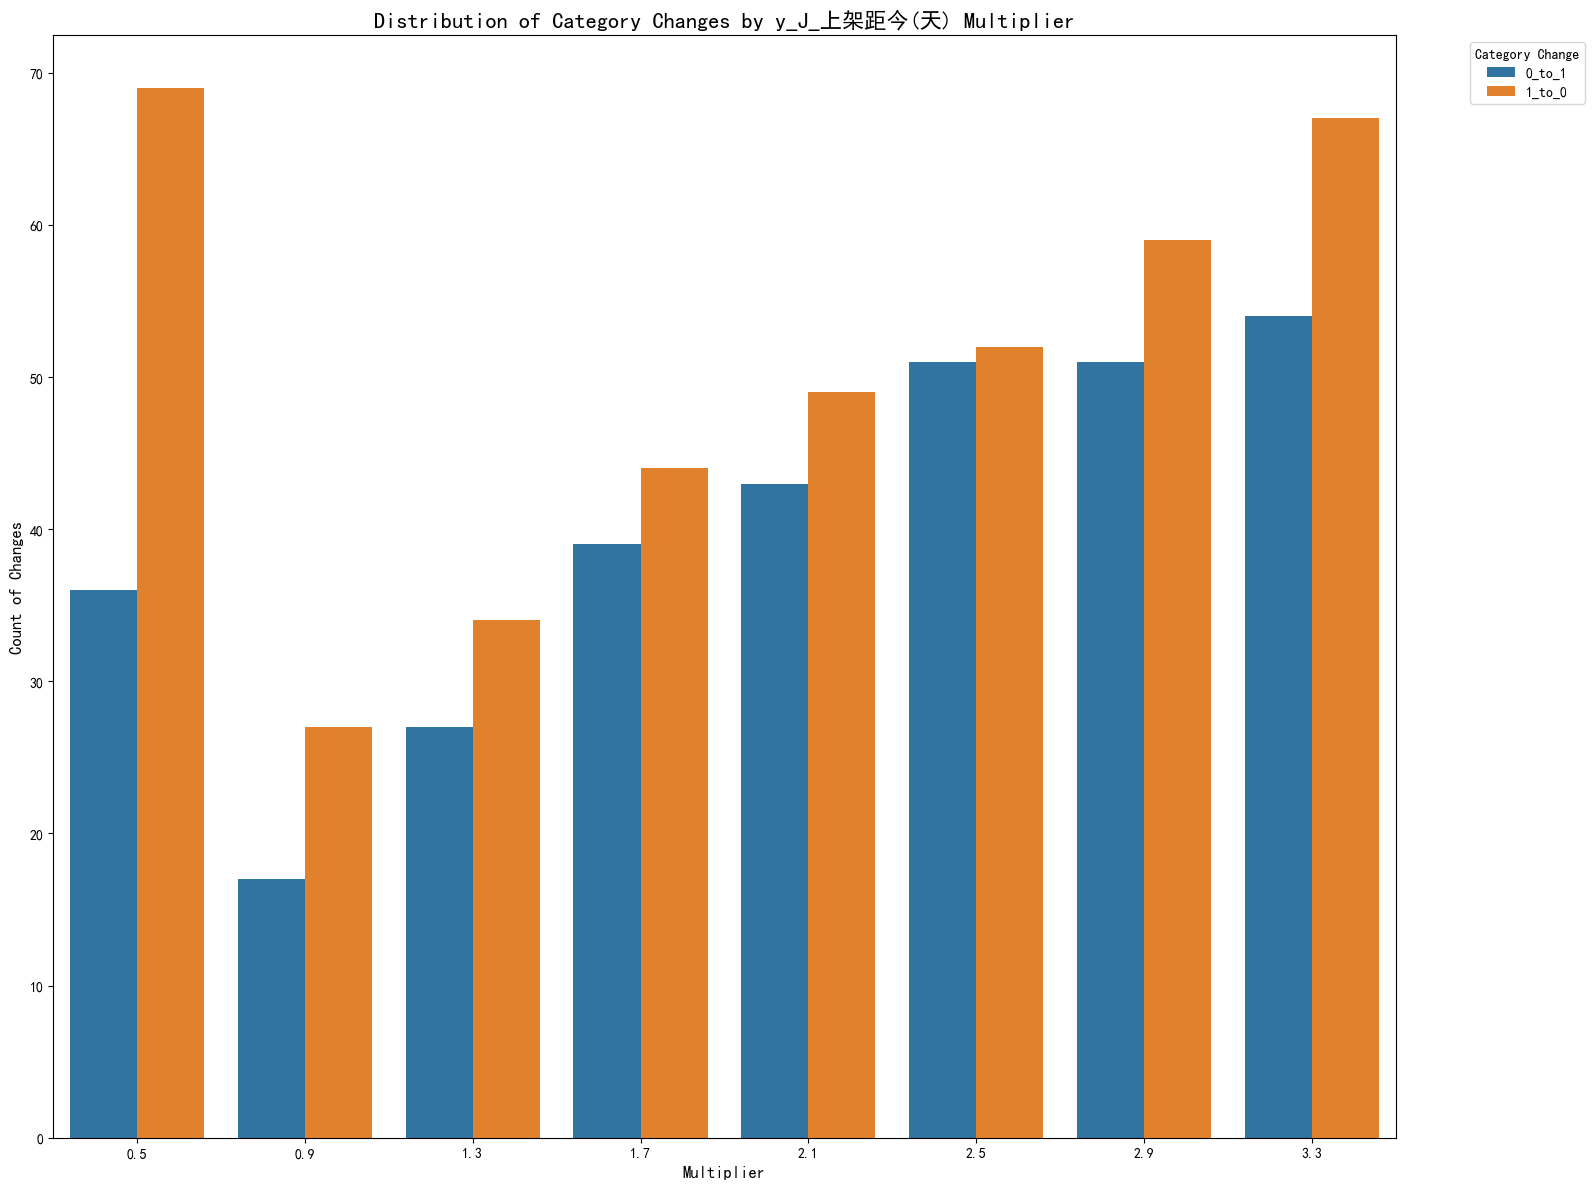

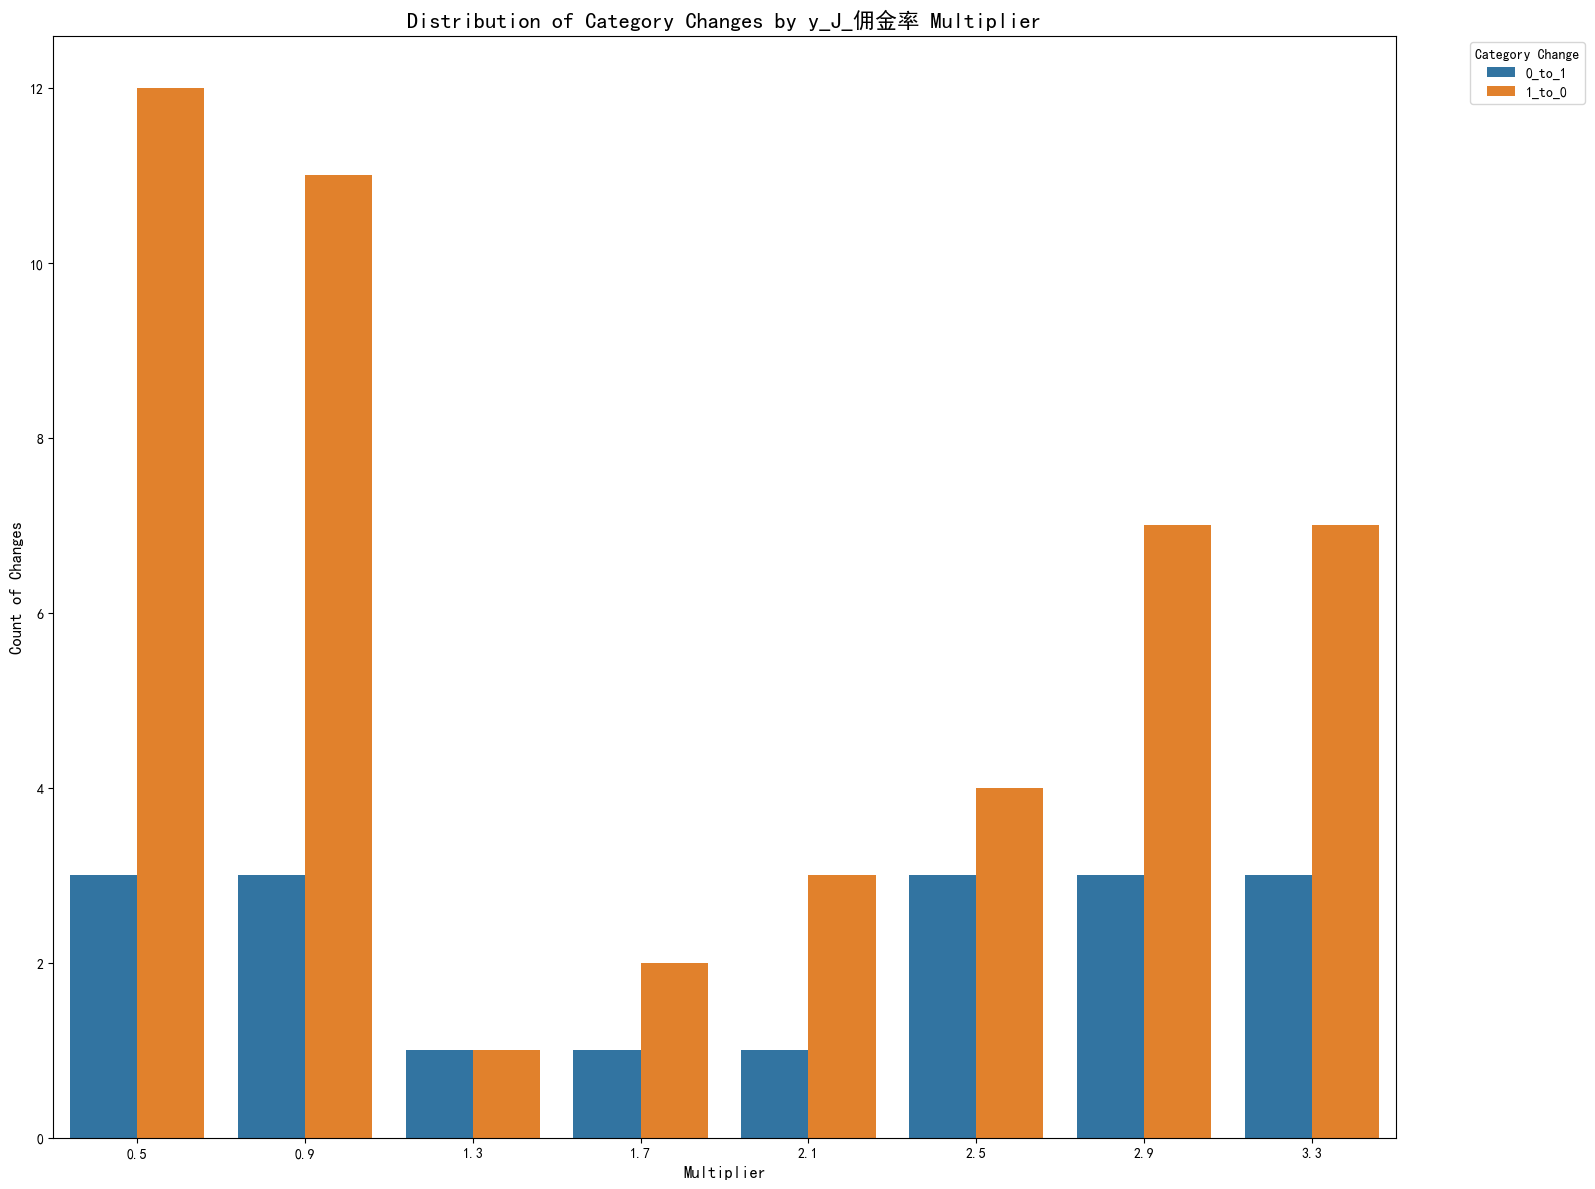

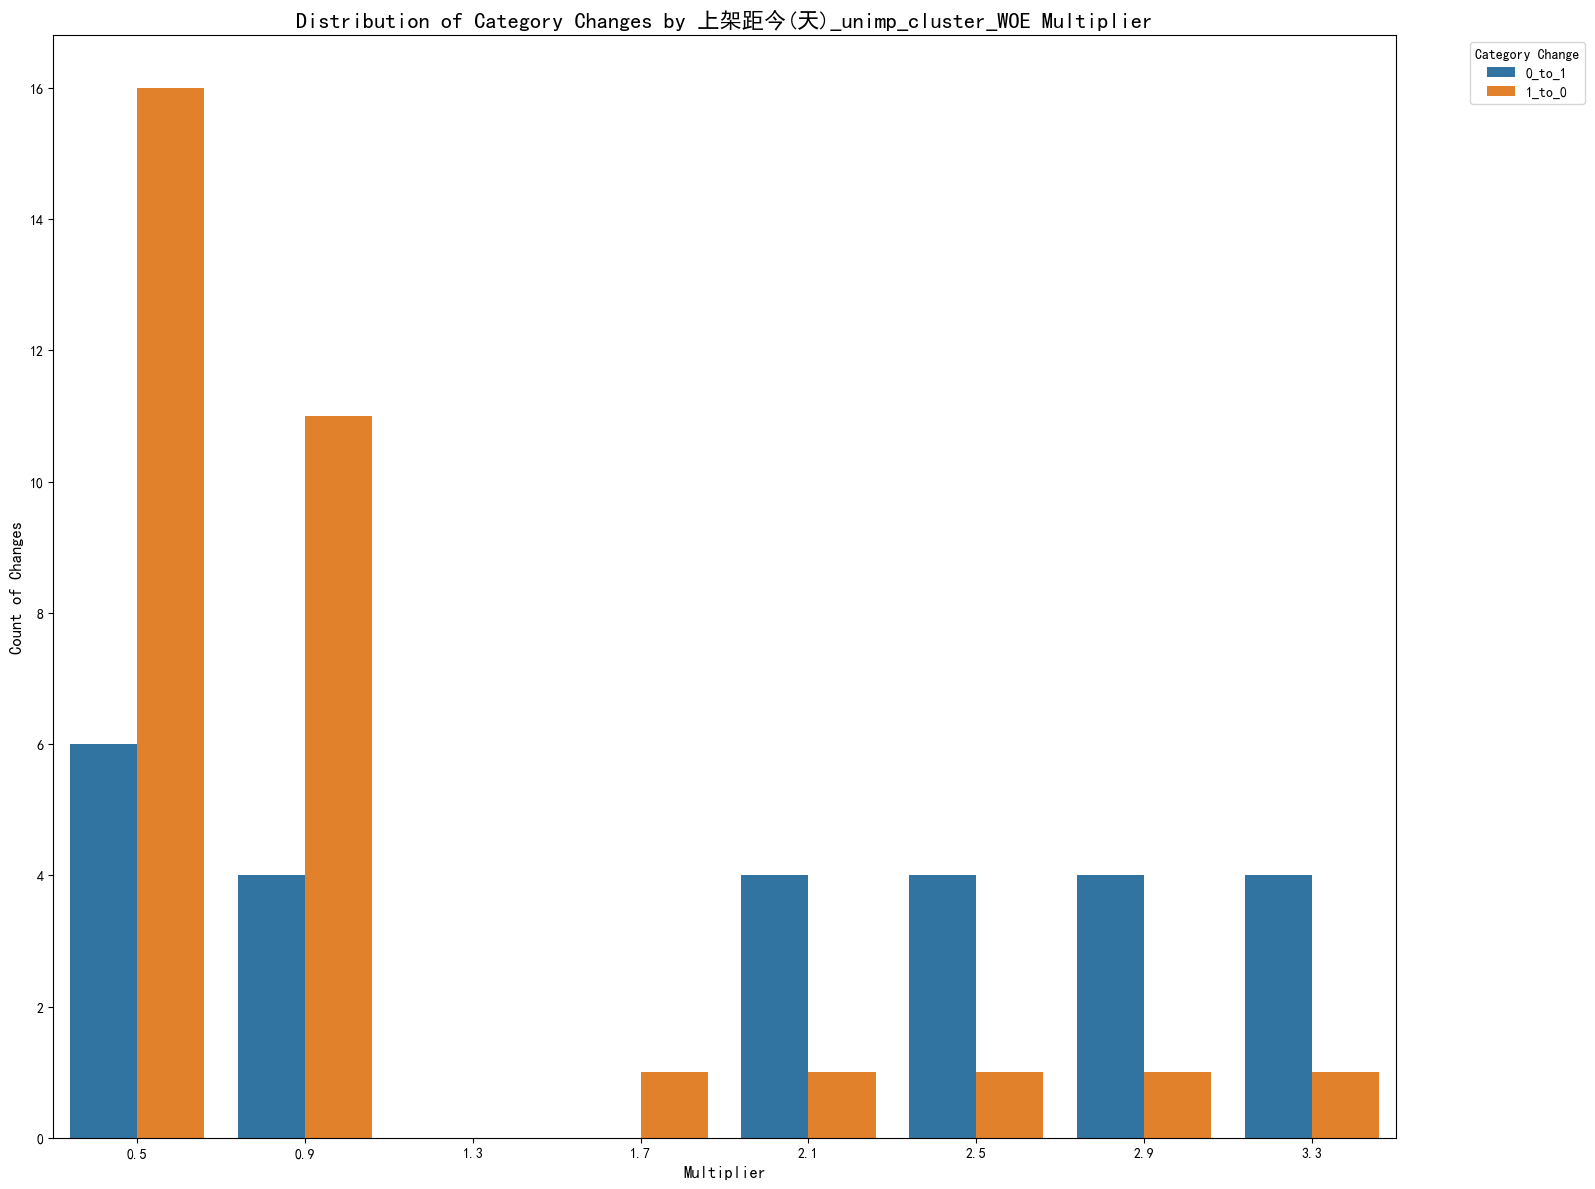

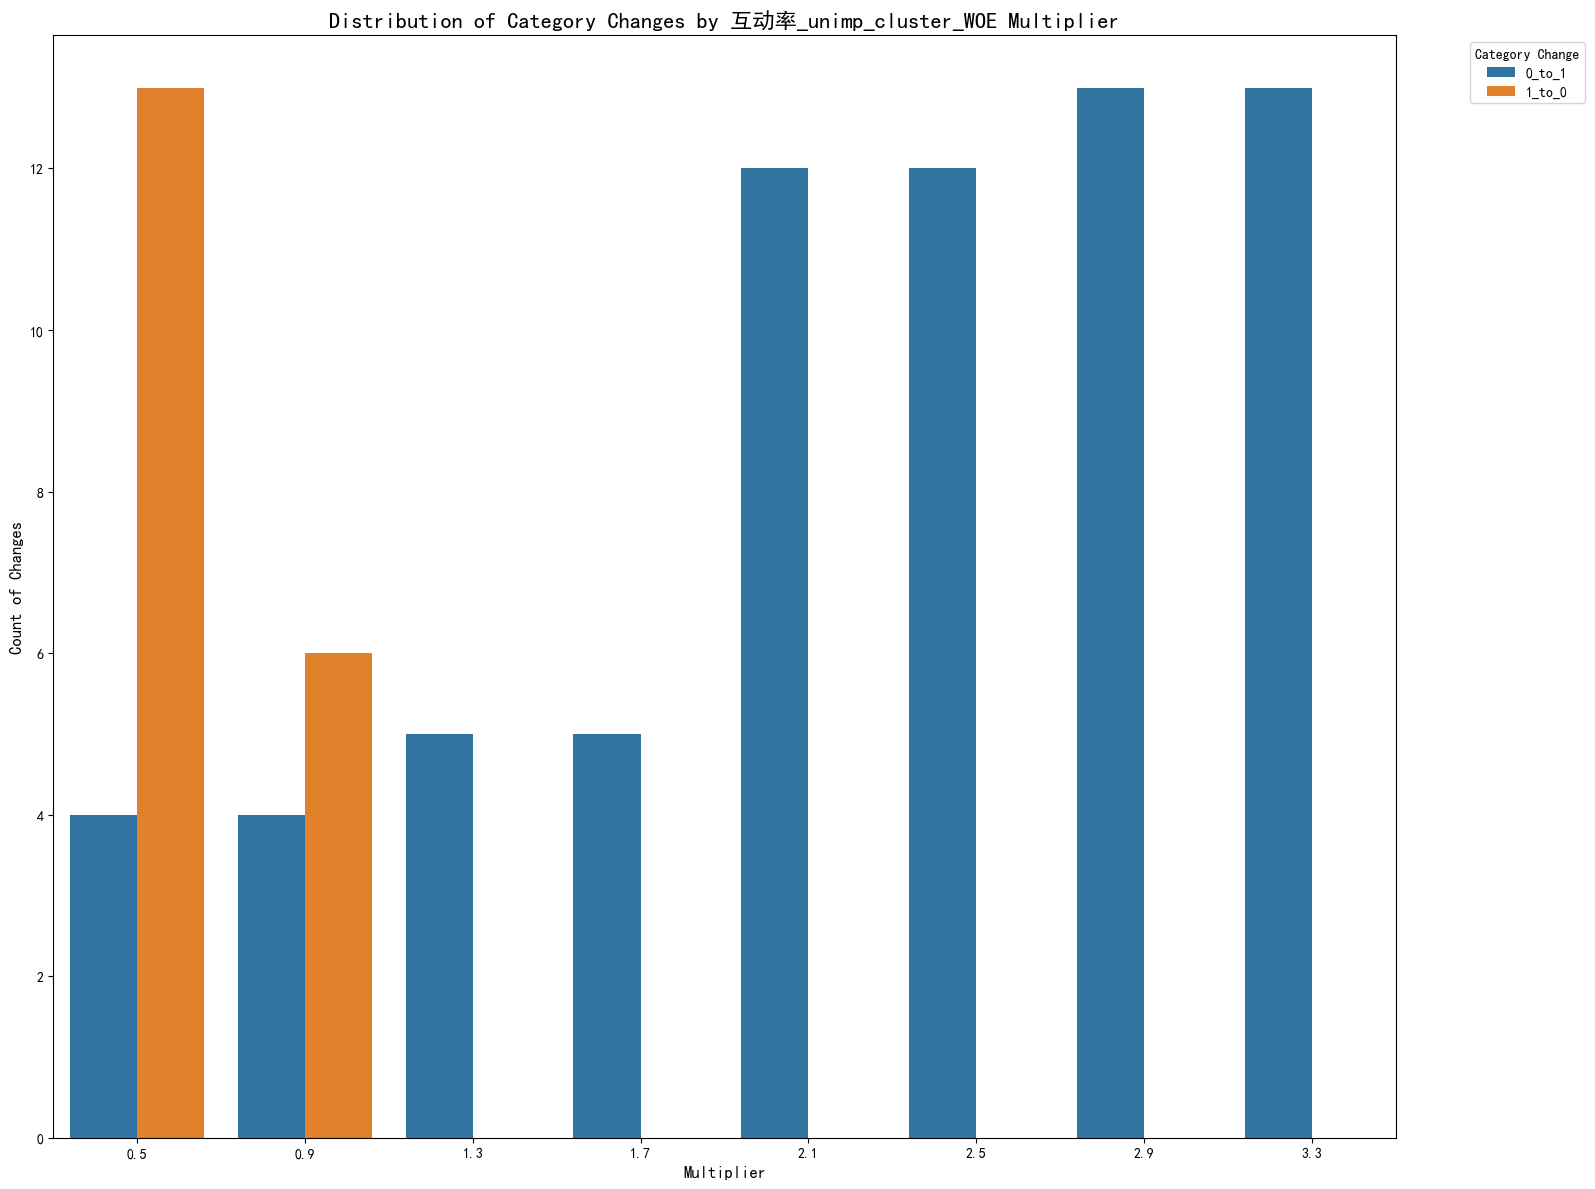

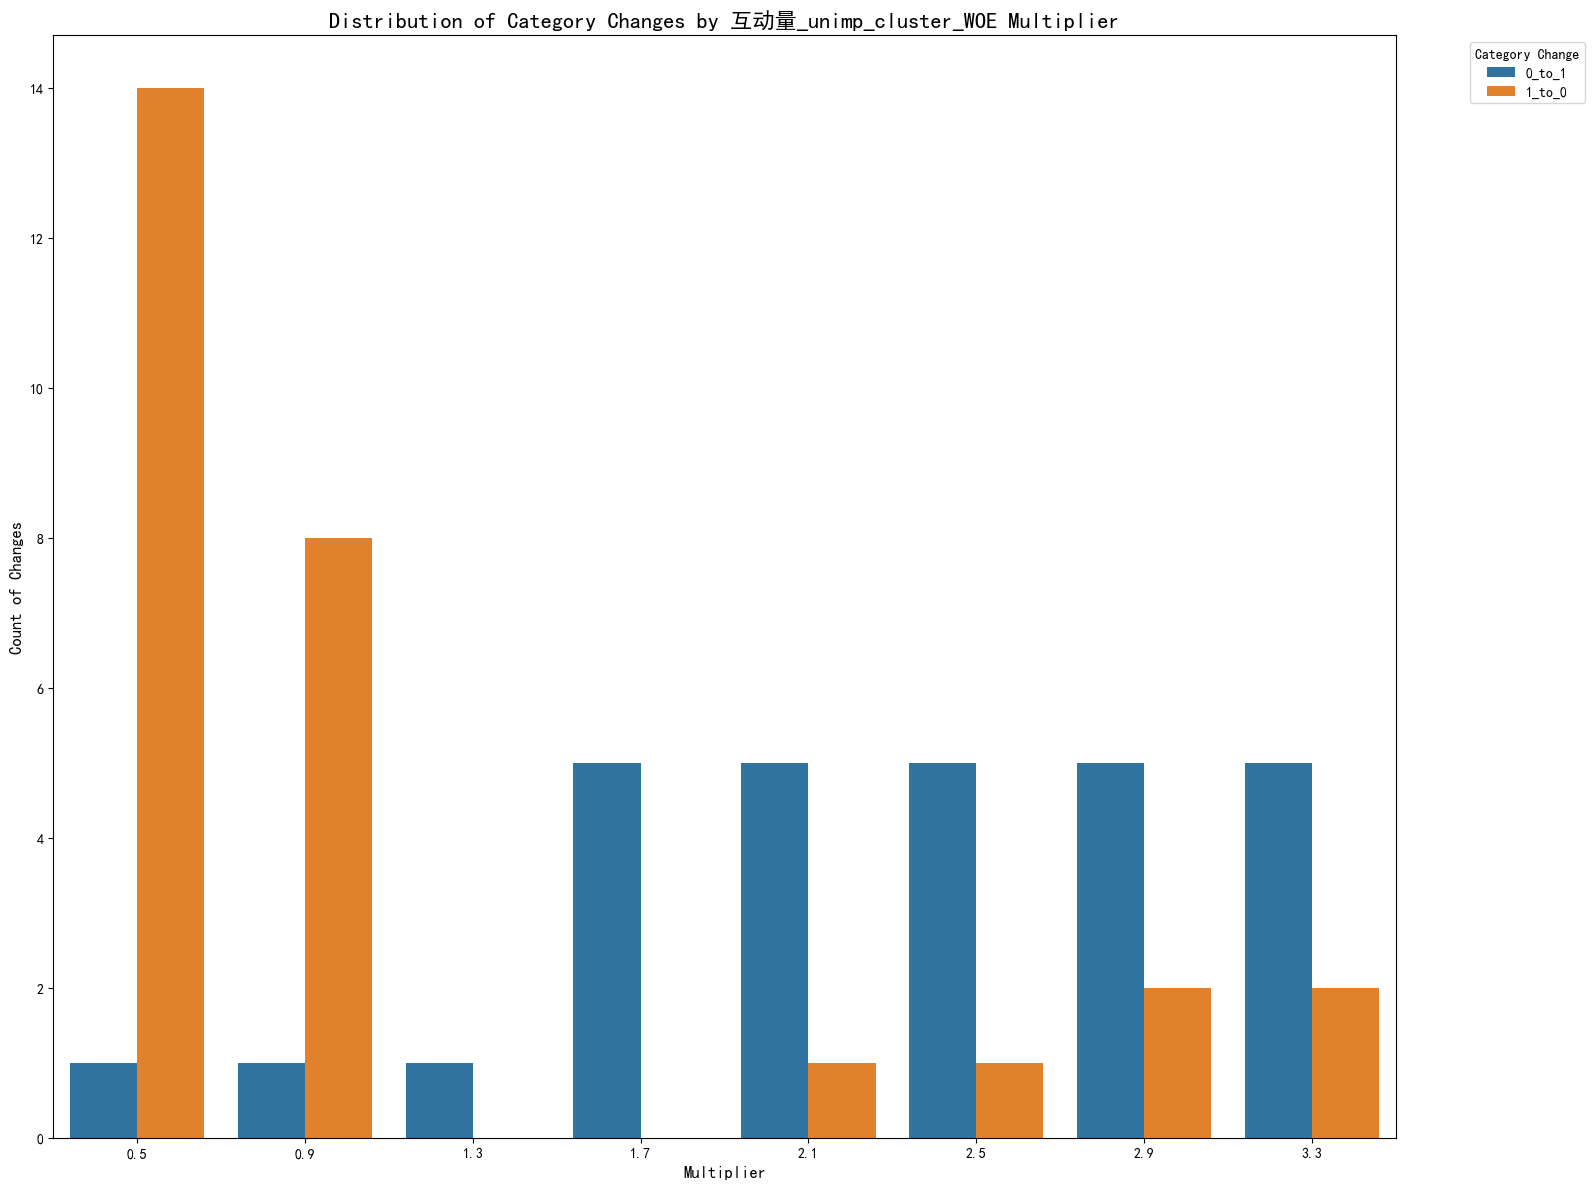

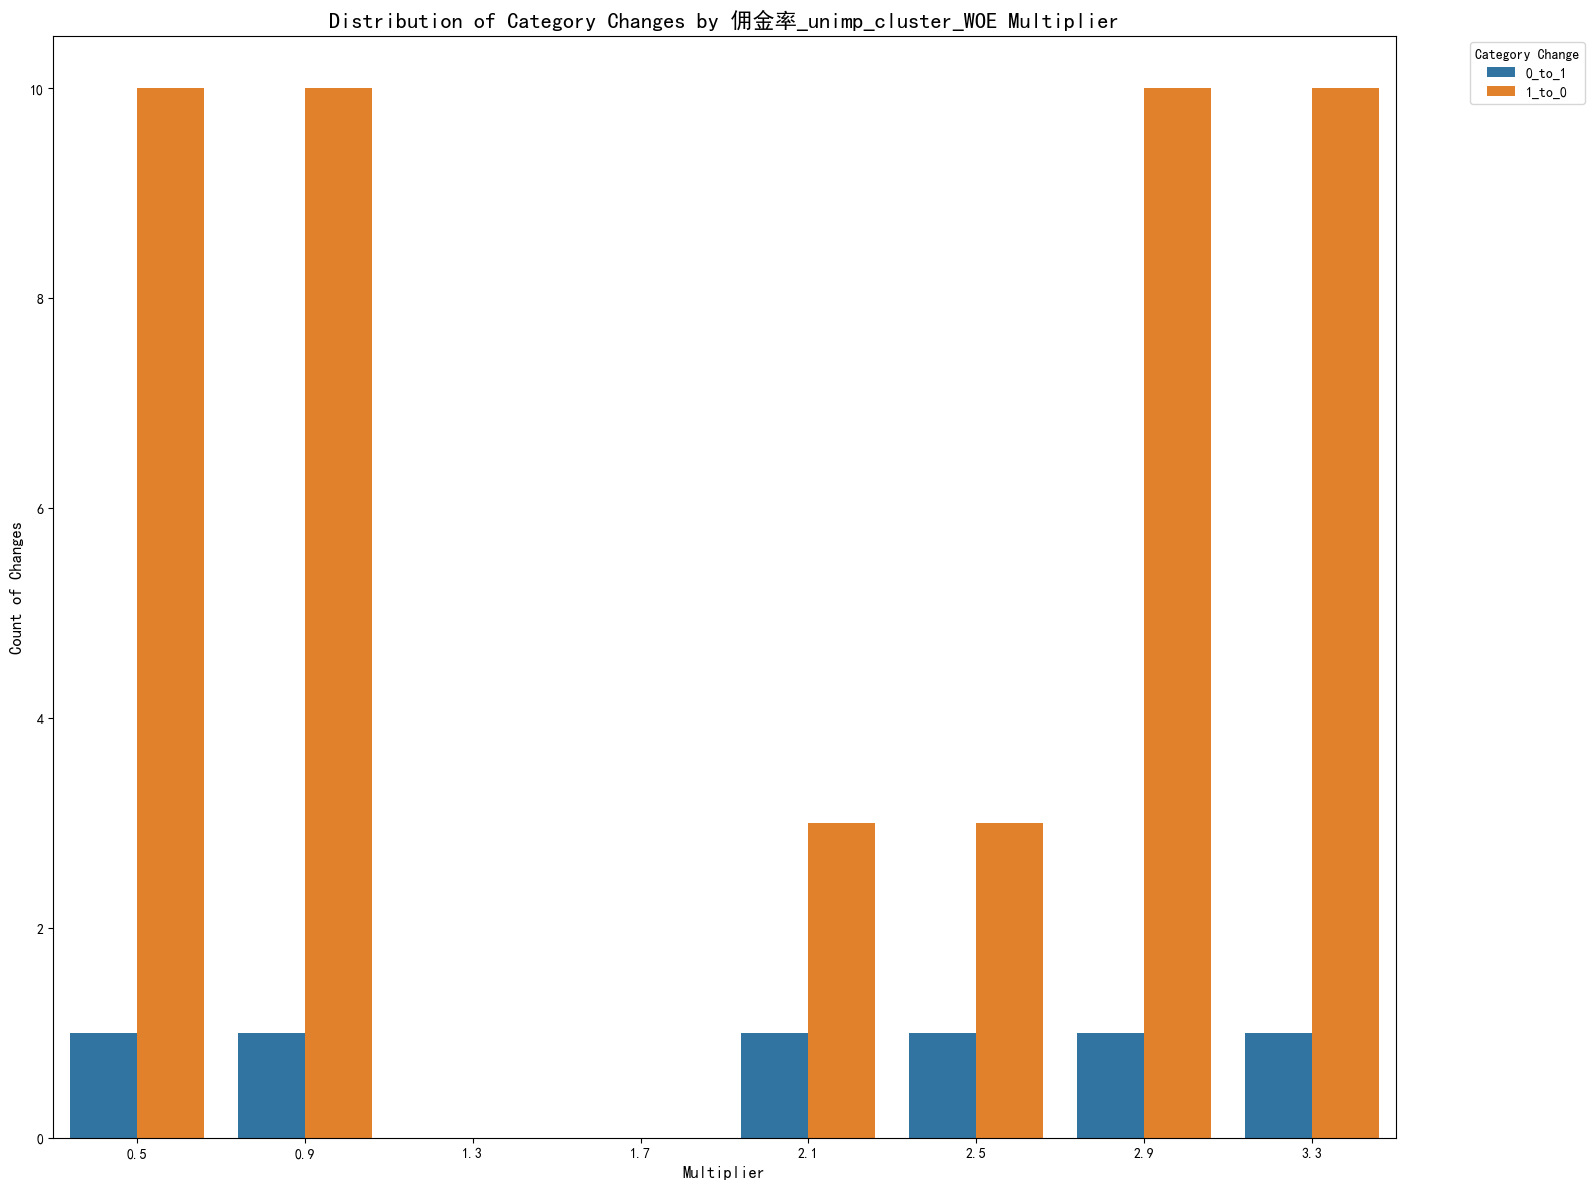

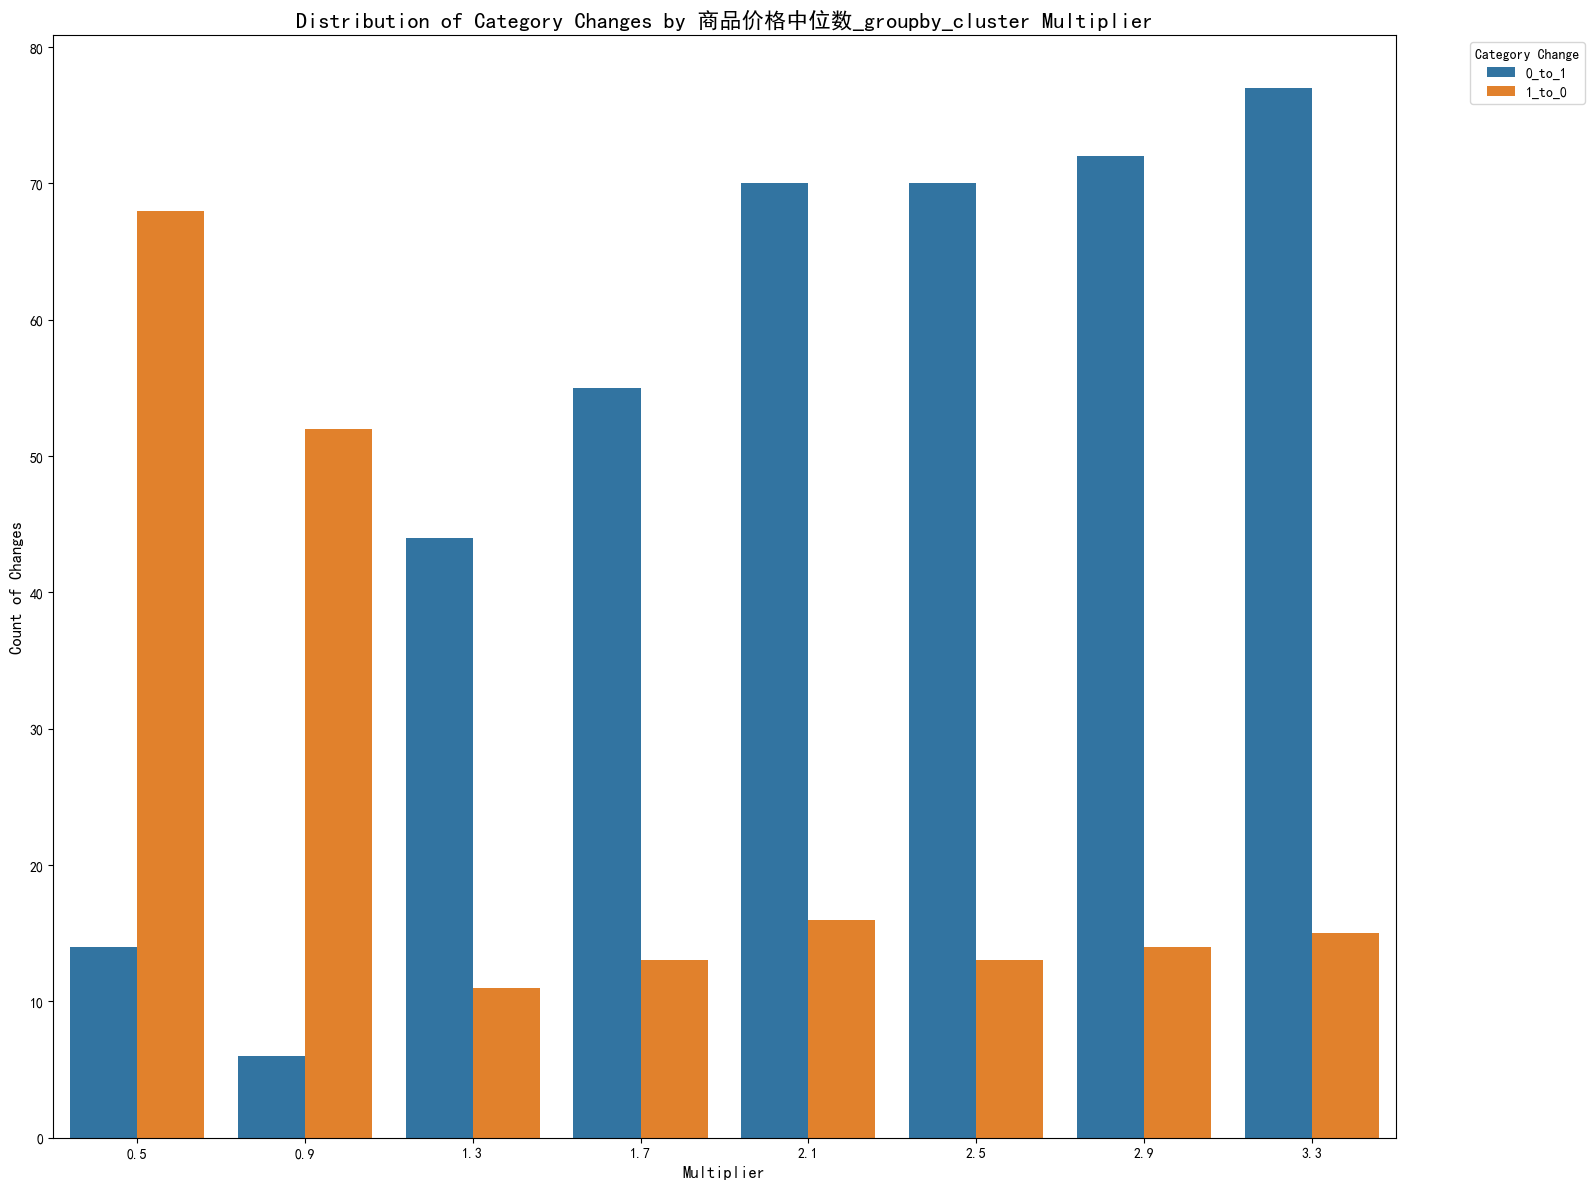

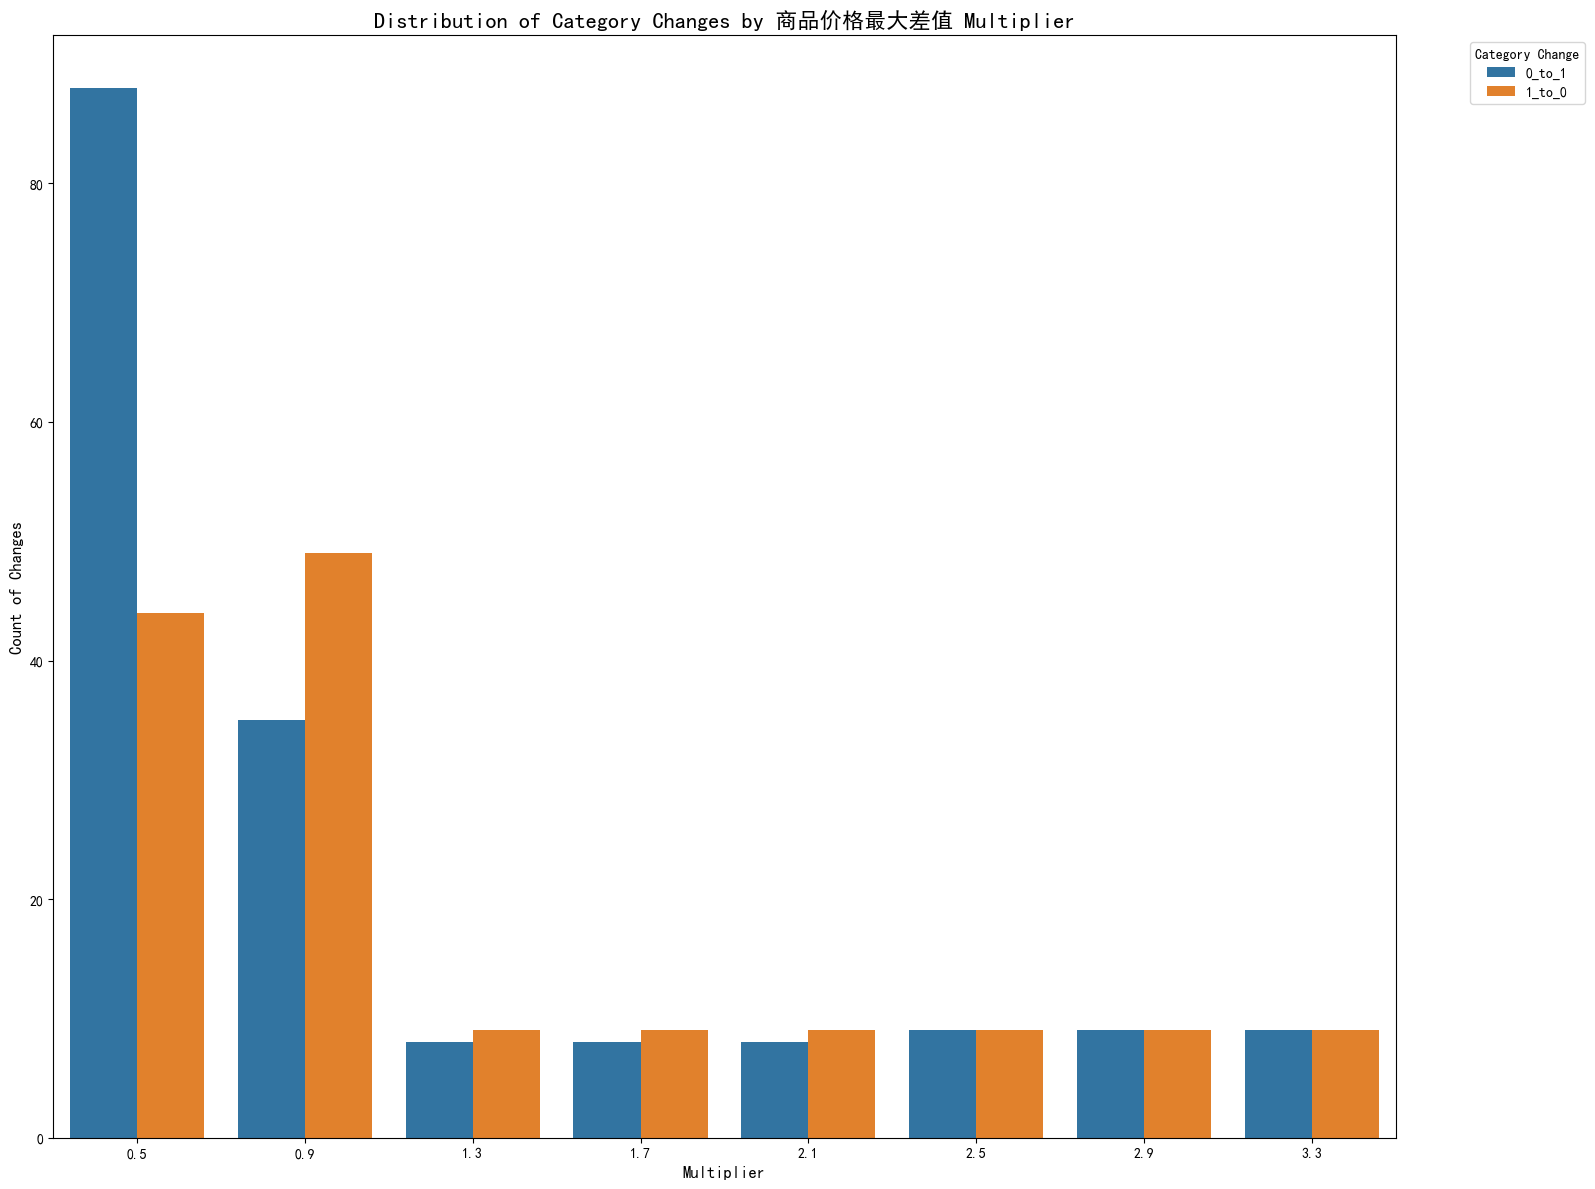

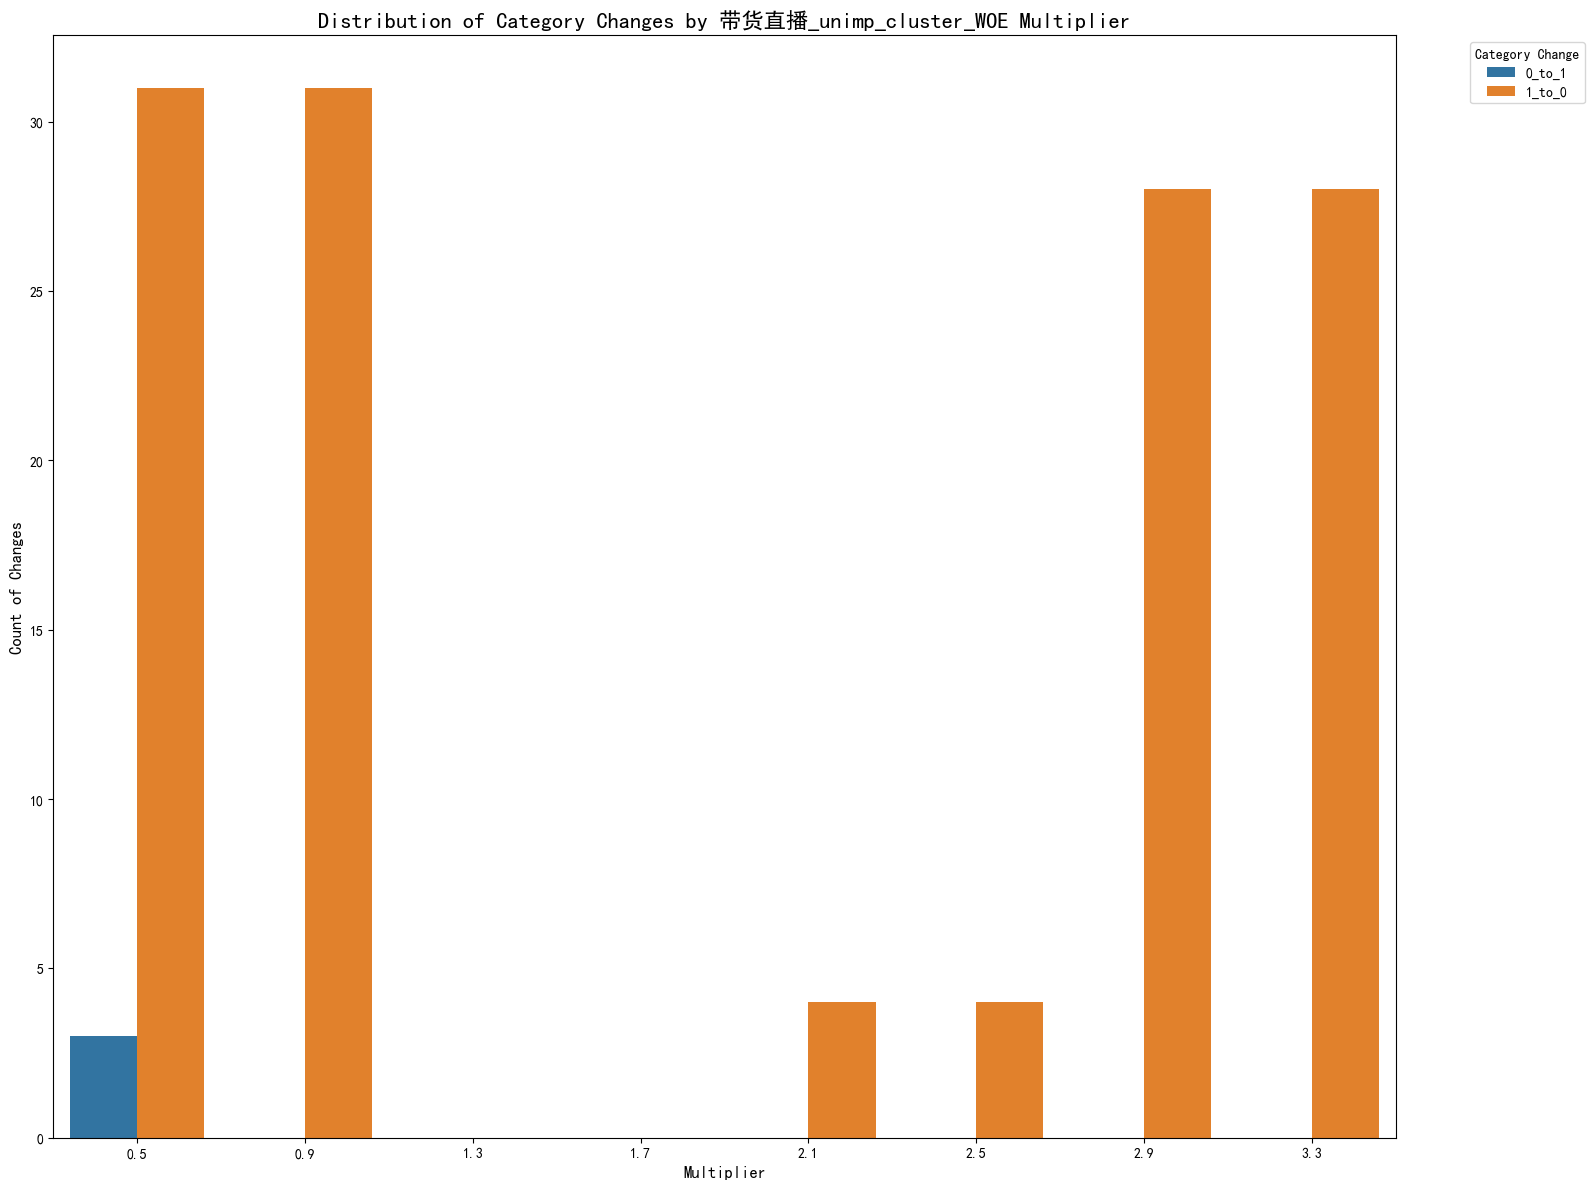

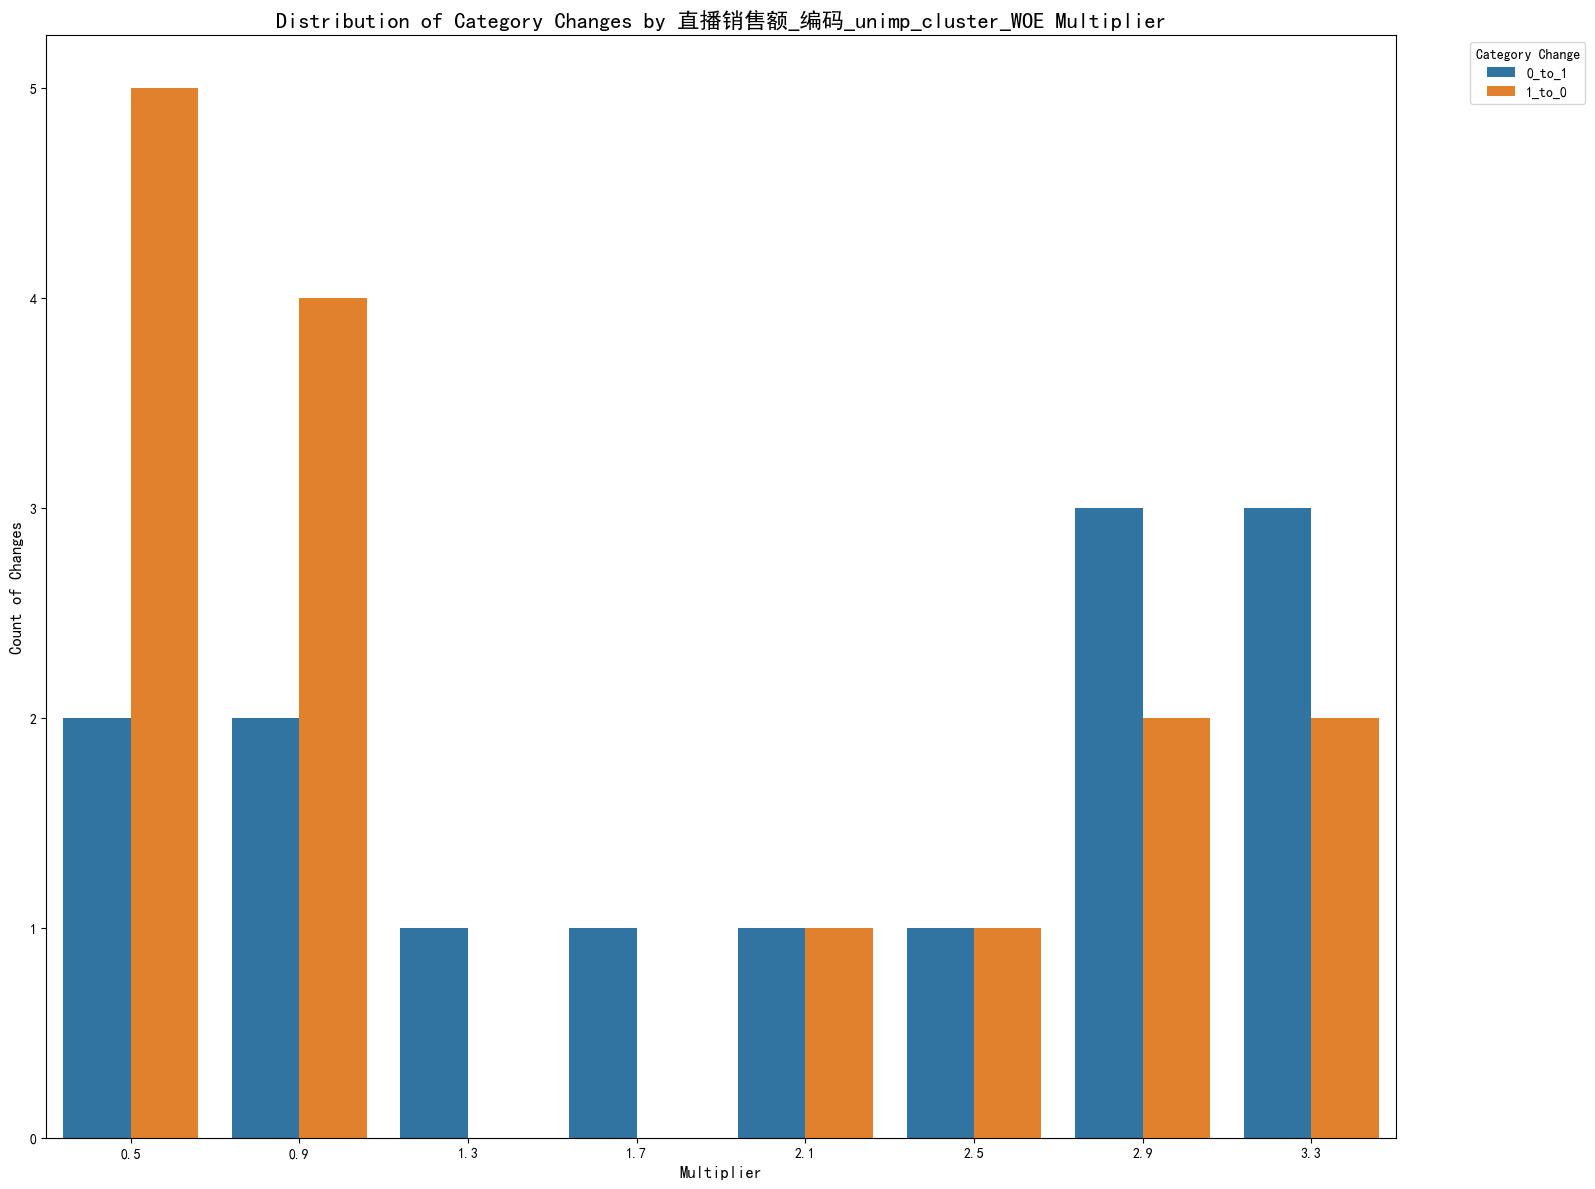

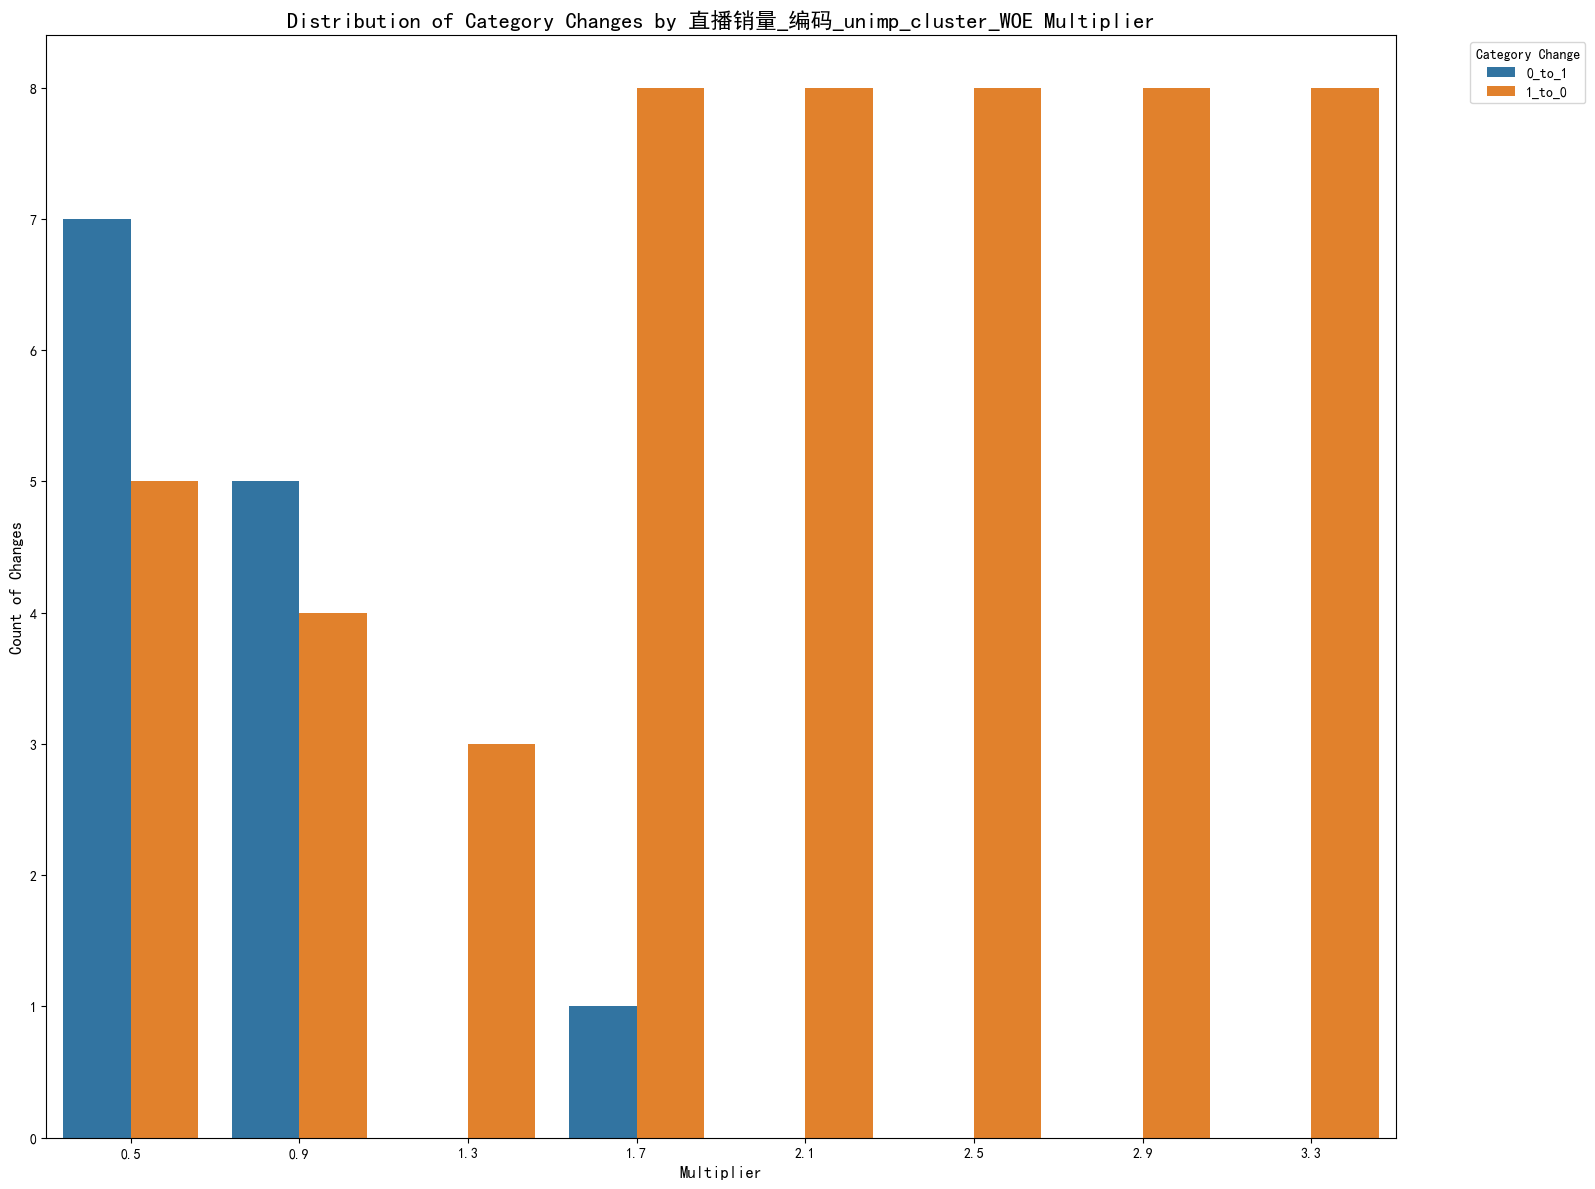

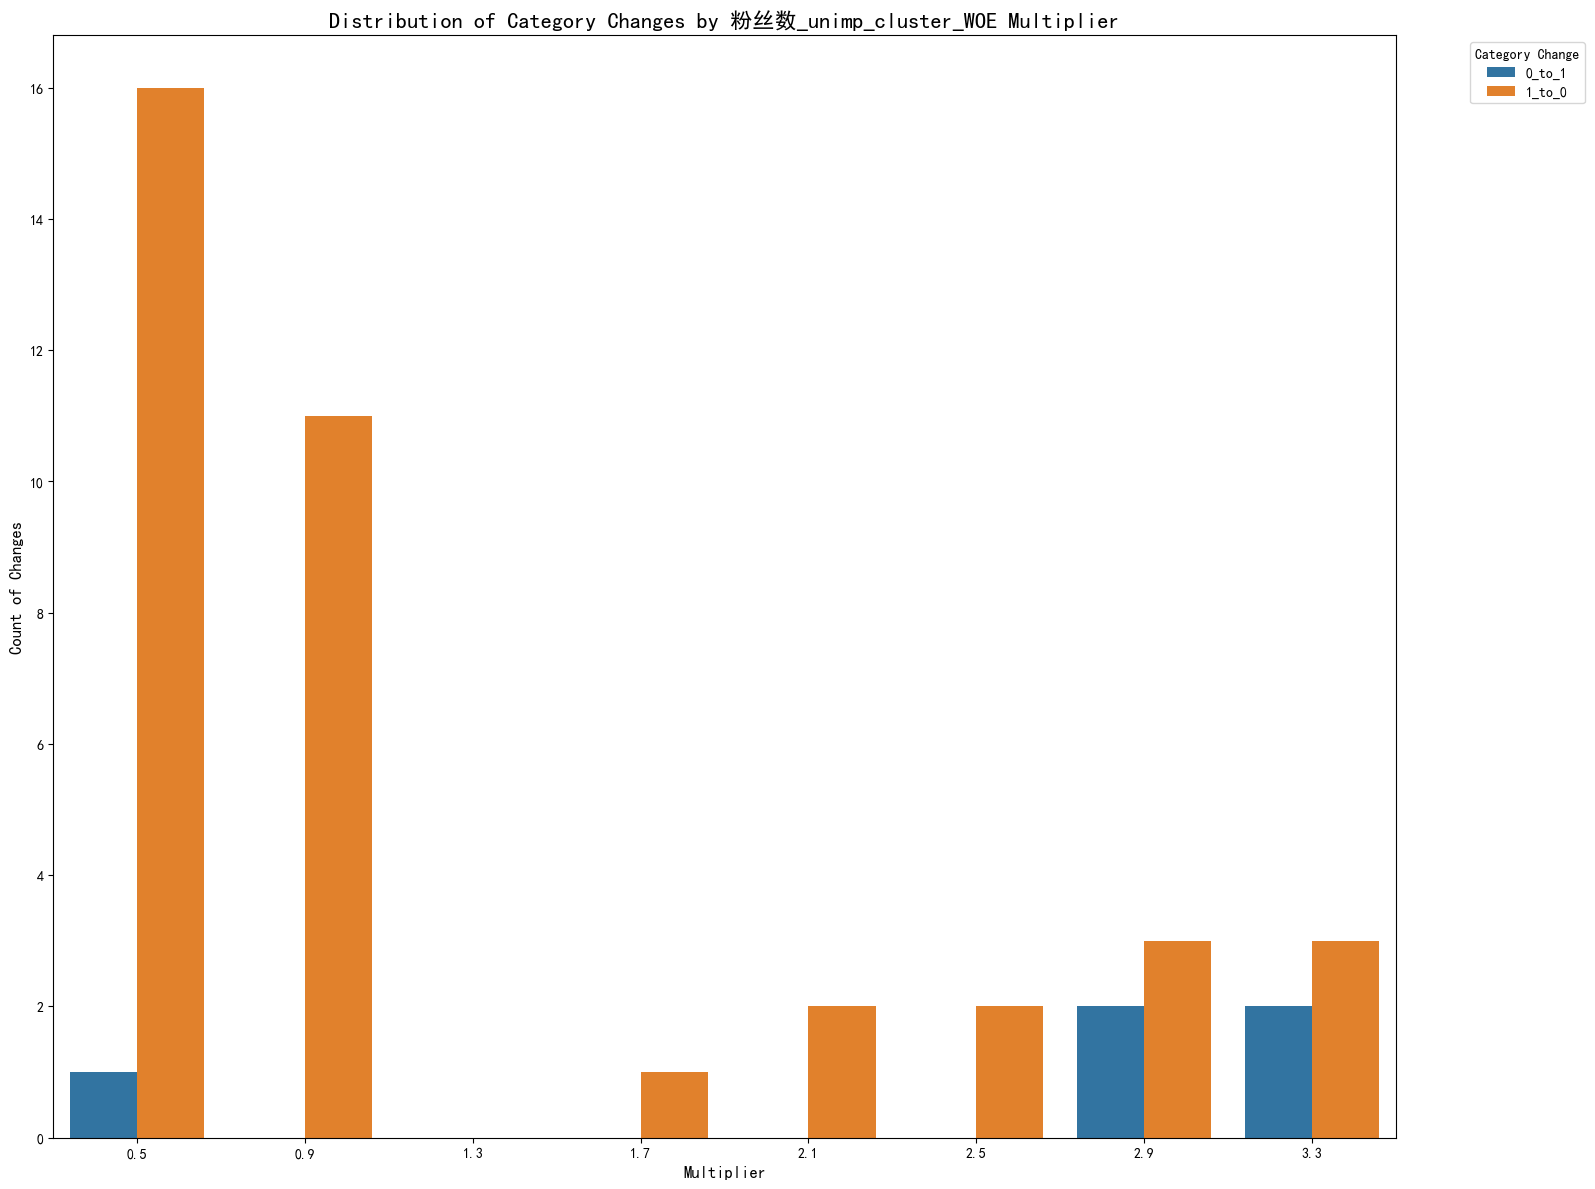

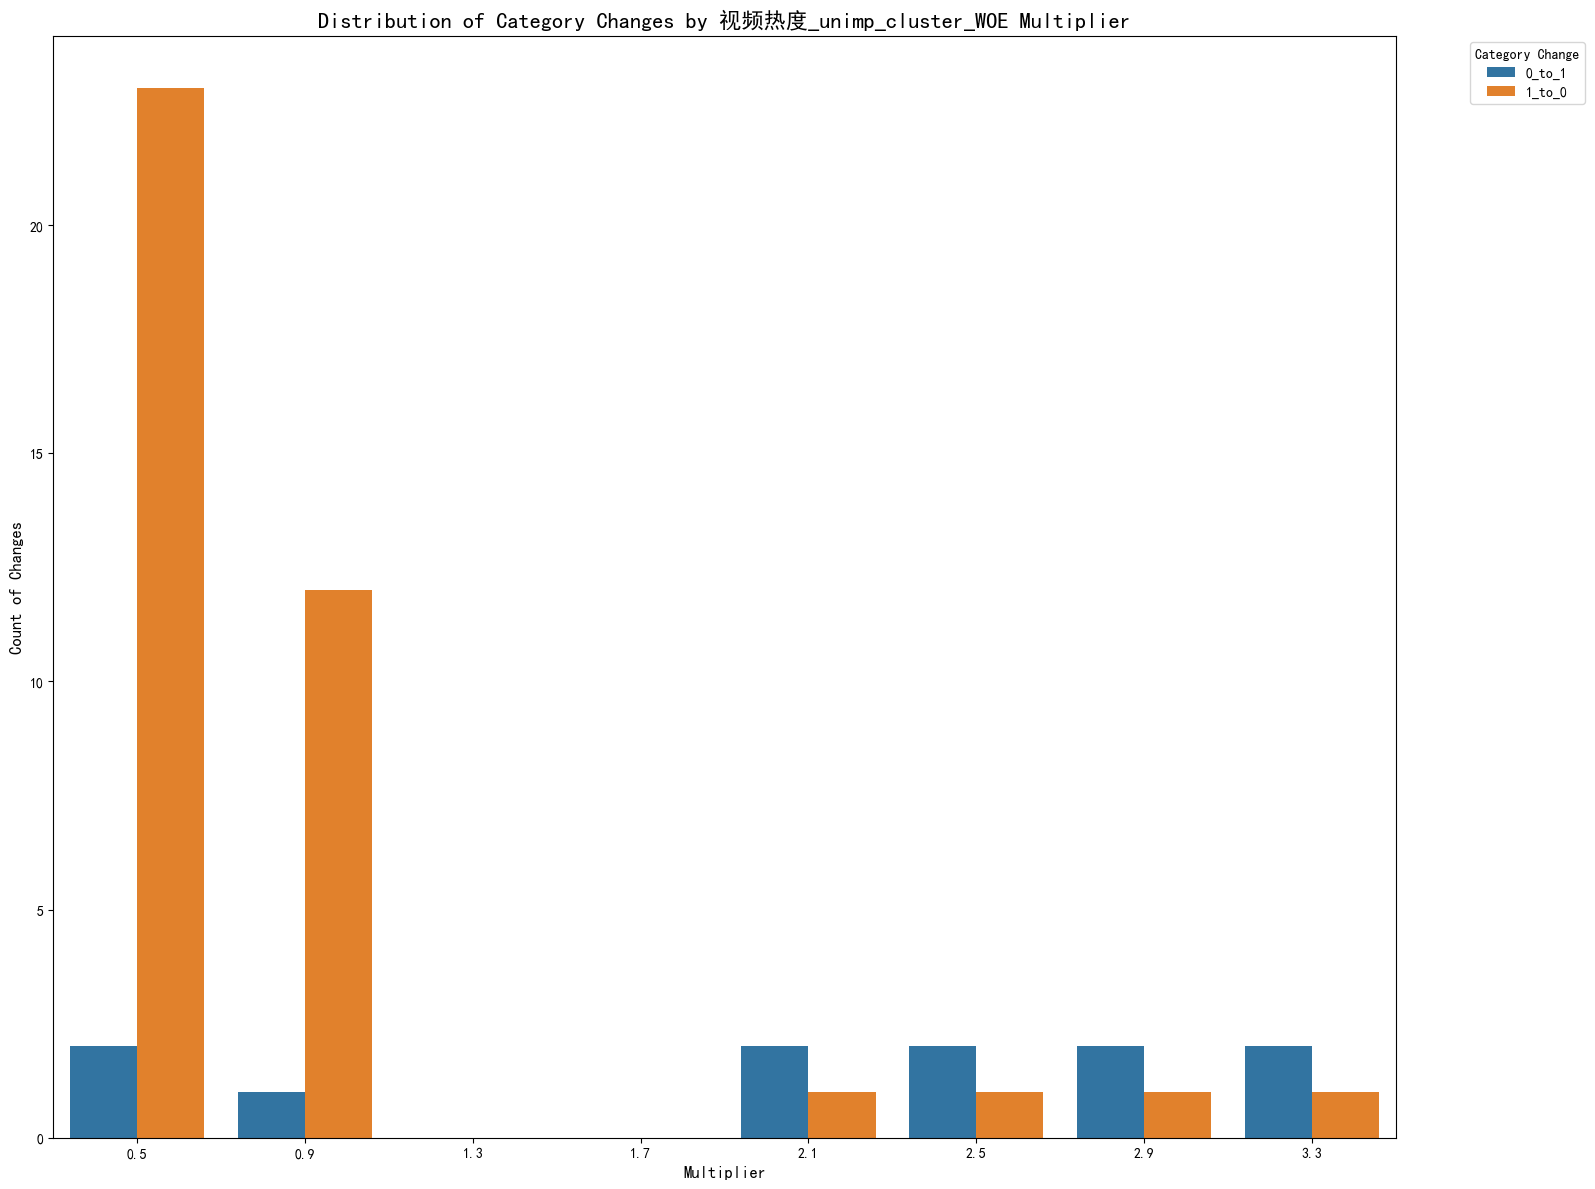

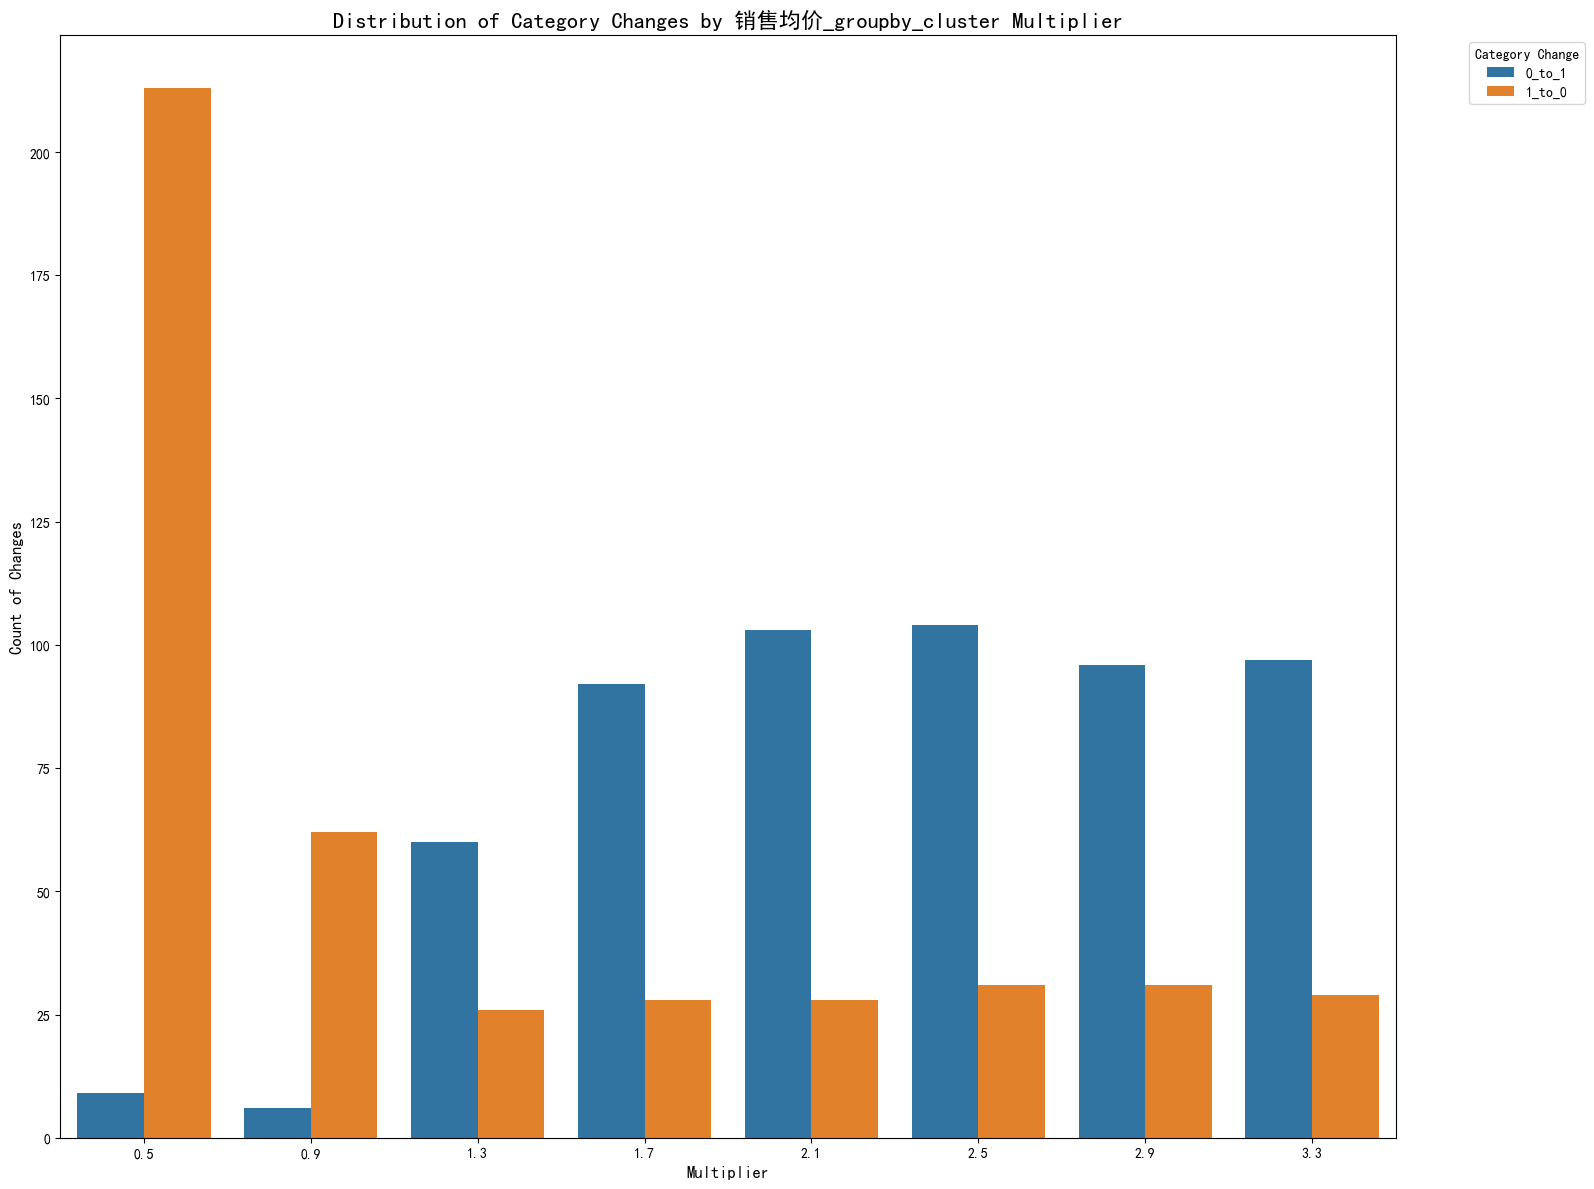

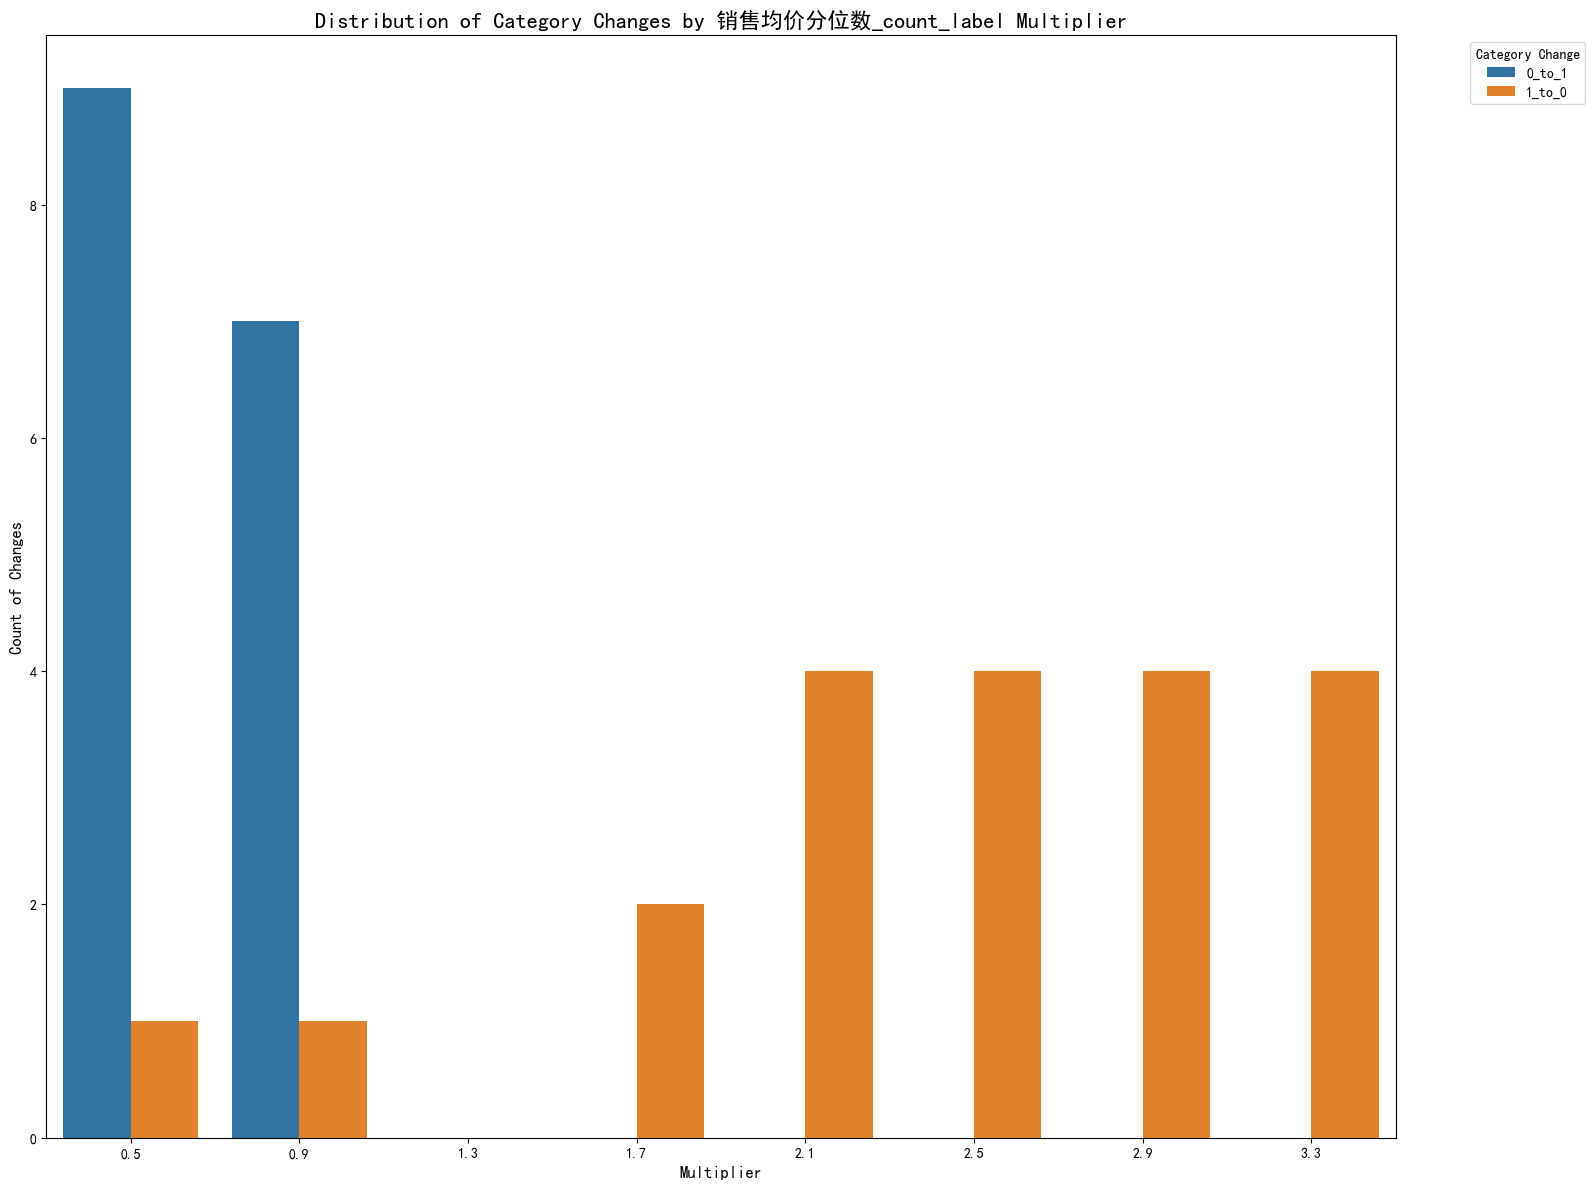

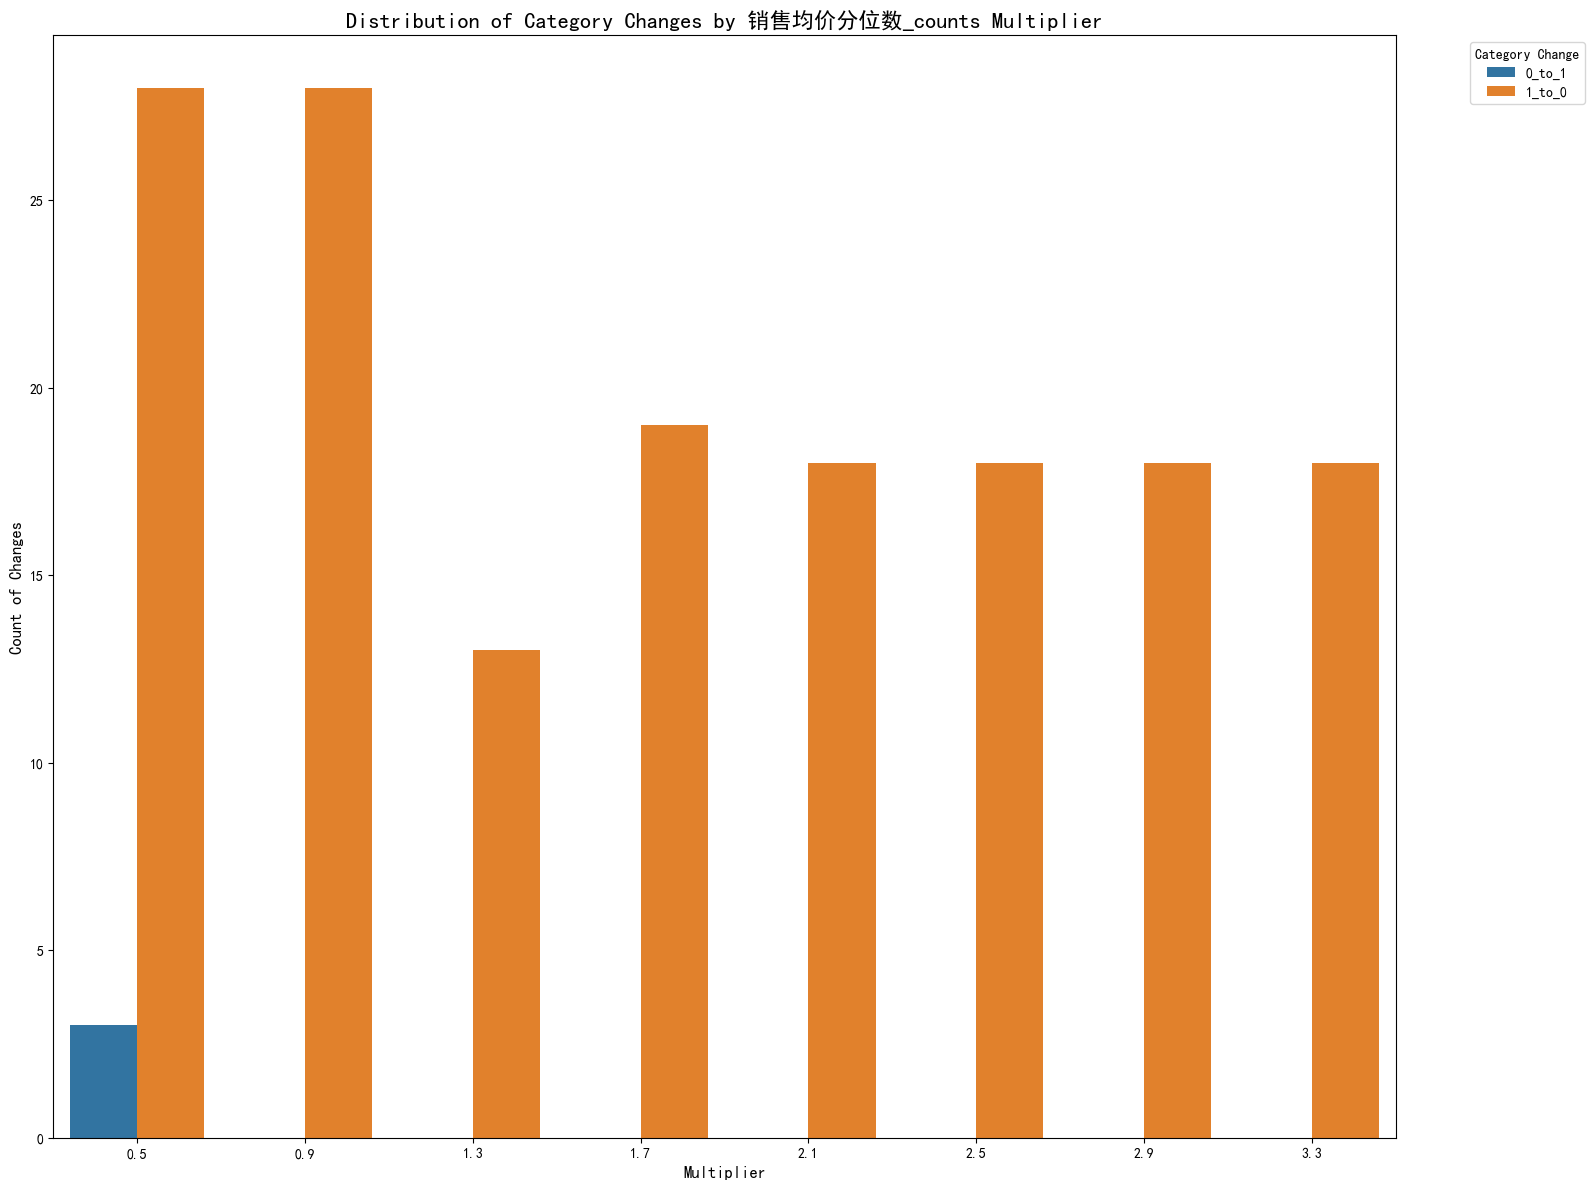

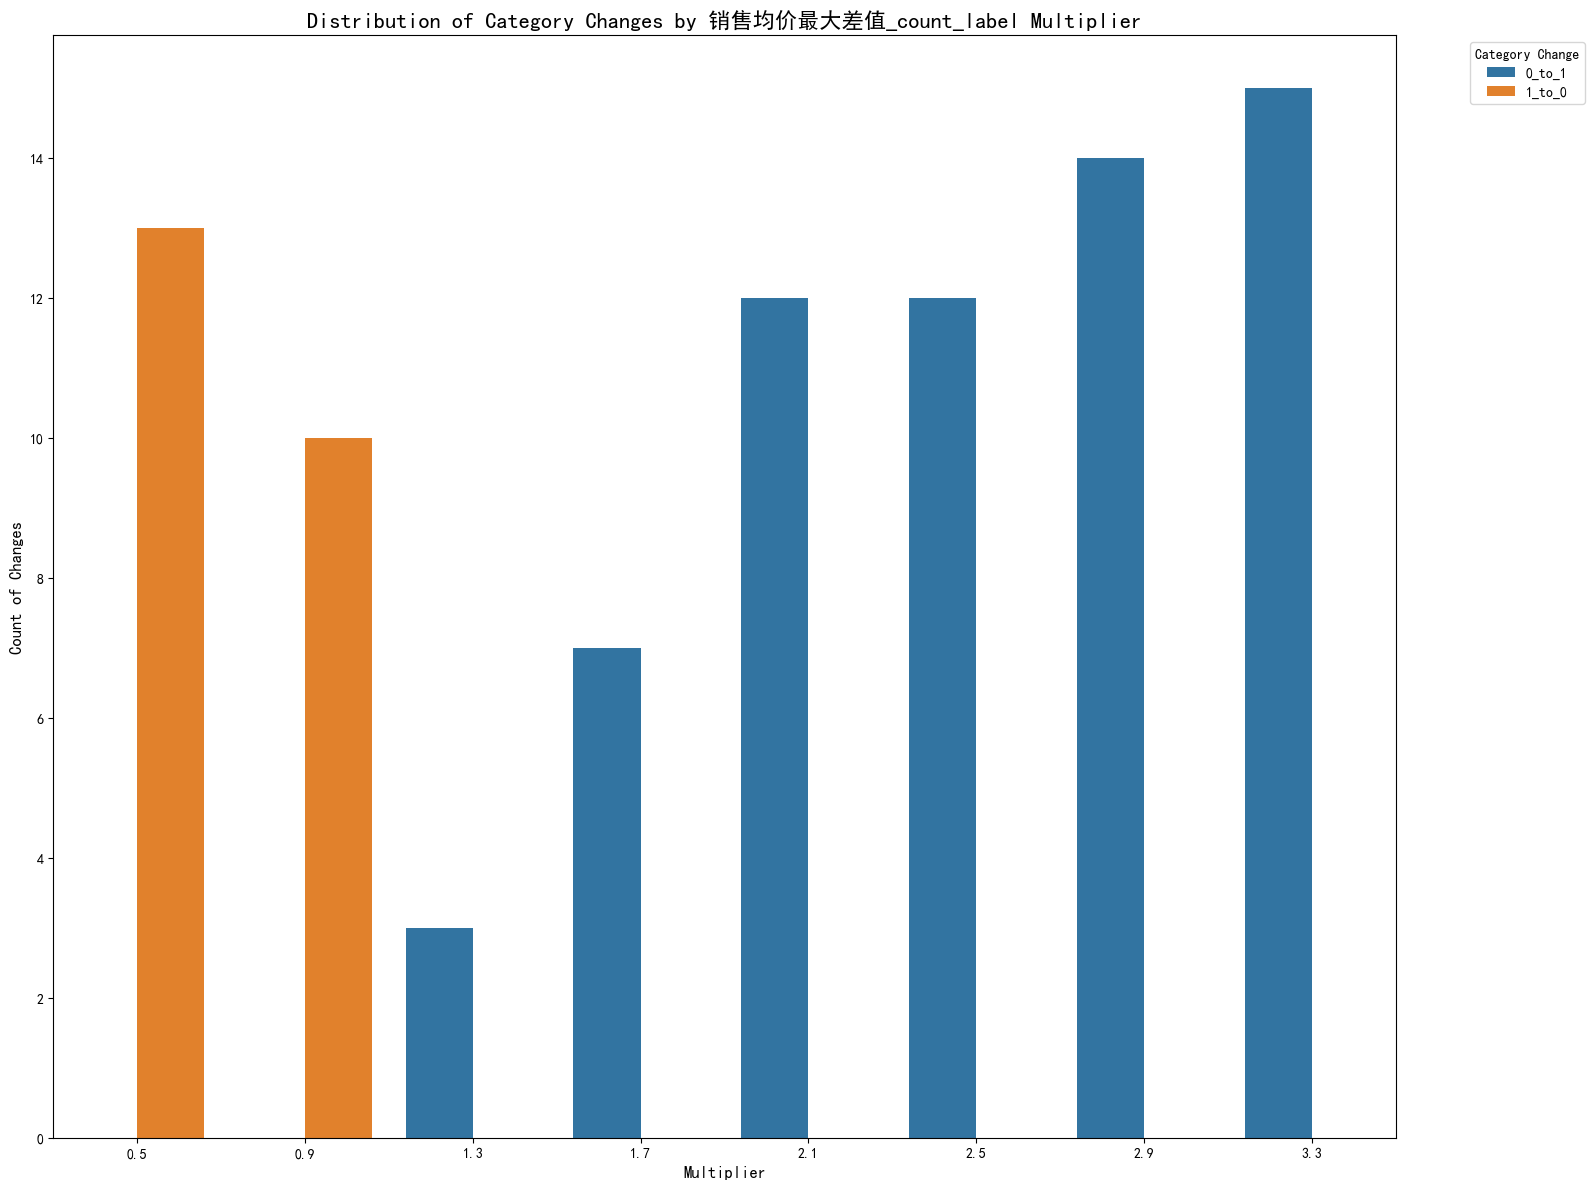

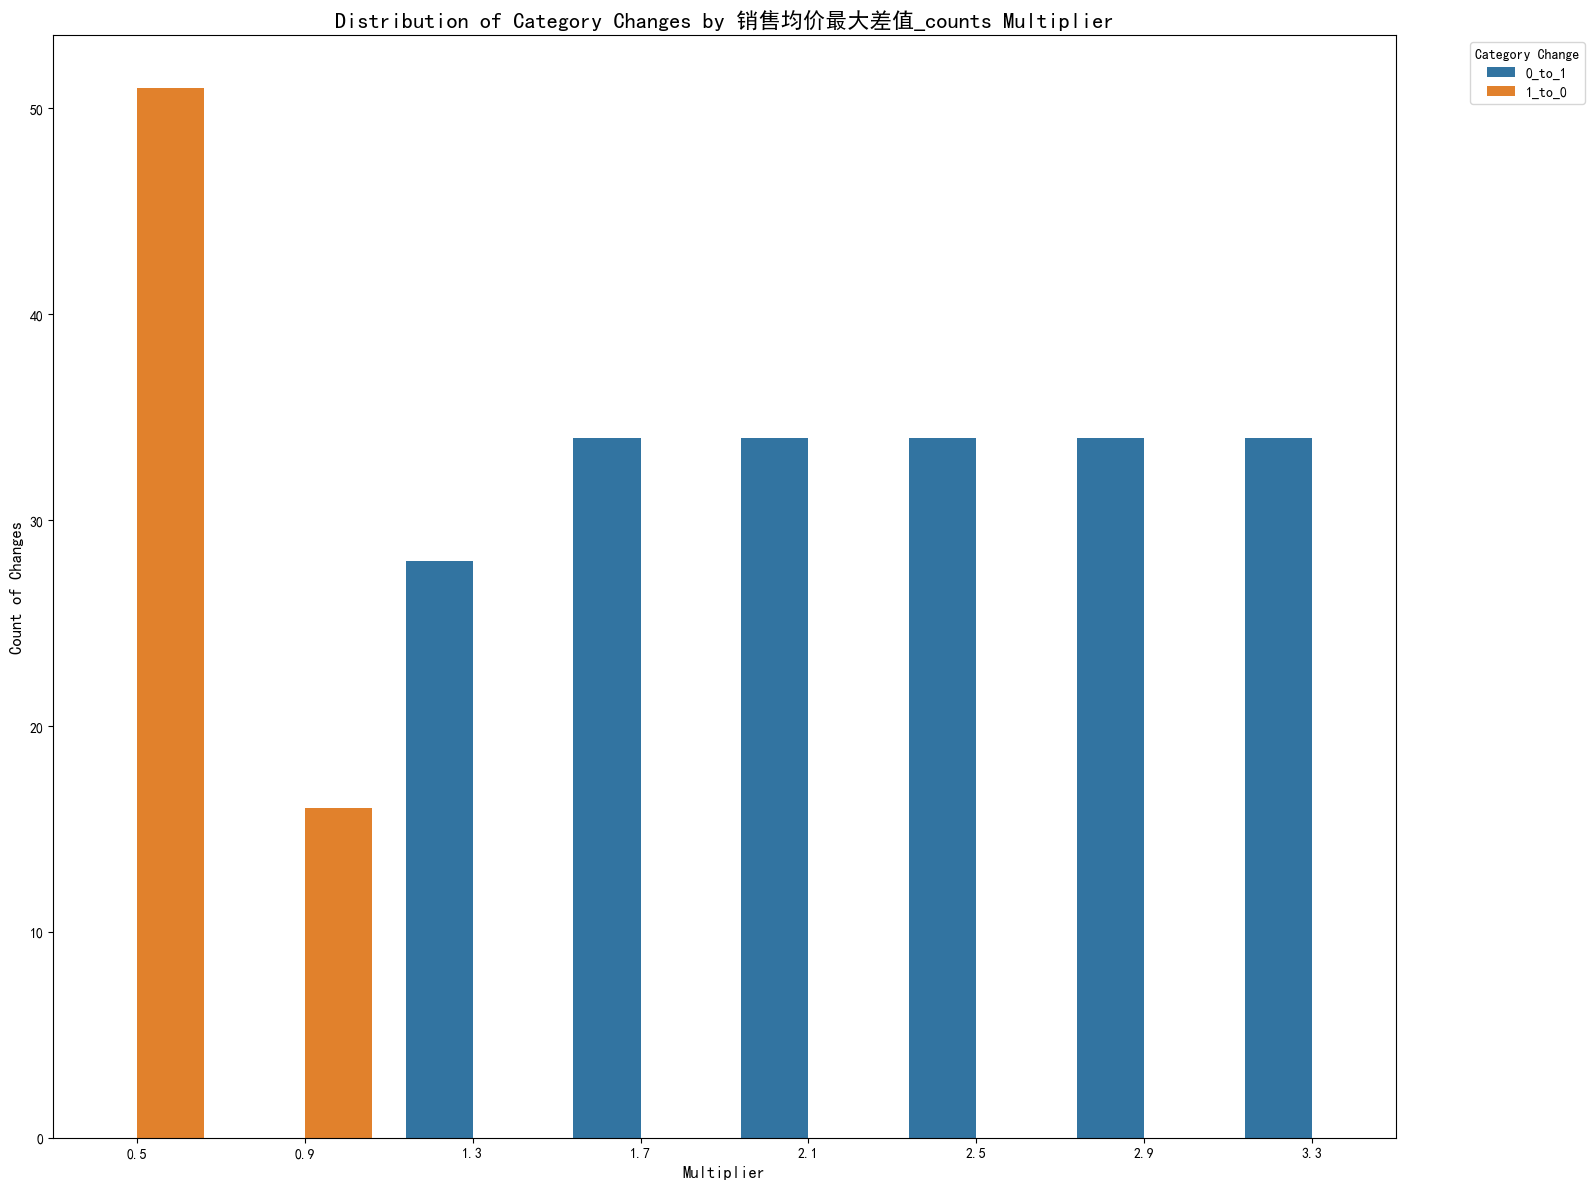

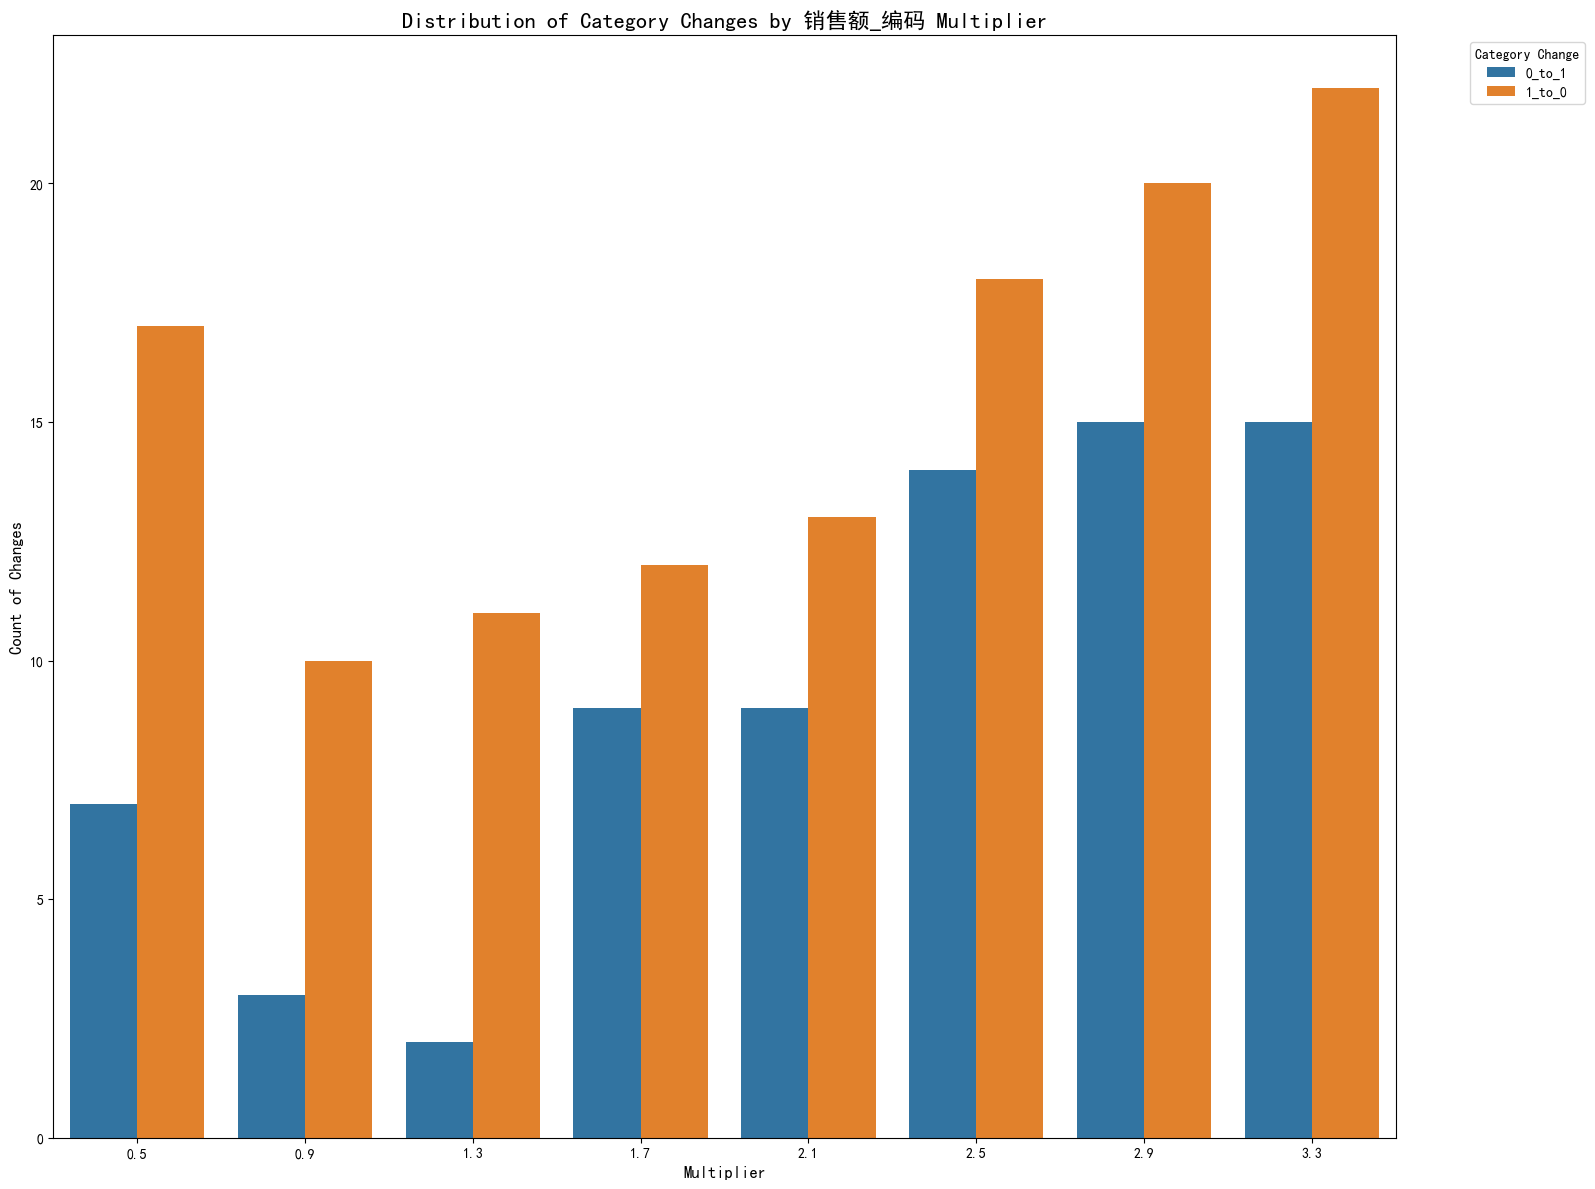

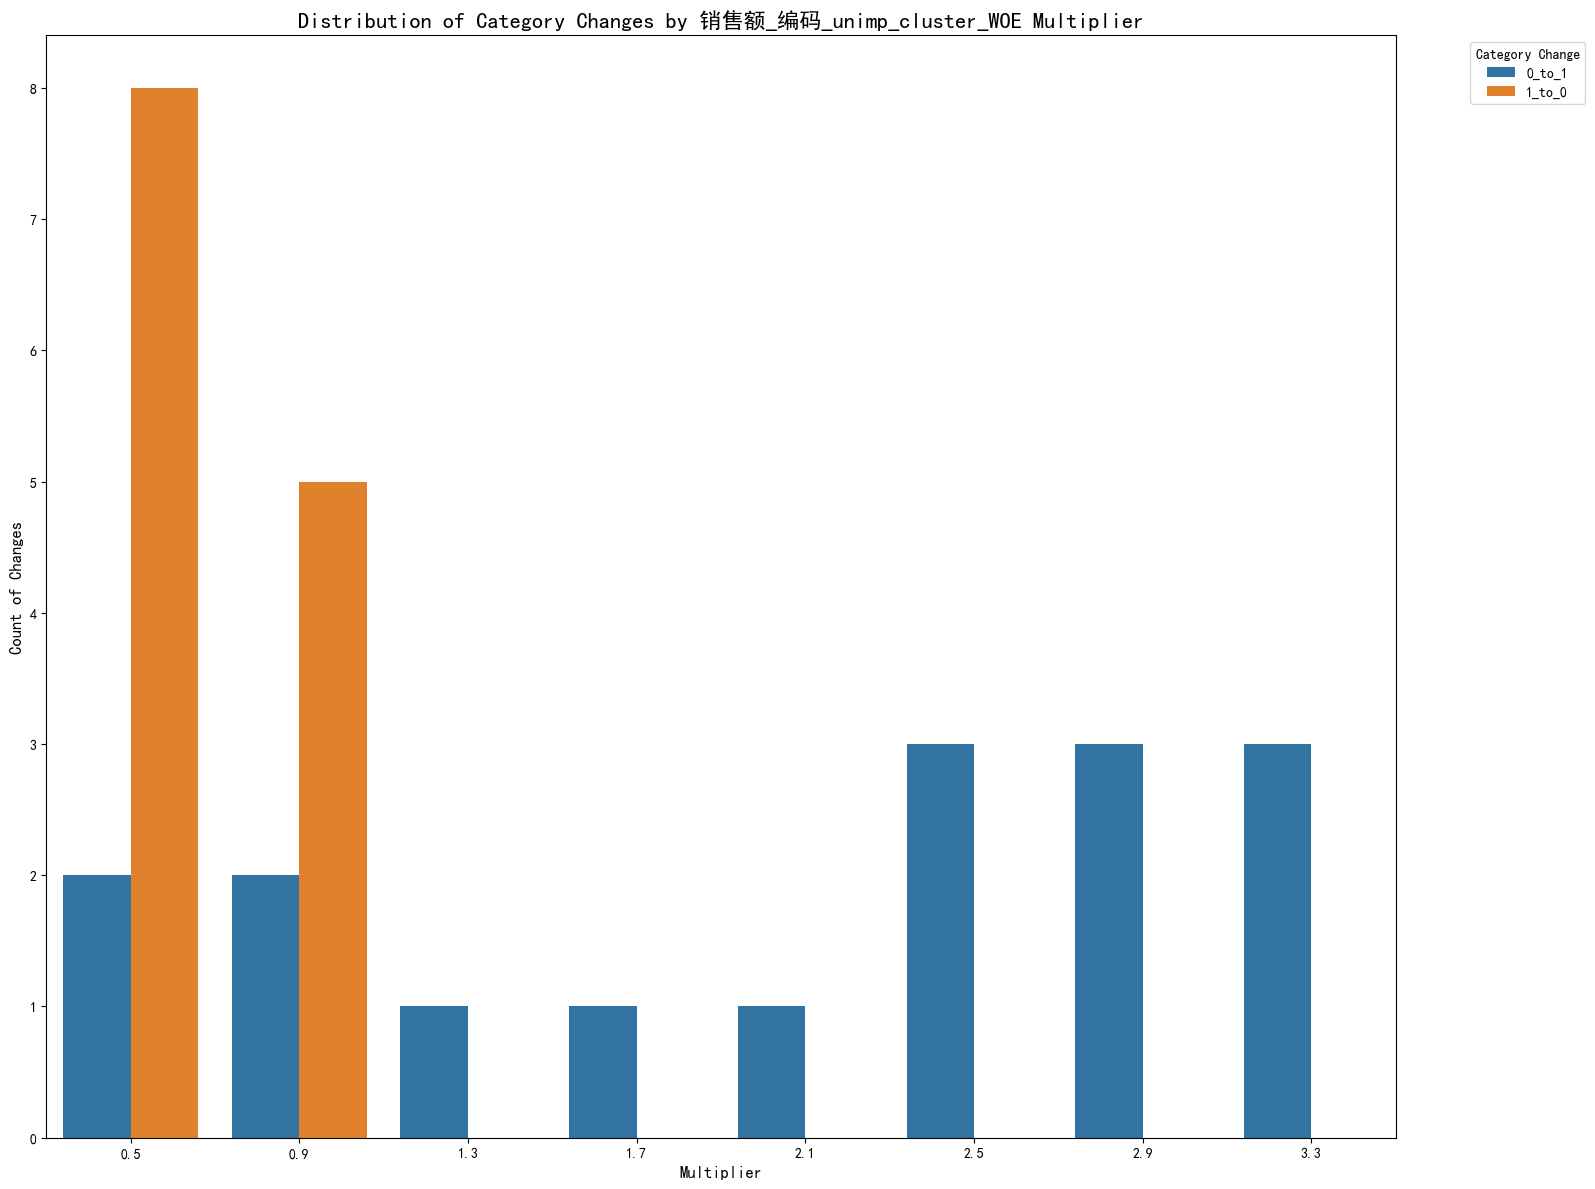

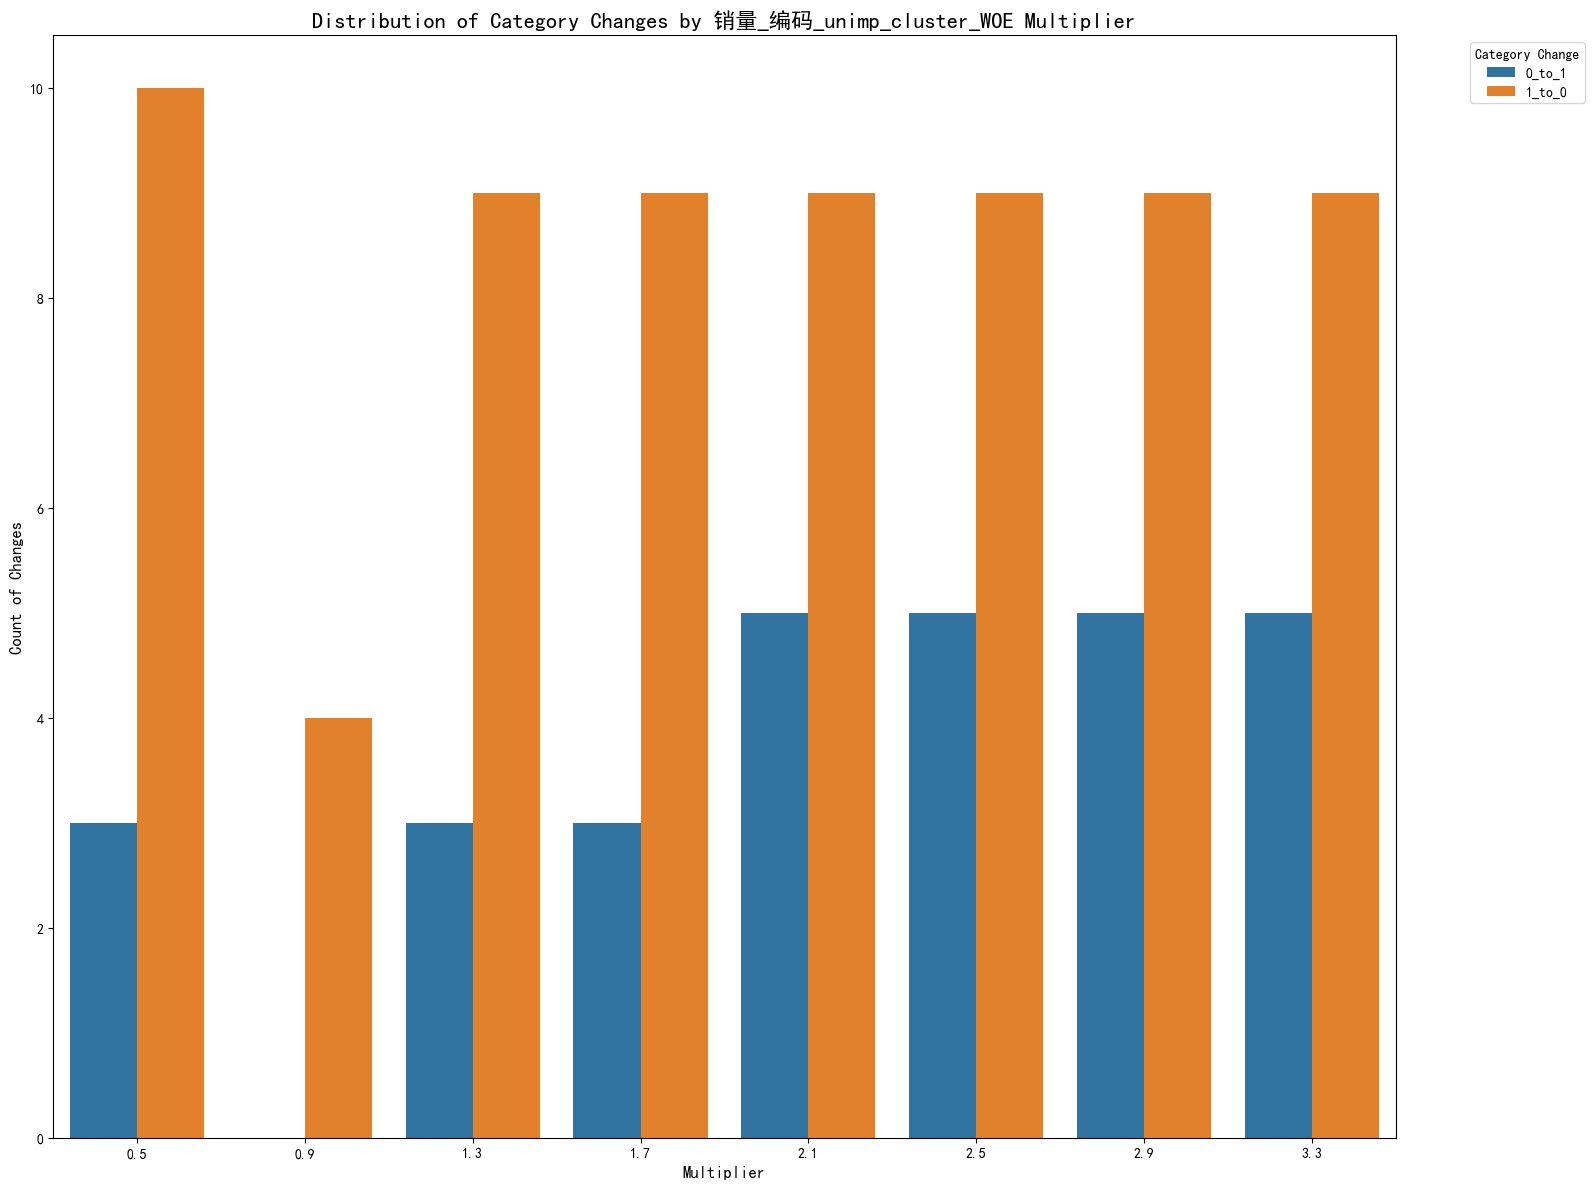

In [14]:
def plot_change_distribution(data,feature):
    # 使用 seaborn 绘制柱状图
    plt.figure(figsize=(16, 12))
    sns.barplot(data=data[(data['Multiplier']!=1) & (data['Feature'] == feature)], x='Multiplier', y='Count', hue='Change Type')
    plt.title(f'Distribution of Category Changes by {feature} Multiplier', fontsize=16)
    plt.xlabel('Multiplier', fontsize=12)
    plt.ylabel('Count of Changes', fontsize=12)
    plt.legend(title='Category Change', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_change_distribution_seaborn(results_csv):
    results_df = pd.read_csv(results_csv,encoding = 'gbk')
    results_df['Feature'] = results_df['Feature'].astype(str)
    results_df['Multiplier'] = results_df['Multiplier'].astype(float)

    # 选择需要展示的类别变化列
#     change_columns = ['0_to_1', '0_to_2', '0_to_3', '1_to_0', '1_to_2', '1_to_3', 
#                       '2_to_0', '2_to_1', '2_to_3', '3_to_0', '3_to_1', '3_to_2']
    change_columns = ['0_to_1',  '1_to_0']
    
    # 创建一个 DataFrame 来存储每个特征与倍数对应的变化数据
    # 将所有的变化列转化为长格式
    change_data = results_df.melt(id_vars=['Feature', 'Multiplier'], value_vars=change_columns, 
                                  var_name='Change Type', value_name='Count')
    
    
    # 调用可视化函数
    features = change_data['Feature'].unique()
    for feature in features:
        plot_change_distribution(change_data,feature)
        
plot_change_distribution_seaborn(df_path)